# Description of the wind power farm life cycle assessment model and system boundaries

This parameterized Life Cycle Assessment (LCA) model has been built in the frame of [LIF-OWI project](https://www.france-energies-marines.org/projets/lif-owi/) with the aim of facilitating the development of tailor-made life cycle inventories to obtain fast estimates of multi-criteria LCA results for offshore fixed and floating wind power projects in France. 

The model uses functions of the python packages [lca_algebraic](https://github.com/oie-mines-paristech/lca_algebraic), and Brightway2.

A report explaining this LCA model is available.

## LIF-OWI model scope and wind power farm subsystems

The parameterized LCA model was developed to evaluate **wind power farms composed of wind turbines ranging between 5 MW and 15 MW capacity.**

The wind power farm is composed of 5 main subsystems, indicated in Figure 1 : 
* Windturbines (divided into 3 subsystems : tower, rotor and nacelle)
* Foundations of wind turbines
* Inter-array cables 
* Offshore substation 
* Export cables (divided into 2 subsystems : aluminium cables and copper cables)

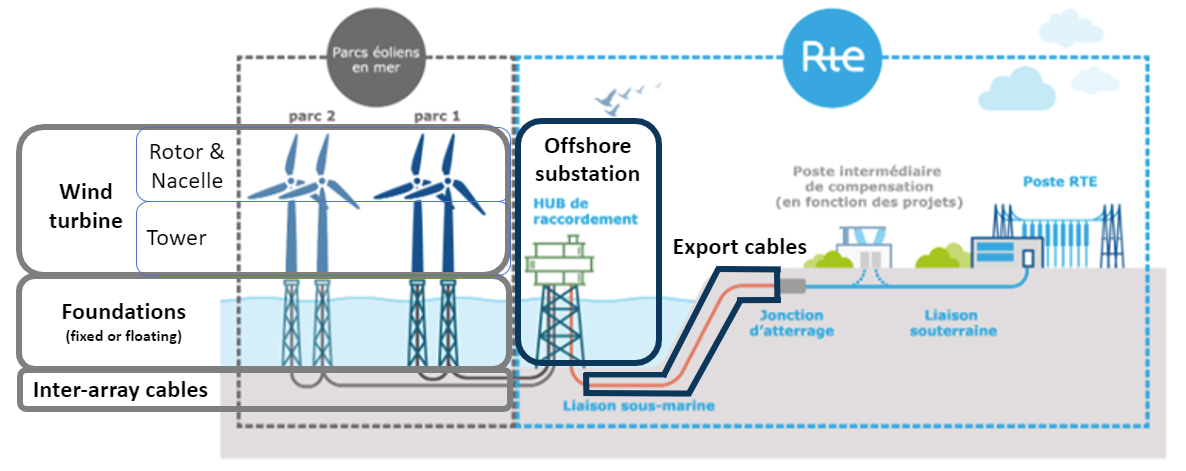

Fig.1. Components of an offshore wind power farm included in LIF-OWI parameterized model (adapted from RTE website)

## Life cycle stages of the wind power farm

The functional unit chosen to refer the estimated impacts to is **1 kWh**. In an intermediate step, the user can also obtain the LCI and impacts associated per **1 MW installed capacity** and at **the scale of the wind farm**. 

The life cycle of the wind power farm has been divided in 6 main stages, namely:
* Manufacturing: raw material extraction, manufactured material production and shaping, assembly of components  ​ 
* Transport from the manufacturing sites to the onshore site
* Installation from the onshore site to the offshore area
* Operation and maintenance
* Decommissioning 
* End-of-life

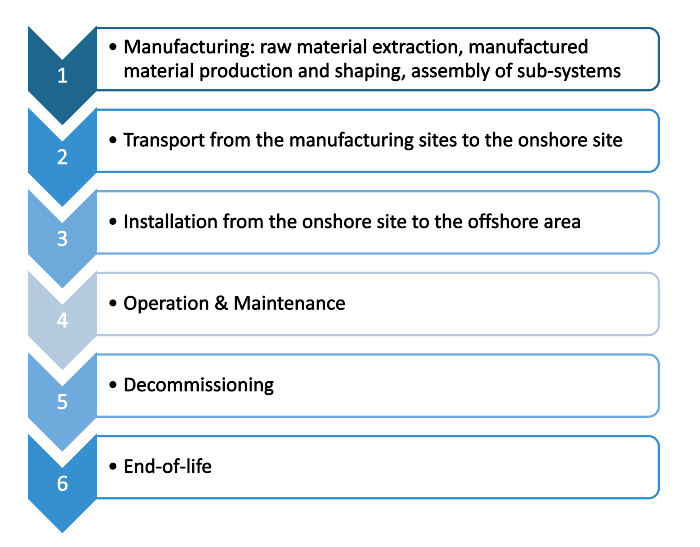
Fig.2. Life cycles stages studied in this model 

The model is divided in sections that correspond to the above-mentioned life cycle stages.

## "Level of use" of the parameterised model

This LCA model is parameterised. It means the values of the inventories flows can be alculated automatically based on the values of a set of parameter.

1️⃣ The user just settles lca_algebraic parameters values.

2️⃣ The user can either change the formula to calculate the intermediate variables, either directly enter the value of this "intermediate variable". 

3️⃣ As in “level 2”, the user can modify the value of some "intermediate variables” that are more detailed than on level 2. 

4️⃣ The user can customise all the flows of the inventory (not only changing material masses)

If there is an icon 1️⃣ or 2️⃣ or 3️⃣ or 4️⃣ in the title of a section, it means that the user has to change something in this section to use the model at the level indicated by the icon. 

# Initialization of the model (import of packages and functions)

In [1]:
#Automatic reload of .py files
%load_ext autoreload
%autoreload 2

# We import all the usefull librairies including lca_algebraic as agb.
from init import *

# Import constants (text and numbers)
from constants import *

# Import custom functions
from utils import compute_value
from utils import values_table
from utils import compute_impacts
from utils import list_parameters_as_df
from utils import export_data_to_excel

#Import functions that define background flows
from background_flows import negAct
from background_flows import import_background
from background_flows import print_background
from background_flows import USER_DB

#Import mass model - Sacchi 2019
from sympy import exp #import exp function from sympy as lca_algebraic calculations run with sympy
from mass_extrapolation_functions import nacelle_weight_kg_power_MW, rotor_weight_kg_power_MW, tower_weight_kg_power_MW, total_wind_turbine_weight_kg_power_MW
from mass_extrapolation_functions import p_rotor_power_OFF,p_height_power_OFF,p_nacelle_weight_power_OFF,p_rotor_weight_rotor_diameter_OFF,p_tower_weight_d2h

#Import rotor diameter model - own model
from mass_extrapolation_functions import rotor_diameter_m_power_MW_2,tower_mass_t_power_MW_2,three_blades_mass_t_power_MW_2,nacelle_with_hub_mass_t_power_MW_2,wind_turbine_mass_t_power_MW_2
from mass_extrapolation_functions import jacket_mass_per_length_tperm_power_MW

In [2]:
# Setup new project
agb.initProject('Parameterized_model_OWF_Original')

# Import Ecoinvent DB (if not already done)
# To do : Update the PATH to suit your installation
agb.importDb("ecoinvent", '/var/local/ecoinvent/ecoinvent3.7/datasets')

# We use a separate DB for defining our model, reset it beforehand
agb.resetDb(USER_DB)

# Reset the definition of all parameters 
agb.resetParams()

Biosphere database already present!!! No setup is needed


Database 'ecoinvent' has already been imported 
Db lif-owi was here. Reseting it


# Selection of LCIA method and impact categories

## LCIA method

In [3]:
# We choose the LCIA method : the Environmental Footprint method v3.0 
LCIA_method = 'EF v3.0'

## Selection of impact categories 

In [4]:
# We define the impacts categories that we want to study
climate_tot = (LCIA_method,'climate change','global warming potential (GWP100)')
climate_bio = (LCIA_method,'climate change: biogenic','global warming potential (GWP100)')
climate_foss = (LCIA_method,'climate change: fossil','global warming potential (GWP100)')
climate_land = (LCIA_method,'climate change: land use and land use change','global warming potential (GWP100)')
ecosystem_quality_ecotox= (LCIA_method,'ecotoxicity: freshwater','comparative toxic unit for ecosystems (CTUe) ')
ecosystem_quality_acid = (LCIA_method,'acidification','accumulated exceedance (ae)')
ecosystem_quality_fresh_eut = (LCIA_method,'eutrophication: freshwater','fraction of nutrients reaching freshwater end compartment (P)')
ecosystem_quality_mar_eut = (LCIA_method,'eutrophication: marine','fraction of nutrients reaching marine end compartment (N)')
ecosystem_quality_ter_eut=(LCIA_method,'eutrophication: terrestrial','accumulated exceedance (AE) ')
human_health_io= (LCIA_method,'ionising radiation: human health','human exposure efficiency relative to u235')
human_health_oz= (LCIA_method,'ozone depletion','ozone depletion potential (ODP) ')
human_health_pht= (LCIA_method, 'photochemical ozone formation: human health','tropospheric ozone concentration increase')
human_health_res= (LCIA_method,'particulate matter formation','impact on human health')
human_health_noncar= (LCIA_method,'human toxicity: non-carcinogenic','comparative toxic unit for human (CTUh) ')
human_health_car= (LCIA_method,'human toxicity: carcinogenic','comparative toxic unit for human (CTUh) ')
resources_foss =(LCIA_method,  'energy resources: non-renewable',  'abiotic depletion potential (ADP): fossil fuels')
resources_land = (LCIA_method, 'land use', 'soil quality index')
resources_min_met =(LCIA_method,'material resources: metals/minerals','abiotic depletion potential (ADP): elements (ultimate reserves)')
resources_water = (LCIA_method,  'water use',  'user deprivation potential (deprivation-weighted water consumption)')

In [5]:
#We define a list of 19 impacts
impacts_EF_3_0 = [climate_tot, climate_bio, climate_foss, climate_land, ecosystem_quality_ecotox,ecosystem_quality_acid,
                  ecosystem_quality_fresh_eut, 
                  ecosystem_quality_mar_eut, 
                  ecosystem_quality_ter_eut, human_health_io,
                  human_health_oz, human_health_pht, human_health_res, human_health_noncar, human_health_car, resources_foss,
                  resources_land, resources_min_met, resources_water]

#We define a list of 1 impact (climate change impact) to do fast calculation
impacts_EF_CO2 = [climate_tot]

In [6]:
nb_impacts=len(impacts_EF_3_0)
print(f"We have selected {nb_impacts} impacts categories calculated with the LCIA method : '{LCIA_method}' that are :")
impacts_EF_3_0

We have selected 19 impacts categories calculated with the LCIA method : 'EF v3.0' that are :


[('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'climate change: land use and land use change',
  'global warming potential (GWP100)'),
 ('EF v3.0',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe) '),
 ('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
 ('EF v3.0',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartment (P)'),
 ('EF v3.0',
  'eutrophication: marine',
  'fraction of nutrients reaching marine end compartment (N)'),
 ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE) '),
 ('EF v3.0',
  'ionising radiation: human health',
  'human exposure efficiency relative to u235'),
 ('EF v3.0', 'ozone depletion', 'ozone depletion potential (ODP) '),
 ('EF v3.0',
  'photochemical ozone formation: human

# 1️⃣ Definition of lca_algebraic parameters

In this section, we define the main variable parameters that will be used for modeling the wind electricity production facility.

Level 1️⃣ : you have to settle the default values of parameters in the parameters.py file. 

In [7]:
from parameters import *
#Pay attention to Alert message but do not pay attention to Warning message

In [8]:
# The list of parameters is : 
agb.list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
1. Global wind farm,availability,ratio of time when the windturbines are not stopped for maintenance,1,0.9,1,,linear,,[project]
1. Global wind farm,elec_losses,ratio of electricity losses between the production (wind turbines) and the landfall junction,0.017,0.002,0.02,,linear,,[project]
1. Global wind farm,fixed_foundations,the type of foundations fixed/floating,1,,,,,,[project]
1. Global wind farm,foundations_type,the type of foundations. Warning : water depth and foundation type are correlated,monopod,,,,,,[project]
1. Global wind farm,length_1_expcable_cop,the length of one copper export cables,1000,0,10000,,linear,m,[project]
1. Global wind farm,length_1_expcable_tot,the total length of one export cables,20000,10000,40000,,linear,m,[project]
1. Global wind farm,life_time,the life time of wind farm,25,20,30,,linear,years,[project]
1. Global wind farm,load_rate,ratio of the total electricity produced against the theoretical one for a year,0.4,0,1,,linear,,[project]
1. Global wind farm,n_turbines,the number of wind turbines in the wind farm,60,1,100,,linear,turbines,[project]
1. Global wind farm,turbine_MW,the unit capacity of one wind turbine,8,5,15,,linear,MW,[project]


# Definition of activities from the background database

In this section, we import the background activities (i.e. ecoinvent processes from technosphere) that will be used for modeling the wind electricity production facility. These activities are defined in background_flows.py files 

## Definition of background activities

In [9]:
# Get all background activities
acts = import_background()

# Import them as global variable in current scope
globals().update(acts)

# Print the background flows
print_background(acts)

Activity 'treatment of hazardous waste, underground deposit_neg' was already in 'lif-owi'. Overwriting it


,name,background_flow,loc,unit
0,steel_low_alloyed,"market for steel, low-alloyed",GLO,kilogram
1,steel_unalloyed,"market for steel, unalloyed",GLO,kilogram
2,aluminium,"market for aluminium, wrought alloy",GLO,kilogram
3,concrete,"market group for concrete, normal",GLO,cubic meter
4,glass_fibre,market for glass fibre,GLO,kilogram
5,epoxy,"market for epoxy resin, liquid",RER,kilogram
6,wood_mix,"sawnwood, paraná pine, dried (u=10%), import f...",RER,cubic meter
7,polypropylene,"market for polypropylene, granulate",GLO,kilogram
8,cast_iron,market for cast iron,GLO,kilogram
9,chromium_steel,"market for steel, chromium steel 18/8",GLO,kilogram


**Warning !!!** 
Activities with negative flows are corrected with **negAct function**.
We use negAct function to correct the sign of some activities that are accounted as negative in brightway (mostly waste treatment activities)
Warning, if you print activities defined with negAct, the reference flow will still appear as negative
when you print them with agb.printAct
but it will be accounted as a positive flow (you can compute a basic impact calcultation to check that)

## Definition of new materials activities including recycling
The recycling of materials is modeled with a simple cut-off approach. We define new material activities that are a mix between virgin and recycled material for **aluminium, steel, copper and concrete.** <br>
<br>
As the exchanges of market activities have same code names, they can not be sorted easily by their code names using updateExchange function. This is why specific functions are defined to be able to manipulate the exchanges using their input name and / or their location. 

### Steel

In [10]:
#Copy of market for steel to be modified
steel_low_alloyed_mix = agb.copyActivity(
    USER_DB,
    steel_low_alloyed, 
    "steel mix primary and recycled",
    location="GLO")

#Print activity before being modified
agb.printAct(steel_low_alloyed)

#List of exchanges in this activity
exchs=steel_low_alloyed_mix.exchanges()

market for steel, low-alloyed (1.000000 kilogram)  \
                                                                                                input   
steel, low-alloyed                                     steel production, electric, low-alloyed[CA-QC]   
steel, low-alloyed#1                                      steel production, electric, low-alloyed[IN]   
steel, low-alloyed#2                                     steel production, converter, low-alloyed[IN]   
steel, low-alloyed#3                                    steel production, converter, low-alloyed[RER]   
steel, low-alloyed#4                                      steel production, electric, low-alloyed[AT]   
steel, low-alloyed#5                                steel production, electric, low-alloyed[Europe...   
steel, low-alloyed#6                                      steel production, electric, low-alloyed[CH]   
steel, low-alloyed#7                                     steel production, electric, low-alloyed[RoW]   
steel, low-alloyed#8                                    steel production, converter, low-alloyed[RoW]   
transport, freight train                                    market group for transport, freight train   
transport, freight, inland waterways, barge         market group for transport, freight, inland wa...   
transport, freight, lorry, unspecified              market group for transport, freight, lorry, un...   
transport, freight, sea, bulk carrier for dry g...  market for transport, freight, sea, bulk carri...   

                                                                            
                                                     amount           unit  
steel, low-alloyed                                  0.00401       kilogram  
steel, low-alloyed#1                                 0.0398       kilogram  
steel, low-alloyed#2                                 0.0643       kilogram  
steel, low-alloyed#3                                 0.0382       kilogram  
steel, low-alloyed#4                               2.89e-06       kilogram  
steel, low-alloyed#5                                  0.196       kilogram  
steel, low-alloyed#6                                0.00115       kilogram  
steel, low-alloyed#7                                  0.518       kilogram  
steel, low-alloyed#8                                  0.138       kilogram  
transport, freight train                               0.19  ton kilometer  
transport, freight, inland waterways, barge          0.0201  ton kilometer  
transport, freight, lorry, unspecified                0.206  ton kilometer  
transport, freight, sea, bulk carrier for dry g...    0.441  ton kilometer

In [11]:
# We calculate the share of recycled material in the market ecoinvent activity
steel_recycled_share_IN_ecoinvent=0       #initialisation
for exch in exchs:
    act=agb.getActByCode(*exch["input"])  #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
    if "electric" in (act['name']):       #recycled steel activities include "electric" in their name
        steel_recycled_share_IN_ecoinvent=steel_recycled_share_IN_ecoinvent+exch["amount"]

steel_primary_share_IN_ecoinvent=1-steel_recycled_share_IN_ecoinvent
print("{:.0%}".format(steel_recycled_share_IN_ecoinvent))

76%


In [12]:
#We change the value of exchanges' amount to make vary the recycling rate using the recycling rate parameter and the ecoinvent static recycling rate

def replace_steel(exch,keyword_recycled,keyword_primary):
    act=agb.getActByCode(*exch["input"]) #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
    if keyword_recycled in (act['name']):
        old_exc_amount=exch["amount"]
        exch["formula"]=str(old_exc_amount*steel_recycled_share_IN/steel_recycled_share_IN_ecoinvent)
        exch.save()

    elif keyword_primary in (act['name']): 
        old_exc_amount=exch["amount"]
        exch["formula"]=str(old_exc_amount*steel_primary_share_IN/steel_primary_share_IN_ecoinvent)
        exch.save()

for exch in exchs:
    replace_steel(exch,"electric","converter")



In [13]:
#Print the differences between ecoinvent activity and parameterised activity 
agb.printAct(steel_low_alloyed,steel_low_alloyed_mix)

#Print the inventory with a given value of recycled share
agb.printAct(steel_low_alloyed_mix,steel_recycled_share_IN=0.76)

steel mix primary and recycled (1.000000 kilogram)  \
                                                                                                input   
steel, low-alloyed                                     steel production, electric, low-alloyed[CA-QC]   
steel, low-alloyed#1                                      steel production, electric, low-alloyed[IN]   
steel, low-alloyed#2                                     steel production, converter, low-alloyed[IN]   
steel, low-alloyed#3                                    steel production, converter, low-alloyed[RER]   
steel, low-alloyed#4                                      steel production, electric, low-alloyed[AT]   
steel, low-alloyed#5                                steel production, electric, low-alloyed[Europe...   
steel, low-alloyed#6                                      steel production, electric, low-alloyed[CH]   
steel, low-alloyed#7                                     steel production, electric, low-alloyed[RoW]   
steel, low-alloyed#8                                    steel production, converter, low-alloyed[RoW]   
transport, freight train                                    market group for transport, freight train   
transport, freight, inland waterways, barge         market group for transport, freight, inland wa...   
transport, freight, lorry, unspecified              market group for transport, freight, lorry, un...   
transport, freight, sea, bulk carrier for dry g...  market for transport, freight, sea, bulk carri...   

                                                                         \
                                                                 amount   
steel, low-alloyed                                  0.00401152170617431   
steel, low-alloyed#1                                 0.0398848458567080   
steel, low-alloyed#2                                 0.0640670896551722   
steel, low-alloyed#3                                 0.0380689655172413   
steel, low-alloyed#4                                2.89446249103487e-6   
steel, low-alloyed#5                                  0.196414755737995   
steel, low-alloyed#6                                0.00114664936961647   
steel, low-alloyed#7                                  0.518539332867015   
steel, low-alloyed#8                                  0.137863944827586   
transport, freight train                                           0.19   
transport, freight, inland waterways, barge                      0.0201   
transport, freight, lorry, unspecified                            0.206   
transport, freight, sea, bulk carrier for dry g...                0.441   

                                                                   
                                                             unit  
steel, low-alloyed                                       kilogram  
steel, low-alloyed#1                                     kilogram  
steel, low-alloyed#2                                     kilogram  
steel, low-alloyed#3                                     kilogram  
steel, low-alloyed#4                                     kilogram  
steel, low-alloyed#5                                     kilogram  
steel, low-alloyed#6                                     kilogram  
steel, low-alloyed#7                                     kilogram  
steel, low-alloyed#8                                     kilogram  
transport, freight train                            ton kilometer  
transport, freight, inland waterways, barge         ton kilometer  
transport, freight, lorry, unspecified              ton kilometer  
transport, freight, sea, bulk carrier for dry g...  ton kilometer

### Aluminium

In [14]:
#Copy of market for aluminium to be modified
aluminium_mix = agb.copyActivity(
    USER_DB,
    aluminium, 
    "aluminium mix primary and recycled",
    location="GLO")

#Print activity before being modified
agb.printAct(aluminium_mix)

#List of exchanges in this activity
exchs=aluminium_mix.exchanges()

aluminium mix primary and recycled (1.000000 kilogram)  \
                                                                                             input   
aluminium, wrought alloy                     aluminium ingot, primary, to aluminium, wrough...       
aluminium, wrought alloy#1                   treatment of aluminium scrap, new, at remelter...       
aluminium, wrought alloy#2                   treatment of aluminium scrap, post-consumer, p...       
aluminium, wrought alloy#3                   treatment of aluminium scrap, new, at remelter...       
aluminium, wrought alloy#4                   treatment of aluminium scrap, post-consumer, p...       
transport, freight train                             market group for transport, freight train       
transport, freight, inland waterways, barge  market group for transport, freight, inland wa...       
transport, freight, lorry, unspecified       market group for transport, freight, lorry, un...       
transport, freight, sea, container ship      market for transport, freight, sea, container ...       

                                                                    
                                             amount           unit  
aluminium, wrought alloy                      0.696       kilogram  
aluminium, wrought alloy#1                   0.0253       kilogram  
aluminium, wrought alloy#2                  0.00193       kilogram  
aluminium, wrought alloy#3                    0.222       kilogram  
aluminium, wrought alloy#4                   0.0551       kilogram  
transport, freight train                      0.345  ton kilometer  
transport, freight, inland waterways, barge  0.0363  ton kilometer  
transport, freight, lorry, unspecified        0.361  ton kilometer  
transport, freight, sea, container ship       0.363  ton kilometer

In [15]:
# We calculate the share of recycled material in the market ecoinvent activity

alu_recycled_share_IN_ecoinvent=0         #initialisation
for exch in exchs:
    act=agb.getActByCode(*exch["input"])  #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
    if "scrap" in (act['name']):         #recycled aluminium activities include "scrap" in their name
        alu_recycled_share_IN_ecoinvent=alu_recycled_share_IN_ecoinvent+exch["amount"]

alu_primary_share_IN_ecoinvent=1-alu_recycled_share_IN_ecoinvent

print("{:.0%}".format(alu_recycled_share_IN_ecoinvent))

30%


In [16]:
#We change the value of exchanges' amount to make vary the recycling rate using the recycling rate parameter and the ecoinvent static recycling rate

def replace_alu(exch,keyword_recycled,keyword_primary):
    act=agb.getActByCode(*exch["input"]) #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
    
    if keyword_recycled in (act['name']):
        old_exc_amount=exch["amount"]
        exch["formula"]=str(old_exc_amount*alu_recycled_share_IN/alu_recycled_share_IN_ecoinvent)
        exch.save()

    elif keyword_primary in (act['name']):
        old_exc_amount=exch["amount"]
        exch["formula"]=str(old_exc_amount*alu_primary_share_IN/alu_primary_share_IN_ecoinvent)
        exch.save()

for exch in exchs:
    replace_alu(exch,"scrap","primary")

    

In [17]:
#Print the differences between ecoinvent activity and parameterised activity 
agb.printAct(aluminium,aluminium_mix)

#Print the inventory with a given value of recycled share
agb.printAct(aluminium_mix,alu_recycled_share_IN=0.30)

aluminium mix primary and recycled (1.000000 kilogram)  \
                                                                                             input   
aluminium, wrought alloy                     aluminium ingot, primary, to aluminium, wrough...       
aluminium, wrought alloy#1                   treatment of aluminium scrap, new, at remelter...       
aluminium, wrought alloy#2                   treatment of aluminium scrap, post-consumer, p...       
aluminium, wrought alloy#3                   treatment of aluminium scrap, new, at remelter...       
aluminium, wrought alloy#4                   treatment of aluminium scrap, post-consumer, p...       
transport, freight train                             market group for transport, freight train       
transport, freight, inland waterways, barge  market group for transport, freight, inland wa...       
transport, freight, lorry, unspecified       market group for transport, freight, lorry, un...       
transport, freight, sea, container ship      market for transport, freight, sea, container ...       

                                                                  \
                                                          amount   
aluminium, wrought alloy                       0.699999999999999   
aluminium, wrought alloy#1                    0.0249416849923542   
aluminium, wrought alloy#2                   0.00190526760358261   
aluminium, wrought alloy#3                     0.218807869480736   
aluminium, wrought alloy#4                    0.0543451779233274   
transport, freight train                                   0.345   
transport, freight, inland waterways, barge               0.0363   
transport, freight, lorry, unspecified                     0.361   
transport, freight, sea, container ship                    0.363   

                                                            
                                                      unit  
aluminium, wrought alloy                          kilogram  
aluminium, wrought alloy#1                        kilogram  
aluminium, wrought alloy#2                        kilogram  
aluminium, wrought alloy#3                        kilogram  
aluminium, wrought alloy#4                        kilogram  
transport, freight train                     ton kilometer  
transport, freight, inland waterways, barge  ton kilometer  
transport, freight, lorry, unspecified       ton kilometer  
transport, freight, sea, container ship      ton kilometer

### Copper

In [18]:
#Copy of market for copper to be modified
copper_mix = agb.copyActivity(
    USER_DB,
    copper, 
    "copper mix primary and recycled",
    location="GLO")

#Print activity before being modified
agb.printAct(copper_mix)

#List of exchanges in this activity
exchs=copper_mix.exchanges()

copper mix primary and recycled (1.000000 kilogram)  \
                                                                 input   
copper, cathode     aluminium alloy production, Metallic Matrix Co...    
copper, cathode#1   copper production, cathode, solvent extraction...    
copper, cathode#10  aluminium alloy production, Metallic Matrix Co...    
copper, cathode#11  treatment of metal part of electronics scrap, ...    
copper, cathode#12      primary zinc production from concentrate[RoW]    
copper, cathode#13              aluminium alloy production, AlLi[RoW]    
copper, cathode#14  treatment of copper scrap by electrolytic refi...    
copper, cathode#15                                  cobalt production    
copper, cathode#16  treatment of non-Fe-Co-metals, from used Li-io...    
copper, cathode#17                            treatment of used cable    
copper, cathode#18  treatment of non-Fe-Co-metals, from used Li-io...    
copper, cathode#2                gold mine operation and refining[SE]    
copper, cathode#3   platinum group metal, extraction and refinery ...    
copper, cathode#4                            treatment of copper cake    
copper, cathode#5   treatment of metal part of electronics scrap, ...    
copper, cathode#6             aluminium alloy production, AlLi[CA-QC]    
copper, cathode#7                    electrorefining of copper, anode    
copper, cathode#8   platinum group metal mine operation, ore with ...    
copper, cathode#9   treatment of copper scrap by electrolytic refi...    

                                       
                     amount      unit  
copper, cathode    1.83e-10  kilogram  
copper, cathode#1      0.17  kilogram  
copper, cathode#10 1.45e-09  kilogram  
copper, cathode#11  0.00102  kilogram  
copper, cathode#12 0.000275  kilogram  
copper, cathode#13 3.71e-10  kilogram  
copper, cathode#14     0.15  kilogram  
copper, cathode#15  0.00123  kilogram  
copper, cathode#16 2.13e-06  kilogram  
copper, cathode#17   0.0119  kilogram  
copper, cathode#18 9.33e-07  kilogram  
copper, cathode#2   0.00681  kilogram  
copper, cathode#3   0.00118  kilogram  
copper, cathode#4    0.0022  kilogram  
copper, cathode#5  1.55e-05  kilogram  
copper, cathode#6  1.83e-10  kilogram  
copper, cathode#7     0.605  kilogram  
copper, cathode#8    0.0157  kilogram  
copper, cathode#9     0.034  kilogram

In [19]:
# Simplification and normalisation of copper activity
correction_copper_1kg=0 #initialisation

for exch in exchs:
    act=agb.getActByCode(*exch["input"])    #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
 
    if exch["amount"]<=0.01:      # We simplify the copper activity by deleting exchanges below 0,01 kg
        correction_copper_1kg=correction_copper_1kg+exch["amount"]
        exch["amount"]=0          # exc = 0 instead of delete exc to picture better the changes with printAct
        #exch.delete()
        exch.save()
    else :                       # We normalize the remaining exchanges so that their sum equals to 1 kg
        exch["amount"]=exch["amount"]/(1-correction_copper_1kg)
        exch.save()
        
print("%.3f" % (1-correction_copper_1kg)) #The remaining exchanges in kg before being resized"
agb.printAct(copper,copper_mix)

0.987


In [20]:
# We calculate the share of recycled material in the simplified market ecoinvent activity
copper_recycled_share_IN_ecoinvent=0       #initialisation
for exch in exchs:                         #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
    act=agb.getActByCode(*exch["input"])
    if "treatment" in (act['name']):       #recycled copper = "treatment ...""
        copper_recycled_share_IN_ecoinvent=copper_recycled_share_IN_ecoinvent+exch["amount"]
copper_primary_share_IN_ecoinvent=1-copper_recycled_share_IN_ecoinvent
print("{:.0%}".format(copper_recycled_share_IN_ecoinvent))

20%


In [21]:
# We introduce the parameter "share of recycled material" normalised by ecoinvent value
def replace_copper(exch,keyword):
    act=agb.getActByCode(*exch["input"]) #exchanges can not be sorted by name as they all have the same name, they have to be sorted by their "input"
    if keyword in (act['name']):
        old_exc_amount=exch["amount"]
        exch["formula"]=str(old_exc_amount*copper_recycled_share_IN/copper_recycled_share_IN_ecoinvent)
        exch.save()  
    else:
        old_exc_amount=exch["amount"]
        exch["formula"]=str(old_exc_amount*copper_primary_share_IN/copper_primary_share_IN_ecoinvent)
        exch.save()

for exch in exchs:
    replace_copper(exch,"treatment")
    



In [22]:
#Print the differences between ecoinvent activity and parameterised activity 
agb.printAct(copper,copper_mix)
#Print the inventory with a given value of recycled share
agb.printAct(copper_mix, copper_recycled_share_IN=0.2)

copper mix primary and recycled (1.000000 kilogram)  \
                                                                 input   
copper, cathode     aluminium alloy production, Metallic Matrix Co...    
copper, cathode#1   copper production, cathode, solvent extraction...    
copper, cathode#10  aluminium alloy production, Metallic Matrix Co...    
copper, cathode#11  treatment of metal part of electronics scrap, ...    
copper, cathode#12      primary zinc production from concentrate[RoW]    
copper, cathode#13              aluminium alloy production, AlLi[RoW]    
copper, cathode#14  treatment of copper scrap by electrolytic refi...    
copper, cathode#15                                  cobalt production    
copper, cathode#16  treatment of non-Fe-Co-metals, from used Li-io...    
copper, cathode#17                            treatment of used cable    
copper, cathode#18  treatment of non-Fe-Co-metals, from used Li-io...    
copper, cathode#2                gold mine operation and refining[SE]    
copper, cathode#3   platinum group metal, extraction and refinery ...    
copper, cathode#4                            treatment of copper cake    
copper, cathode#5   treatment of metal part of electronics scrap, ...    
copper, cathode#6             aluminium alloy production, AlLi[CA-QC]    
copper, cathode#7                    electrorefining of copper, anode    
copper, cathode#8   platinum group metal mine operation, ore with ...    
copper, cathode#9   treatment of copper scrap by electrolytic refi...    

                                                  
                                amount      unit  
copper, cathode                      0  kilogram  
copper, cathode#1    0.170141245898734  kilogram  
copper, cathode#10                   0  kilogram  
copper, cathode#11                   0  kilogram  
copper, cathode#12                   0  kilogram  
copper, cathode#13                   0  kilogram  
copper, cathode#14   0.153183328426278  kilogram  
copper, cathode#15                   0  kilogram  
copper, cathode#16                   0  kilogram  
copper, cathode#17  0.0121660970100349  kilogram  
copper, cathode#18                   0  kilogram  
copper, cathode#2                    0  kilogram  
copper, cathode#3                    0  kilogram  
copper, cathode#4                    0  kilogram  
copper, cathode#5                    0  kilogram  
copper, cathode#6                    0  kilogram  
copper, cathode#7    0.609951054571118  kilogram  
copper, cathode#8   0.0158331461390391  kilogram  
copper, cathode#9   0.0346505745636868  kilogram

### Concrete

In [23]:
concrete_mix = agb.copyActivity(
    USER_DB,
    concrete, 
    "concrete mix - only primary",
    location="GLO")

agb.printAct(concrete)

market group for concrete, normal (1.000000 cubic meter)  \
                                                                      input   
concrete, normal                      market for concrete, normal[BR]         
concrete, normal#1                    market for concrete, normal[CH]         
concrete, normal#2                    market for concrete, normal[CO]         
concrete, normal#3                    market for concrete, normal[IN]         
concrete, normal#4                    market for concrete, normal[PE]         
concrete, normal#5                   market for concrete, normal[RNA]         
concrete, normal#6                    market for concrete, normal[ZA]         
concrete, normal#7                   market for concrete, normal[RoW]         

                                          
                     amount         unit  
concrete, normal     0.0229  cubic meter  
concrete, normal#1 0.000691  cubic meter  
concrete, normal#2  0.00239  cubic meter  
concrete, normal#3   0.0194  cubic meter  
concrete, normal#4   0.0109  cubic meter  
concrete, normal#5   0.0461  cubic meter  
concrete, normal#6  0.00156  cubic meter  
concrete, normal#7    0.896  cubic meter

### Modify by yourself an exchange of market activity

In [24]:
#1. Create an activity "test_act" that you want to modify with agb.copyActivity by copying an existing activity "initial_act"
#1bis. Print it with agb.printAct
#2. Define the of exchanges in this activity
        #exchs=test_act.exchanges()
#3. Define a function to replace an exchange according to its input name and its location
def replace_exchange(exch,keyword,loc):
    act=agb.getActByCode(*exch["input"])  
    if keyword in (act['name']) and loc in act['location']:
        old_exc_amount=exch["amount"]
        exch["amount"]=1 #amount to be updated 
        exch["formula"]=str(old_exc_amount*1) #formula to be updated
        exch.save()
#4. Apply the function to the activity to be modified
    #for exch in exchs:
    #    replace_exchange(exch,"treatment","RER")
#5. Print the initial and modified activity to     
    #agb.printAct(initial_act,test_act)

# Alternative to 3 and 4 : modify directly exchanges without creating a function 
    #for exch in exchs:
    #act=agb.getActByCode(*exch["input"])
        #if  "treatment of copper scrap" in (act['name']) and "RoW" in (act['location']):
           #old_exc_amount=exch["amount"]
           #exch["formula"]=str(old_exc_amount*copper_primary_share_IN/copper_primary_share_IN_ecoinvent)
           #exch.save() 

# Transversal calculation

## 2️⃣ Electricity delivered to the grid
Using the defined input parameters, the total power capacity of the wind farm (in MW) the total electricity (in kWh) delivered to the grid over the lifetime of the offshore wind farm can be estimated with the following equations.

Level 2️⃣ : you can enter directly the total electricity produced by the wind farm, the formula can be deleted and replaced by the given value. 

In [25]:
power_tot_farm_MW=n_turbines*turbine_MW

In [26]:
elec_prod_lifetime_kWh=(load_rate*availability*(1-elec_losses)*8760*turbine_MW*1000*n_turbines*life_time)
#8760 = Number of hours per year
#*1000 to convert from MW to kW

## Wind turbine's mass model = f(turbine_MW)
Using formula provided either by Sacchi et al. 2019 either by a simple model based on online collected data, we calculate rotor diameter, tower height, mass of rotor, mass of nacelle and mass of tower of a wind turbine based on its power capacity. The formulas are imported from the file:  wind_turbine_mass_extrapolation_function.py. The mass model are printed in the file : visualisation_wind_turbine_extrapolation_sacchi_own_model.py <br> 
The calculated masses can then be used or not by the model (section 7.1). 

In [27]:
#Choose the mass_model you want to use
mass_model="model based on online collected data"
#mass_model="sacchi 2019"

In [28]:
#Automatic attribution of mass 
if mass_model=="model based on online collected data":
    mass_nacelle_calc_kg=nacelle_with_hub_mass_t_power_MW_2(turbine_MW)
    mass_rotor_calc_kg=three_blades_mass_t_power_MW_2(turbine_MW)
    mass_tower_calc_kg=tower_mass_t_power_MW_2(turbine_MW)
    mass_wind_turbine_tot_calc_kg=wind_turbine_mass_t_power_MW_2(turbine_MW)
    
if mass_model=="sacchi 2019":
    mass_nacelle_calc_kg=nacelle_weight_kg_power_MW(turbine_MW,*p_nacelle_weight_power_OFF)
    mass_rotor_calc_kg=rotor_weight_kg_power_MW(turbine_MW,*p_rotor_power_OFF,*p_rotor_weight_rotor_diameter_OFF)
    mass_tower_calc_kg=tower_weight_kg_power_MW(turbine_MW, *p_rotor_power_OFF, *p_height_power_OFF, *p_tower_weight_d2h)
    mass_wind_turbine_tot_calc_kg=total_wind_turbine_weight_kg_power_MW(turbine_MW, *p_rotor_power_OFF, *p_height_power_OFF, *p_nacelle_weight_power_OFF, *p_rotor_weight_rotor_diameter_OFF, *p_tower_weight_d2h)

In [29]:
values_table(
    mass_nacelle_calc_kg=(mass_nacelle_calc_kg, "kg"),
    mass_rotor_calc_kg=(mass_rotor_calc_kg, "kg"),
    mass_tower_calc_kg=(mass_tower_calc_kg, "kg"))

,formula,value,unit
name,,,
mass_nacelle_calc_kg,45.8321804154303*turbine_MW + 82.1131181008905,449,kg
mass_rotor_calc_kg,11.6069483679525*turbine_MW + 11.9506931750742,105,kg
mass_tower_calc_kg,56.0170833333333*turbine_MW + 49.7089166666668,498,kg


## Wind turbines rotor diameter model = f(turbine_MW)
The rotor diameter extrapolation is not taken from Sacchi 2019 as the calculated diameter is not relevant for wind turbine with a capacity up to 10 MW. It is taken from our own fit model.

In [30]:
rotor_diameter_calc_m=rotor_diameter_m_power_MW_2(turbine_MW)

In [31]:
values_table(
    rotor_diameter_calc_m=(rotor_diameter_calc_m, "m"))

,formula,value,unit
name,,,
rotor_diameter_calc_m,10.1339342832219*turbine_MW + 84.9152369874963,166,m


## Jacket foundations mass model = f(turbine_MW)

In [32]:
#Mass of jacket per meter is generated with online collected data
lineic_mass_foundations_jacket_calc_kg_per_m=jacket_mass_per_length_tperm_power_MW(turbine_MW)*1000 #kg


## Semi-submersible foundations mass model = f(turbine_MW)

In [33]:
lineic_mass_foundations_semisub_calc_kg_per_m=0 #kg

# Inventories : Manufacture and assembly of components

## Wind turbines : tower, rotor and nacelle

Estimates of input flows to the manufacturing processes were based on data from a reference wind farm composed of 30 wind turbines of 5MW, provided by Kouloumpis and Azapagic (2022), https://doi.org/10.1016/j.spc.2021.10.024.

In [34]:
#Reference data 

#Nominal power of one turbine
POWER_REF_TURBINE_MW = 5 # MW
#Number of turbines in the wind farm
NUMBER_REF_TURBINE = 30 # wind turbines

### Tower 

#### Reference inventory

In [35]:
#Reference data for the tower

#Mass of steel in the tower
MASS_TOWER_STEEL_LOW_ALLOYED_KG=6510660/NUMBER_REF_TURBINE                       #kg
#Mass of steel in the tower
MASS_TOWER_ALUMINIUM_KG=119340/NUMBER_REF_TURBINE                                #kg
#Total mass of the tower
MASS_TOWER_TOT_KG=MASS_TOWER_STEEL_LOW_ALLOYED_KG+MASS_TOWER_ALUMINIUM_KG        #kg

#Amount of other flows
TOWER_ELECTRICITY_kWH= 676923/NUMBER_REF_TURBINE                                  #kWh
TOWER_DIESEL_MJ = 3315*DIESEL_CALORIFIC_VALUE_MJ_PER_L/NUMBER_REF_TURBINE         #MJ
TOWER_HEATING_MJ = 127959*KWH_TO_MJ/NUMBER_REF_TURBINE                            #MJ
TOWER_WELDING_GAS_M = 663/STEEL_KG_PER_METER/NUMBER_REF_TURBINE                   #m
TOWER_FUEL_OIL_MJ = 53703*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L/NUMBER_REF_TURBINE        #MJ
TOWER_WASTEWATER_L = 103428/NUMBER_REF_TURBINE                                    #L or kg (similar)
TOWER_WASTE_UNSPECIFIED_KG = 91494/NUMBER_REF_TURBINE                             #kg
TOWER_WASTE_HAZARDOUS_KG = 663/NUMBER_REF_TURBINE                                 #kg
TOWER_OIL_WASTE_KG = 132.6/NUMBER_REF_TURBINE                                     #kg

In [36]:
#Print a table with the masses of materials of the reference tower
#function values_table is defined in "utils"

values_table(
    MASS_TOWER_TOT_KG=(MASS_TOWER_TOT_KG,"kg"),
    MASS_TOWER_STEEL_LOW_ALLOYED_KG=(MASS_TOWER_STEEL_LOW_ALLOYED_KG, "kg"),
    MASS_TOWER_ALUMINIUM_KG=(MASS_TOWER_ALUMINIUM_KG, "kg"))

,formula,value,unit
name,,,
MASS_TOWER_TOT_KG,2.21e+05,2.21e+05,kg
MASS_TOWER_STEEL_LOW_ALLOYED_KG,2.17e+05,2.17e+05,kg
MASS_TOWER_ALUMINIUM_KG,3.98e+03,3.98e+03,kg


In [37]:
#We define the reference tower manufacturing inventory based on data provided by Kouloumpis and Azapagic, 2022
tower_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the tower of one 5 MW reference turbine ",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=TOWER,
                       exchanges = {
                           steel_low_alloyed_mix:   MASS_TOWER_STEEL_LOW_ALLOYED_KG, 
                           aluminium_mix :          MASS_TOWER_ALUMINIUM_KG,
                           
                           electricity_UCTE:        TOWER_ELECTRICITY_kWH, 
                           diesel_process:          TOWER_DIESEL_MJ,
                           district_heating:        TOWER_HEATING_MJ, 
                           welding_gas:             TOWER_WELDING_GAS_M,
                           fuel_oil_process:        TOWER_FUEL_OIL_MJ,
                           wastewater_treatment:    TOWER_WASTEWATER_L,
                           waste_unspecified:       TOWER_WASTE_UNSPECIFIED_KG,
                           waste_hazardous:         TOWER_WASTE_HAZARDOUS_KG,
                           oil_waste:               TOWER_OIL_WASTE_KG,
             })

#Print the reference inventory
agb.printAct(tower_manufacturing_ref)

manufacturing of the tower of one 5 MW reference turbine  (1.000000 unit)  \
                                                                                                                       input   
aluminium mix primary and recycled                             aluminium mix primary and recycled{FG}                          
heat, non-market, at cogen 160kWe Jakobsberg, a...  heat, non-market, at cogen 160kWe Jakobsberg, ...                          
market for diesel, burned in building machine           market for diesel, burned in building machine                          
market for heavy fuel oil, burned in refinery f...  market for heavy fuel oil, burned in refinery ...                          
market for welding, gas, steel                                         market for welding, gas, steel                          
market group for electricity, medium voltage        market group for electricity, medium voltage[U...                          
steel mix primary and recycled                                     steel mix primary and recycled{FG}                          
treatment of hazardous waste, underground depos...  treatment of hazardous waste, underground depo...                          
treatment of inert waste, inert material landfi...  treatment of inert waste, inert material landf...                          
treatment of waste mineral oil, hazardous waste...  treatment of waste mineral oil, hazardous wast...                          
treatment of wastewater, average, capacity 1.6E...  treatment of wastewater, average, capacity 1.6...                          

                                                                            
                                                     amount           unit  
aluminium mix primary and recycled                 3.98e+03       kilogram  
heat, non-market, at cogen 160kWe Jakobsberg, a... 1.54e+04      megajoule  
market for diesel, burned in building machine      4.27e+03      megajoule  
market for heavy fuel oil, burned in refinery f... 7.32e+04      megajoule  
market for welding, gas, steel                       0.0055          meter  
market group for electricity, medium voltage       2.26e+04  kilowatt hour  
steel mix primary and recycled                     2.17e+05       kilogram  
treatment of hazardous waste, underground depos...     22.1       kilogram  
treatment of inert waste, inert material landfi... 3.05e+03       kilogram  
treatment of waste mineral oil, hazardous waste...     4.42       kilogram  
treatment of wastewater, average, capacity 1.6E... 3.45e+03    cubic meter

In [38]:
# Explore the climate change impacts of the reference inventory
agb.exploreImpacts(impacts_EF_CO2[0], tower_manufacturing_ref)

Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3


manufacturing of the tower of one 5 MW reference turbine  (1.000000 unit)  \
                                                                                                                       input   
aluminium mix primary and recycled                        aluminium mix primary and recycled{user-db}                          
heat, non-market, at cogen 160kWe Jakobsberg, a...  heat, non-market, at cogen 160kWe Jakobsberg, ...                          
market for diesel, burned in building machine           market for diesel, burned in building machine                          
market for heavy fuel oil, burned in refinery f...  market for heavy fuel oil, burned in refinery ...                          
market for welding, gas, steel                                         market for welding, gas, steel                          
market group for electricity, medium voltage        market group for electricity, medium voltage[U...                          
steel mix primary and recycled                                steel mix primary and recycled{user-db}                          
treatment of hazardous waste, underground depos...  treatment of hazardous waste, underground depo...                          
treatment of inert waste, inert material landfi...  treatment of inert waste, inert material landf...                          
treatment of waste mineral oil, hazardous waste...  treatment of waste mineral oil, hazardous wast...                          
treatment of wastewater, average, capacity 1.6E...  treatment of wastewater, average, capacity 1.6...                          

                                                                      
                                                     amount   impact  
aluminium mix primary and recycled                 3.98e+03 5.61e+04  
heat, non-market, at cogen 160kWe Jakobsberg, a... 1.54e+04      451  
market for diesel, burned in building machine      4.27e+03      391  
market for heavy fuel oil, burned in refinery f... 7.32e+04 6.14e+03  
market for welding, gas, steel                       0.0055  0.00101  
market group for electricity, medium voltage       2.26e+04 1.05e+04  
steel mix primary and recycled                     2.17e+05 2.89e+05  
treatment of hazardous waste, underground depos...     22.1     4.64  
treatment of inert waste, inert material landfi... 3.05e+03     12.9  
treatment of waste mineral oil, hazardous waste...     4.42     12.6  
treatment of wastewater, average, capacity 1.6E... 3.45e+03 1.56e+03

####  2️⃣ 3️⃣ 4️⃣ Resizing masses
 1️⃣ wind_turbine_inventory = "sacchi_mass_model" > If you only know the power capacity of the turbine, you have nothing to do, the masses are calculated based on Sacchi's mass model
 
 2️⃣ wind_turbine_inventory = "user_mass_model" > If you know the aggregated masses of tower/rotor/nacelle, you can enter their values (or formula to calculate them)
 
 3️⃣ wind_turbine_inventory = "bill_of_materials" > If you know the bill of materials, you can enter the masses of materials
 
 4️⃣ wind_turbine_inventory = "custom" > If you get the whole inventory of the wind turbine, you can enter the bill of materials in this section and the whole inventory in the next section. Warning ! if you change material masses values, it shall be done using material masses variables (ex: mass_tower_steel_kg) as these mass values are reused in other parts of the model (eg for transport, maintenance, end of life)

In [39]:
#Delete the # at the beginning of the line corresponding to the chosen level and put an # in front of the other lines

tower_wind_turbine_inventory = "sacchi_mass_model"           #level 1
#tower_wind_turbine_inventory = "user_mass_model"            #level 2
#tower_wind_turbine_inventory = "bill_of_materials"          #Level 3
#tower_wind_turbine_inventory = "custom"                     #Level 4

In [40]:
#Depending on the level selected, change the value of the variables in the dedicated section (except in level 1)

if tower_wind_turbine_inventory=="sacchi_mass_model":
    # level 1: Calculation of the total mass of the tower based on Sacchi tower/rotor/nacelle mass model
    mass_tower_tot_kg=mass_tower_calc_kg
    
    #Automatic calculation : we assume material ratios in the tower are the same as in the reference inventory 
    resizing_mass_tower=mass_tower_tot_kg/MASS_TOWER_TOT_KG
    mass_tower_steel_kg=MASS_TOWER_STEEL_LOW_ALLOYED_KG*resizing_mass_tower
    mass_tower_alu_kg=MASS_TOWER_ALUMINIUM_KG*resizing_mass_tower

elif tower_wind_turbine_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the tower based on user mass model (formula or given value )
    mass_tower_tot_kg=0
    
    #Automatic calculation : we assume material ratios in the tower are the same as in the reference inventory 
    resizing_mass_tower=mass_tower_tot_kg/MASS_TOWER_TOT_KG
    mass_tower_steel_kg=MASS_TOWER_STEEL_LOW_ALLOYED_KG*resizing_mass_tower
    mass_tower_alu_kg=MASS_TOWER_ALUMINIUM_KG*resizing_mass_tower
    
    
elif tower_wind_turbine_inventory=="bill_of_materials":
    #Level 3 : if you have the masses of each material, enter the value of the masses
    mass_tower_steel_kg=0 #kg
    mass_tower_alu_kg=0 #kg
    
    #Automatic calculation of the total mass
    mass_tower_tot_kg=mass_tower_steel_kg+mass_tower_alu_kg
    resizing_mass_tower=mass_tower_tot_kg/MASS_TOWER_TOT_KG
    
elif tower_wind_turbine_inventory=="custom":
    #Level 4 : if you have the whole inventory of the wind turbine,  enter the value of the masses (and you will enter the new inventory in the next section)
    mass_tower_steel_kg=0 #kg
    mass_tower_alu_kg=0 #kg
    
    #Automatic calculation of the total mass
    mass_tower_tot_kg=mass_tower_steel_kg+mass_tower_alu_kg


In [41]:
#Print a table with the masses of materials of the modeled tower
#function values_table is defined in "utils"
values_table(
    resizing_mass_tower=(resizing_mass_tower, " "),
    mass_tower_tot_kg=(mass_tower_tot_kg, "kg"),
    mass_tower_steel_kg=(mass_tower_steel_kg, "kg"),
    mass_tower_alu_kg=(mass_tower_alu_kg, "kg"))

,formula,value,unit
name,,,
resizing_mass_tower,0.000253470965309201*turbine_MW + 0.0002249272...,0.00225,
mass_tower_tot_kg,56.0170833333333*turbine_MW + 49.7089166666668,498,kg
mass_tower_steel_kg,55.0087758333334*turbine_MW + 48.8141561666668,489,kg
mass_tower_alu_kg,1.0083075*turbine_MW + 0.894760500000002,8.96,kg


#### 4️⃣ Resizing the inventory

In [42]:
if tower_wind_turbine_inventory=="sacchi_mass_model":
    #Level 1: Resized inventory : linear extrapolation based on the total mass of the tower
    tower_manufacturing_resized_1 = agb.newActivity(USER_DB,
                       "manufacturing of the tower of one wind turbine - reference inventory is resized based on Sacchi's mass model",
                       unit = "unit",
                       exchanges = {tower_manufacturing_ref:resizing_mass_tower                         
             })   
    tower_manufacturing = tower_manufacturing_resized_1

elif tower_wind_turbine_inventory=="user_mass_model": 
    #Level 2 : Resized inventory : linear extrapolation based on the total mass of the tower
    tower_manufacturing_resized_2 = agb.newActivity(USER_DB,
                       "manufacturing of the tower of one wind turbine - reference inventory is resized based on user's mass model ",
                       unit = "unit",
                       exchanges = {tower_manufacturing_ref:resizing_mass_tower                           
             })
    tower_manufacturing = tower_manufacturing_resized_2

elif tower_wind_turbine_inventory=="bill_of_materials": 
    #Level 3 : Resized inventory : materials flows are recalculated based on user's bill oof materials, flows that are non related to materials are linearly extrapolated based on the total mass of the tower
    tower_manufacturing_resized_3 = agb.newActivity(USER_DB,
                       "manufacturing of the tower of one wind turbine - reference inventory is resized based on user's bill of materials ",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=TOWER,
                       exchanges = {
                           steel_low_alloyed_mix: mass_tower_steel_kg, 
                           aluminium_mix :        mass_tower_alu_kg,                                               
                           electricity_UCTE:      resizing_mass_tower*TOWER_ELECTRICITY_kWH, 
                           diesel_process:        resizing_mass_tower*TOWER_DIESEL_MJ,
                           district_heating:      resizing_mass_tower*TOWER_HEATING_MJ, 
                           welding_gas:           resizing_mass_tower*TOWER_WELDING_GAS_M,
                           fuel_oil_process:      resizing_mass_tower*TOWER_FUEL_OIL_MJ,
                           wastewater_treatment:  resizing_mass_tower*TOWER_WASTEWATER_L,
                           waste_unspecified:     resizing_mass_tower*TOWER_WASTE_UNSPECIFIED_KG,
                           waste_hazardous:       resizing_mass_tower*TOWER_WASTE_HAZARDOUS_KG,
                           oil_waste:             resizing_mass_tower*TOWER_OIL_WASTE_KG,
             })

    tower_manufacturing = tower_manufacturing_resized_3
    
elif tower_wind_turbine_inventory=="custom":
    
    # Custom inventory

    #Level 4 : It is possible to customise other flows of the inventory (not only changing material masses)
    #but if you change material masses values, it shall be done using material masses variables in the previous section (ex: mass_tower_steel_kg)
    #as these mass values are reused in other parts of the model (eg for transport, maintenance, end of life)
    #if you add a new material, make sure to update the variables and their use in other life cycle stages

    tower_manufacturing_custom = agb.newActivity(USER_DB,
                       "manufacturing of the tower of one wind turbine - customized inventory",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=TOWER,
                       exchanges = {
                           steel_low_alloyed_mix: mass_tower_steel_kg, 
                           aluminium_mix :        mass_tower_alu_kg,                                               
                           #add flows,
             })
    tower_manufacturing = tower_manufacturing_custom
    
agb.printAct(tower_manufacturing)

manufacturing of the tower of one wind turbine - reference inventory is resized based on Sacchi's mass model (1.000000 unit)  \
                                                                                                                                                                          input   
manufacturing of the tower of one 5 MW referenc...  manufacturing of the tower of one 5 MW referen...                                                                             

                                                                                                       \
                                                                                               amount   
manufacturing of the tower of one 5 MW referenc...  0.000253470965309201*turbine_MW + 0.0002249272...   

                                                          
                                                    unit  
manufacturing of the tower of one 5 MW referenc...  unit

### Rotor

#### Reference inventory

In [43]:
#Reference data for the blades (part of rotor)

#Mass of glass fiber in the rotor's blades
MASS_ROTOR_BLADES_GLASS_FIBER_KG =1315125/NUMBER_REF_TURBINE                                #kg
#Mass of epoxy in the rotor's blades
MASS_ROTOR_BLADES_EPOXY_KG = 519750/NUMBER_REF_TURBINE                                      #kg
#Mass of wood in the rotor's blades
MASS_ROTOR_BLADES_WOOD_MIX_KG = 96468.75/NUMBER_REF_TURBINE                                #kg
#Volume of wood in the rotor's blades
VOLUME_ROTOR_BLADES_WOOD_MIX_M3 = MASS_ROTOR_BLADES_WOOD_MIX_KG/DENSITY_PINEWOOD           #m3
#Mass of polypropylene in the rotor's blades
MASS_ROTOR_BLADES_POLYPROPYLENE_KG = 37406.25/NUMBER_REF_TURBINE                           #kg

#Total mass of the rotor's blades
MASS_ROTOR_BLADES_TOT_KG=MASS_ROTOR_BLADES_GLASS_FIBER_KG+MASS_ROTOR_BLADES_EPOXY_KG+MASS_ROTOR_BLADES_WOOD_MIX_KG+MASS_ROTOR_BLADES_POLYPROPYLENE_KG

#Amount of other flows
ROTOR_BLADES_WATER_KG = 2023875/NUMBER_REF_TURBINE                                    #kgMASS_ROTOR_BLADES_TOT_KG
ROTOR_BLADES_NATURAL_GAS_M3 = (675281.25/GAS_ENERGY_PER_VOLUME)/NUMBER_REF_TURBINE    #m3
ROTOR_BLADES_ELECTRICITY_kWH = 1350562.5/NUMBER_REF_TURBINE                    #kWh
ROTOR_BLADES_HEATING_MJ = 385875*KWH_TO_MJ/NUMBER_REF_TURBINE                        #MJ

In [44]:
#Reference data for the hub (part of rotor)

#Mass of cast iron in the rotor's hub
MASS_ROTOR_HUB_CAST_IRON_KG = 821156.25/NUMBER_REF_TURBINE                              #kg
#Mass of chromium steel in the rotor's hub
MASS_ROTOR_HUB_CHROMIUM_STEEL_KG = 479156.25/NUMBER_REF_TURBINE                          #kg
#Mass of steel low alloyed in the rotor's hub
MASS_ROTOR_HUB_STEEL_MIX_KG = 432843.75/NUMBER_REF_TURBINE                               #kg
#Mass of glass fiber in the rotor's hub
MASS_ROTOR_HUB_GLASS_FIBER_KG=49875/NUMBER_REF_TURBINE                                  #kg

#Total mass of the rotor's hub
MASS_ROTOR_HUB_TOT_KG=MASS_ROTOR_HUB_CAST_IRON_KG+MASS_ROTOR_HUB_CHROMIUM_STEEL_KG+MASS_ROTOR_HUB_STEEL_MIX_KG+MASS_ROTOR_HUB_GLASS_FIBER_KG

#Amount of other flows
ROTOR_HUB_ELECTRICITY_KWH = 2162437.5/NUMBER_REF_TURBINE                           #kWh
ROTOR_HUB_NATURAL_GAS_M3 = (890625/GAS_ENERGY_PER_VOLUME)/NUMBER_REF_TURBINE       #m3
ROTOR_HUB_WATER_KG = 778406.25/NUMBER_REF_TURBINE                                   #kg
ROTOR_HUB_SAND_KG = 7125000/NUMBER_REF_TURBINE                                      #kg


In [45]:
#Masses in the rotor 
MASS_ROTOR_GLASS_FIBER_KG=MASS_ROTOR_BLADES_GLASS_FIBER_KG+MASS_ROTOR_HUB_GLASS_FIBER_KG
MASS_ROTOR_EPOXY_KG=MASS_ROTOR_BLADES_EPOXY_KG
MASS_ROTOR_WOOD_MIX_KG=MASS_ROTOR_BLADES_WOOD_MIX_KG
MASS_ROTOR_POLYPROPYLENE_KG=MASS_ROTOR_BLADES_POLYPROPYLENE_KG
MASS_ROTOR_CAST_IRON_KG=MASS_ROTOR_HUB_CAST_IRON_KG
MASS_ROTOR_CHROMIUM_STEEL_KG=MASS_ROTOR_HUB_CHROMIUM_STEEL_KG
MASS_ROTOR_STEEL_MIX_KG=MASS_ROTOR_HUB_STEEL_MIX_KG
#Total mass of the rotor
MASS_ROTOR_TOT_KG=MASS_ROTOR_GLASS_FIBER_KG+MASS_ROTOR_EPOXY_KG+MASS_ROTOR_WOOD_MIX_KG+MASS_ROTOR_POLYPROPYLENE_KG+MASS_ROTOR_CAST_IRON_KG+MASS_ROTOR_CHROMIUM_STEEL_KG+MASS_ROTOR_STEEL_MIX_KG

In [46]:
#Print a table with the masses of materials of the reference rotor
#function values_table is defined in "utils"

values_table(
    MASS_ROTOR_TOT_KG=(MASS_ROTOR_TOT_KG,"kg"),
    MASS_ROTOR_EPOXY_KG=(MASS_ROTOR_GLASS_FIBER_KG, "kg"),
    MASS_ROTOR_WOOD_MIX_KG=(MASS_ROTOR_WOOD_MIX_KG, "kg"),
    MASS_ROTOR_POLYPROPYLENE_KG=(MASS_ROTOR_POLYPROPYLENE_KG, "kg"),
    MASS_ROTOR_CAST_IRON_KG=(MASS_ROTOR_CAST_IRON_KG, "kg"),
    MASS_ROTOR_CHROMIUM_STEEL_KG=(MASS_ROTOR_CHROMIUM_STEEL_KG, "kg"),
    MASS_ROTOR_STEEL_MIX_KG=(MASS_ROTOR_STEEL_MIX_KG, "kg"))

,formula,value,unit
name,,,
MASS_ROTOR_TOT_KG,1.25e+05,1.25e+05,kg
MASS_ROTOR_EPOXY_KG,4.55e+04,4.55e+04,kg
MASS_ROTOR_WOOD_MIX_KG,3.22e+03,3.22e+03,kg
MASS_ROTOR_POLYPROPYLENE_KG,1.25e+03,1.25e+03,kg
MASS_ROTOR_CAST_IRON_KG,2.74e+04,2.74e+04,kg
MASS_ROTOR_CHROMIUM_STEEL_KG,1.6e+04,1.6e+04,kg
MASS_ROTOR_STEEL_MIX_KG,1.44e+04,1.44e+04,kg


In [47]:
#We define the reference rotor blades manufacturing inventory based on data provided by Kouloumpis and Azapagic, 2022
rotor_blades_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the rotor's blades of one 5 MW reference turbine' ",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2= ROTOR,
                       exchanges = {
                           glass_fibre:MASS_ROTOR_BLADES_GLASS_FIBER_KG,
                           epoxy: MASS_ROTOR_BLADES_EPOXY_KG,
                           wood_mix: VOLUME_ROTOR_BLADES_WOOD_MIX_M3, 
                           polypropylene: MASS_ROTOR_BLADES_POLYPROPYLENE_KG,
                           
                           water: ROTOR_BLADES_WATER_KG,
                           natural_gas: ROTOR_BLADES_NATURAL_GAS_M3,
                           electricity_UCTE:ROTOR_BLADES_ELECTRICITY_kWH,
                           district_heating: ROTOR_BLADES_HEATING_MJ,

             })

#We define the reference rotor hub manufacturing inventory based on data provided by Kouloumpis and Azapagic, 2022
rotor_hub_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the rotor's hub of one 5 MW reference turbine' ",
                       unit = "unit",                       
                       phase = PHASE_1_MANUFACTURING,
                       system_2= ROTOR,
                       exchanges = {
                           cast_iron: MASS_ROTOR_HUB_CAST_IRON_KG,
                           chromium_steel: MASS_ROTOR_HUB_CHROMIUM_STEEL_KG,
                           steel_low_alloyed_mix: MASS_ROTOR_HUB_STEEL_MIX_KG,
                           glass_fibre:MASS_ROTOR_HUB_GLASS_FIBER_KG,
                           
                           electricity_UCTE:ROTOR_HUB_ELECTRICITY_KWH,
                           natural_gas:ROTOR_HUB_NATURAL_GAS_M3,
                           water:ROTOR_HUB_WATER_KG,
                           sand: ROTOR_HUB_SAND_KG,
                        
             })

#We define the reference rotor manufacturing inventory based on data provided by Kouloumpis and Azapagic, 2022
rotor_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the rotor of one 5 MW reference turbine' ",
                       unit = "unit", 
                       exchanges = {
                           rotor_blades_manufacturing_ref:1,
                           rotor_hub_manufacturing_ref:1,

             })

#Print the reference inventories
agb.printAct(rotor_blades_manufacturing_ref)
agb.printAct(rotor_hub_manufacturing_ref)
agb.printAct(rotor_manufacturing_ref)

manufacturing of the rotor's blades of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                                 input   
heat, non-market, at cogen 160kWe Jakobsberg, a...  heat, non-market, at cogen 160kWe Jakobsberg, ...                                    
market for epoxy resin, liquid                                    market for epoxy resin, liquid[RER]                                    
market for glass fibre                                                         market for glass fibre                                    
market for natural gas, high pressure                       market for natural gas, high pressure[DE]                                    
market for polypropylene, granulate                               market for polypropylene, granulate                                    
market for tap water                                 market for tap water[Europe without Switzerland]                                    
market group for electricity, medium voltage        market group for electricity, medium voltage[U...                                    
sawnwood, paraná pine, dried (u=10%), import fr...  sawnwood, paraná pine, dried (u=10%), import f...                                    

                                                                            
                                                     amount           unit  
heat, non-market, at cogen 160kWe Jakobsberg, a... 4.63e+04      megajoule  
market for epoxy resin, liquid                     1.73e+04       kilogram  
market for glass fibre                             4.38e+04       kilogram  
market for natural gas, high pressure              2.13e+03    cubic meter  
market for polypropylene, granulate                1.25e+03       kilogram  
market for tap water                               6.75e+04       kilogram  
market group for electricity, medium voltage        4.5e+04  kilowatt hour  
sawnwood, paraná pine, dried (u=10%), import fr...     5.35    cubic meter

manufacturing of the rotor's hub of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                        input   
market for cast iron                                                       market for cast iron                                 
market for glass fibre                                                   market for glass fibre                                 
market for natural gas, high pressure                 market for natural gas, high pressure[DE]                                 
market for silica sand                                                   market for silica sand                                 
market for steel, chromium steel 18/8                     market for steel, chromium steel 18/8                                 
market for tap water                           market for tap water[Europe without Switzerland]                                 
market group for electricity, medium voltage  market group for electricity, medium voltage[U...                                 
steel mix primary and recycled                               steel mix primary and recycled{FG}                                 

                                                                      
                                               amount           unit  
market for cast iron                         2.74e+04       kilogram  
market for glass fibre                       1.66e+03       kilogram  
market for natural gas, high pressure        2.81e+03    cubic meter  
market for silica sand                       2.38e+05       kilogram  
market for steel, chromium steel 18/8         1.6e+04       kilogram  
market for tap water                         2.59e+04       kilogram  
market group for electricity, medium voltage 7.21e+04  kilowatt hour  
steel mix primary and recycled               1.44e+04       kilogram

manufacturing of the rotor of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                        input   
manufacturing of the rotor's blades of one 5 MW...  manufacturing of the rotor's blades of one 5 M...                           
manufacturing of the rotor's hub of one 5 MW re...  manufacturing of the rotor's hub of one 5 MW r...                           

                                                                 
                                                   amount  unit  
manufacturing of the rotor's blades of one 5 MW...      1  unit  
manufacturing of the rotor's hub of one 5 MW re...      1  unit

In [48]:
# Explore the climate change impacts of the reference inventories 
agb.exploreImpacts(impacts_EF_CO2[0], rotor_blades_manufacturing_ref)
agb.exploreImpacts(impacts_EF_CO2[0], rotor_hub_manufacturing_ref)

Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


manufacturing of the rotor's hub of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                        input   
market for cast iron                                                       market for cast iron                                 
market for glass fibre                                                   market for glass fibre                                 
market for natural gas, high pressure                 market for natural gas, high pressure[DE]                                 
market for silica sand                                                   market for silica sand                                 
market for steel, chromium steel 18/8                     market for steel, chromium steel 18/8                                 
market for tap water                           market for tap water[Europe without Switzerland]                                 
market group for electricity, medium voltage  market group for electricity, medium voltage[U...                                 
steel mix primary and recycled                          steel mix primary and recycled{user-db}                                 

                                                                
                                               amount   impact  
market for cast iron                         2.74e+04 5.04e+04  
market for glass fibre                       1.66e+03 4.16e+03  
market for natural gas, high pressure        2.81e+03 1.48e+03  
market for silica sand                       2.38e+05 1.12e+04  
market for steel, chromium steel 18/8         1.6e+04 6.74e+04  
market for tap water                         2.59e+04     8.93  
market group for electricity, medium voltage 7.21e+04 3.35e+04  
steel mix primary and recycled               1.44e+04 1.92e+04

####  2️⃣ 3️⃣ 4️⃣ Resizing masses
 1️⃣ wind_turbine_inventory = "sacchi_mass_model" > If you only know the power capacity of the turbine, you have nothing to do, the masses are calculated based on Sacchi's mass model
 
 2️⃣ wind_turbine_inventory = "user_mass_model" > If you know the aggregated masses of tower/rotor/nacelle, you can enter their values (or formula to calculate them)
 
 3️⃣ wind_turbine_inventory = "bill_of_materials" > If you know the bill of materials, you can enter the masses of materials
 
 4️⃣ wind_turbine_inventory = "custom" > If you get the whole inventory of the wind turbine, you can enter the bill of materials in this section and the whole inventory in the next section. Warning ! if you change material masses values, it shall be done using material masses variables (ex: mass_tower_steel_kg) as these mass values are reused in other parts of the model (eg for transport, maintenance, end of life)

In [49]:
rotor_wind_turbine_inventory = "sacchi_mass_model"           #level 1
#rotor_wind_turbine_inventory = "user_mass_model"            #level 2
#rotor_wind_turbine_inventory = "bill_of_materials"          #Level 3
#rotor_wind_turbine_inventory = "custom"                     #Level 4

In [50]:
if rotor_wind_turbine_inventory=="sacchi_mass_model":
    # Level 1: Calculation of the total mass of the rotor based on Sacchi tower/rotor/nacelle mass model
    mass_rotor_tot_kg=mass_rotor_calc_kg
    
    #Automatic calculation : we assume material ratios in the rotor are the same as in the reference inventory 
    resizing_mass_rotor=mass_rotor_tot_kg/MASS_ROTOR_TOT_KG
    mass_rotor_glass_fiber_kg=MASS_ROTOR_GLASS_FIBER_KG*resizing_mass_rotor
    mass_rotor_epoxy_kg=MASS_ROTOR_EPOXY_KG*resizing_mass_rotor
    mass_rotor_wood_mix_kg=MASS_ROTOR_WOOD_MIX_KG*resizing_mass_rotor
    mass_rotor_polypropylene_kg=MASS_ROTOR_POLYPROPYLENE_KG*resizing_mass_rotor
    mass_rotor_cast_iron_kg=MASS_ROTOR_CAST_IRON_KG*resizing_mass_rotor
    mass_rotor_chromium_steel_kg=MASS_ROTOR_CHROMIUM_STEEL_KG*resizing_mass_rotor
    mass_rotor_steel_mix_kg=MASS_ROTOR_STEEL_MIX_KG*resizing_mass_rotor
    
elif rotor_wind_turbine_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the rotor based on user mass model (formula or given value )
    mass_rotor_tot_kg=0
    
    #Automatic calculation : we assume material ratios in the rotor are the same as in the reference inventory 
    resizing_mass_rotor=mass_rotor_tot_kg/MASS_ROTOR_TOT_KG
    mass_rotor_glass_fiber_kg=MASS_ROTOR_GLASS_FIBER_KG*resizing_mass_rotor
    mass_rotor_epoxy_kg=MASS_ROTOR_EPOXY_KG*resizing_mass_rotor
    mass_rotor_wood_mix_kg=MASS_ROTOR_WOOD_MIX_KG*resizing_mass_rotor
    mass_rotor_polypropylene_kg=MASS_ROTOR_POLYPROPYLENE_KG*resizing_mass_rotor
    mass_rotor_cast_iron_kg=MASS_ROTOR_CAST_IRON_KG*resizing_mass_rotor
    mass_rotor_chromium_steel_kg=MASS_ROTOR_CHROMIUM_STEEL_KG*resizing_mass_rotor
    mass_rotor_steel_mix_kg=MASS_ROTOR_STEEL_MIX_KG*resizing_mass_rotor
    
    
elif rotor_wind_turbine_inventory=="bill_of_materials":
    #Level 3 : if you have the masses of each material, enter the value of the masses
    mass_rotor_glass_fiber_kg=0 #kg
    mass_rotor_epoxy_kg=0 #kg
    mass_rotor_wood_mix_kg=0 #kg
    mass_rotor_polypropylene_kg=0 #kg
    mass_rotor_cast_iron_kg=0 #kg
    mass_rotor_chromium_steel_kg=0 #kg
    mass_rotor_steel_mix_kg=0 #kg
    
    #Automatic calculation of the total mass
    mass_rotor_tot_kg=mass_rotor_glass_fiber_kg+mass_rotor_epoxy_kg+mass_rotor_wood_mix_kg+mass_rotor_polypropylene_kg+mass_rotor_cast_iron_kg+mass_rotor_cast_iron_kg+mass_rotor_chromium_steel_kg+mass_rotor_steel_mix_kg
    resizing_mass_rotor=mass_rotor_tot_kg/MASS_ROTOR_TOT_KG

    
elif rotor_wind_turbine_inventory=="custom":
    #Level 4 : if you have the whole inventory of the wind turbine,  enter the value of the masses (and you will enter the new inventory in the next section)
    mass_rotor_glass_fiber_kg=0 #kg
    mass_rotor_epoxy_kg=0 #kg
    mass_rotor_wood_mix_kg=0 #kg
    mass_rotor_polypropylene_kg=0 #kg
    mass_rotor_cast_iron_kg=0 #kg
    mass_rotor_chromium_steel_kg=0 #kg
    mass_rotor_steel_mix_kg=0 #kg
    
    #Automatic calculation of the total mass
    mass_rotor_tot_kg=mass_rotor_glass_fiber_kg+mass_rotor_epoxy_kg+mass_rotor_wood_mix_kg+mass_rotor_polypropylene_kg+mass_rotor_cast_iron_kg+mass_rotor_cast_iron_kg+mass_rotor_chromium_steel_kg+mass_rotor_steel_mix_kg
    resizing_mass_rotor=mass_rotor_tot_kg/MASS_ROTOR_TOT_KG


In [51]:
#Print a table with the masses of materials of the resized rotor
#function values_table is defined in "utils"

values_table(
    mass_rotor_tot_kg=(mass_rotor_tot_kg,"kg"),
    mass_rotor_glass_fiber_kg=(mass_rotor_glass_fiber_kg, "kg"),
    mass_rotor_epoxy_kg=(mass_rotor_glass_fiber_kg, "kg"),
    mass_rotor_wood_mix_kg=(mass_rotor_wood_mix_kg, "kg"),
    mass_rotor_polypropylene_kg=(mass_rotor_polypropylene_kg, "kg"),
    mass_rotor_cast_iron_kg=(mass_rotor_cast_iron_kg, "kg"),
    mass_rotor_chromium_steel_kg=(mass_rotor_chromium_steel_kg, "kg"),
    mass_rotor_steel_mix_kg=(mass_rotor_steel_mix_kg, "kg"))

,formula,value,unit
name,,,
mass_rotor_tot_kg,11.6069483679525*turbine_MW + 11.9506931750742,105,kg
mass_rotor_glass_fiber_kg,4.22292331735897*turbine_MW + 4.34798702189161,38.1,kg
mass_rotor_epoxy_kg,4.22292331735897*turbine_MW + 4.34798702189161,38.1,kg
mass_rotor_wood_mix_kg,0.298446984447966*turbine_MW + 0.307285621258686,2.69,kg
mass_rotor_polypropylene_kg,0.115724340908395*turbine_MW + 0.119151567426837,1.04,kg
mass_rotor_cast_iron_kg,2.54042481708429*turbine_MW + 2.61566059922724,22.9,kg
mass_rotor_chromium_steel_kg,1.48237370020754*turbine_MW + 1.52627483989616,13.4,kg
mass_rotor_steel_mix_kg,1.33909594479714*turbine_MW + 1.37875385165341,12.1,kg


#### 4️⃣ Resizing the inventory

In [52]:
if rotor_wind_turbine_inventory=="sacchi_mass_model":
    #Level 1: Resized inventory : linear extrapolation based on the total mass of the rotor
    rotor_manufacturing_resized_1 = agb.newActivity(USER_DB,
                       "manufacturing of the rotor of one wind turbine - reference inventory is resized based on Sacchi's mass model",
                       unit = "unit",
                       exchanges = {rotor_manufacturing_ref:resizing_mass_rotor                          
             })
    rotor_manufacturing = rotor_manufacturing_resized_1

elif rotor_wind_turbine_inventory=="user_mass_model": 
    #Level 2 : Resized inventory : linear extrapolation based on the total mass of the rotor
    rotor_manufacturing_resized_2 = agb.newActivity(USER_DB,
                       "manufacturing of the rotor of one wind turbine - reference inventory is resized based on user's mass model ",
                       unit = "unit",
                       exchanges = {rotor_manufacturing_ref:resizing_mass_rotor                           
             })
    rotor_manufacturing = rotor_manufacturing_resized_2

elif rotor_wind_turbine_inventory=="bill_of_materials": 
    #Level 3 :Resized inventory : materials flows are recalculated based on user's bill of materials, flows that are non related to materials are linearly extrapolated based on the total mass of the rotor
    rotor_manufacturing_resized_3 = agb.newActivity(USER_DB,
                       "manufacturing of the rotor of one wind turbine - reference inventory is resized based on user's bill of materials ",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=ROTOR,
                       exchanges = {
                           
                           glass_fibre:mass_rotor_glass_fiber_kg,
                           epoxy: mass_rotor_epoxy_kg,
                           wood_mix: mass_rotor_wood_mix_kg/DENSITY_PINEWOOD, 
                           polypropylene: mass_rotor_polypropylene_kg,
                           cast_iron: mass_rotor_cast_iron_kg,
                           chromium_steel: mass_rotor_chromium_steel_kg,
                           steel_low_alloyed_mix:mass_rotor_steel_mix_kg,                           
                           
                           water: resizing_mass_rotor*(ROTOR_BLADES_WATER_KG+ROTOR_HUB_WATER_KG),
                           natural_gas: resizing_mass_rotor*(ROTOR_BLADES_NATURAL_GAS_M3+ROTOR_HUB_NATURAL_GAS_M3),
                           electricity_UCTE:resizing_mass_rotor*(ROTOR_BLADES_ELECTRICITY_kWH+ROTOR_HUB_ELECTRICITY_KWH),
                           district_heating: resizing_mass_rotor*ROTOR_BLADES_HEATING_MJ,
                           sand: resizing_mass_rotor*ROTOR_HUB_SAND_KG,
              })
                           
    rotor_manufacturing = rotor_manufacturing_resized_3
    
elif rotor_wind_turbine_inventory=="custom":
    
    # Custom inventory

    #Level 4 : It is possible to customise other flows of the inventory (not only changing material masses)
    #but if you change material masses values, it shall be done using material masses variables in the previous section (ex: mass_tower_steel_kg)
    #as these mass values are reused in other parts of the model (eg for transport, maintenance, end of life)
    #if you add a new material, make sure to update the variables and their use in other life cycle stages

    rotor_manufacturing_custom = agb.newActivity(USER_DB,
                       "manufacturing of the rotor of one wind turbine - customized inventory",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=ROTOR,
                       exchanges = {
                           lass_fibre:mass_rotor_glass_fiber_kg,
                           epoxy: mass_rotor_epoxy_kg,
                           wood_mix: mass_rotor_wood_mix_kg/DENSITY_PINEWOOD, 
                           polypropylene: mass_rotor_polypropylene_kg,
                           cast_iron: mass_rotor_cast_iron_kg,
                           chromium_steel: mass_rotor_chromium_steel_kg,
                           steel_low_alloyed_mix:mass_rotor_steel_mix_kg,                                                
                           #add flows,
             })
    rotor_manufacturing = rotor_manufacturing_custom
    
agb.printAct(rotor_manufacturing)

manufacturing of the rotor of one wind turbine - reference inventory is resized based on Sacchi's mass model (1.000000 unit)  \
                                                                                                                                                                          input   
manufacturing of the rotor of one 5 MW referenc...  manufacturing of the rotor of one 5 MW referen...                                                                             

                                                                                                       \
                                                                                               amount   
manufacturing of the rotor of one 5 MW referenc...  9.2811501480417e-5*turbine_MW + 9.556015432728...   

                                                          
                                                    unit  
manufacturing of the rotor of one 5 MW referenc...  unit

### Nacelle

#### Reference inventory

In [53]:
#Reference data for the nacelle main body (NACELLE_MB)

#Mass of cast iron in the nacelle main body
MASS_NACELLE_MB_CAST_IRON_KG = 3900733.2/NUMBER_REF_TURBINE                  #kg
#Mass of steel low alloyed in the nacelle main body
MASS_NACELLE_MB_STEEL_MIX_KG = 3734035.2/NUMBER_REF_TURBINE                       #kg
#Mass of chromium steel in the nacelle main body
MASS_NACELLE_MB_CHROMIUM_STEEL_KG = 233377.2/NUMBER_REF_TURBINE                   #kg
#Mass of steel electric in the nacelle main body
MASS_NACELLE_MB_STEEL_ELECTRIC_KG = 208372.5/NUMBER_REF_TURBINE                   #kg
#Mass of copper in the nacelle main body
MASS_NACELLE_MB_COPPER_KG = 150028.2/NUMBER_REF_TURBINE                           #kg
#Mass of aluminium in the nacelle main body
MASS_NACELLE_MB_ALUMINIUM_MIX_KG = 108353.7/NUMBER_REF_TURBINE                    #kg

#Total mass of the nacelle main body
MASS_NACELLE_MB_TOT_KG=MASS_NACELLE_MB_CAST_IRON_KG+MASS_NACELLE_MB_STEEL_MIX_KG+MASS_NACELLE_MB_CHROMIUM_STEEL_KG+MASS_NACELLE_MB_STEEL_ELECTRIC_KG+MASS_NACELLE_MB_COPPER_KG+MASS_NACELLE_MB_ALUMINIUM_MIX_KG #kg

#Amount of other flows
NACELLE_MB_ELECTRICITY_UCTE_KWH = 1250235/NUMBER_REF_TURBINE                       #kWh
NACELLE_MB_NATURAL_GAS_MJ = 6870624.768/GAS_ENERGY_PER_VOLUME/NUMBER_REF_TURBINE  #m3


In [54]:
#Reference data for the nacelle power/transformer unit (NACELLE_PTU)

#Mass of steel low alloyed in the nacelle power/transformer unit
MASS_NACELLE_PTU_STEEL_MIX_KG = 580967.1/NUMBER_REF_TURBINE                       #kg
#Mass of steel electric in the nacelle power/transformer unit
MASS_NACELLE_PTU_STEEL_ELECTRIC_KG = 217444.5/NUMBER_REF_TURBINE                  #kg
#Mass of copper in the nacelle power/transformer unit
MASS_NACELLE_PTU_COPPER_KG = 212984.1/NUMBER_REF_TURBINE                          #kg
#Mass of aluminium in the nacelle power/transformer unit
MASS_NACELLE_PTU_ALUMINIUM_MIX_KG = 60215.4/NUMBER_REF_TURBINE                    #kg
#Mass of polyethylene in the nacelle power/transformer unit
MASS_NACELLE_PTU_POLYETHYLENE_KG = 43488.9/NUMBER_REF_TURBINE                          #kg

#Total mass of the nacelle power/transformer unit
MASS_NACELLE_PTU_TOT_KG=MASS_NACELLE_PTU_STEEL_MIX_KG+MASS_NACELLE_PTU_STEEL_ELECTRIC_KG+MASS_NACELLE_PTU_COPPER_KG+MASS_NACELLE_PTU_ALUMINIUM_MIX_KG+MASS_NACELLE_PTU_POLYETHYLENE_KG

#Amount of other flows
NACELLE_PTU_COPPER_PROCESS_KG = MASS_NACELLE_PTU_COPPER_KG                               #kg
NACELLE_PTU_STEEL_PROCESS_KG = MASS_NACELLE_PTU_STEEL_MIX_KG + MASS_NACELLE_PTU_STEEL_ELECTRIC_KG                              #kg

In [55]:
#Masses in the nacelle
MASS_NACELLE_CAST_IRON_KG=MASS_NACELLE_MB_CAST_IRON_KG
MASS_NACELLE_STEEL_MIX_KG=MASS_NACELLE_MB_STEEL_MIX_KG+MASS_NACELLE_PTU_STEEL_MIX_KG+MASS_NACELLE_MB_STEEL_ELECTRIC_KG+MASS_NACELLE_PTU_STEEL_ELECTRIC_KG
MASS_NACELLE_CHROMIUM_STEEL_KG=MASS_NACELLE_MB_CHROMIUM_STEEL_KG
MASS_NACELLE_COPPER_KG=MASS_NACELLE_MB_COPPER_KG+MASS_NACELLE_PTU_COPPER_KG
MASS_NACELLE_ALUMINIUM_MIX_KG=MASS_NACELLE_MB_ALUMINIUM_MIX_KG+MASS_NACELLE_PTU_ALUMINIUM_MIX_KG
MASS_NACELLE_POLYETHYLENE_KG=MASS_NACELLE_PTU_POLYETHYLENE_KG

#Total mass of the nacelle
MASS_NACELLE_TOT_KG=MASS_NACELLE_CAST_IRON_KG+MASS_NACELLE_STEEL_MIX_KG+MASS_NACELLE_CHROMIUM_STEEL_KG+MASS_NACELLE_COPPER_KG+MASS_NACELLE_ALUMINIUM_MIX_KG+MASS_NACELLE_POLYETHYLENE_KG

In [56]:
#Print a table with the masses of materials of the reference nacelle
#function values_table is defined in "utils"

values_table(
   MASS_NACELLE_TOT_KG=(MASS_NACELLE_TOT_KG,"kg"),
   MASS_NACELLE_CAST_IRON_KG=(MASS_NACELLE_CAST_IRON_KG, "kg"),
   MASS_NACELLE_STEEL_MIX_KG=(MASS_NACELLE_STEEL_MIX_KG, "kg"),
   MASS_NACELLE_CHROMIUM_STEEL_KG=(MASS_NACELLE_CHROMIUM_STEEL_KG, "kg"),
   MASS_NACELLE_COPPER_KG=(MASS_NACELLE_COPPER_KG, "kg"),
   MASS_NACELLE_ALUMINIUM_MIX_KG=(MASS_NACELLE_ALUMINIUM_MIX_KG, "kg"),
   MASS_NACELLE_POLYETHYLENE_KG=(MASS_NACELLE_POLYETHYLENE_KG, "kg"))


,formula,value,unit
name,,,
MASS_NACELLE_TOT_KG,3.15e+05,3.15e+05,kg
MASS_NACELLE_CAST_IRON_KG,1.3e+05,1.3e+05,kg
MASS_NACELLE_STEEL_MIX_KG,1.58e+05,1.58e+05,kg
MASS_NACELLE_CHROMIUM_STEEL_KG,7.78e+03,7.78e+03,kg
MASS_NACELLE_COPPER_KG,1.21e+04,1.21e+04,kg
MASS_NACELLE_ALUMINIUM_MIX_KG,5.62e+03,5.62e+03,kg
MASS_NACELLE_POLYETHYLENE_KG,1.45e+03,1.45e+03,kg


In [57]:
#We define the reference nacelle main body manufacturing inventory based on data provided by Kouloumpis and Azapagic, 2022
nacelle_main_body_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the nacelle main body of one 5 MW reference turbine' ",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=NACELLE,
                       exchanges = {
                           cast_iron: MASS_NACELLE_MB_CAST_IRON_KG, 
                           steel_low_alloyed_mix: MASS_NACELLE_MB_STEEL_MIX_KG+MASS_NACELLE_MB_STEEL_ELECTRIC_KG, 
                           chromium_steel: MASS_NACELLE_MB_CHROMIUM_STEEL_KG,
                           copper: MASS_NACELLE_MB_COPPER_KG,
                           aluminium_mix: MASS_NACELLE_MB_ALUMINIUM_MIX_KG,

                           electricity_UCTE: NACELLE_MB_ELECTRICITY_UCTE_KWH,
                           natural_gas: NACELLE_MB_NATURAL_GAS_MJ,
                       })

#We define the reference nacelle power/transformer unit inventory based on data provided by Kouloumpis and Azapagic, 2022
nacelle_ptu_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the  nacelle power/transformer unit of one 5 MW reference turbine' ",
                       unit = "unit",                       
                       phase = PHASE_1_MANUFACTURING,
                       system_2=NACELLE,
                       exchanges = {
                           steel_low_alloyed_mix: MASS_NACELLE_PTU_STEEL_MIX_KG+MASS_NACELLE_PTU_STEEL_ELECTRIC_KG, 
                           copper: MASS_NACELLE_PTU_COPPER_KG,
                           aluminium_mix: MASS_NACELLE_PTU_ALUMINIUM_MIX_KG,
                           polyethylene_HD: MASS_NACELLE_PTU_POLYETHYLENE_KG,

                           copper_process: NACELLE_PTU_COPPER_PROCESS_KG,
                           steel_process: NACELLE_PTU_STEEL_PROCESS_KG,
                        
             })

#We define the reference nacelle inventory based on data provided by Kouloumpis and Azapagic, 2022
nacelle_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the nacelle of one 5 MW reference turbine' ",
                       unit = "unit", 
                       exchanges = {
                           nacelle_main_body_manufacturing_ref:1,
                           nacelle_ptu_manufacturing_ref:1,

             })

#Print the reference inventories
agb.printAct(nacelle_main_body_manufacturing_ref)
agb.printAct(nacelle_ptu_manufacturing_ref)

manufacturing of the nacelle main body of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                              input   
aluminium mix primary and recycled                       aluminium mix primary and recycled{FG}                                       
market for cast iron                                                       market for cast iron                                       
market for copper, cathode                                           market for copper, cathode                                       
market for natural gas, high pressure                 market for natural gas, high pressure[DE]                                       
market for steel, chromium steel 18/8                     market for steel, chromium steel 18/8                                       
market group for electricity, medium voltage  market group for electricity, medium voltage[U...                                       
steel mix primary and recycled                               steel mix primary and recycled{FG}                                       

                                                                      
                                               amount           unit  
aluminium mix primary and recycled           3.61e+03       kilogram  
market for cast iron                          1.3e+05       kilogram  
market for copper, cathode                      5e+03       kilogram  
market for natural gas, high pressure        2.17e+04    cubic meter  
market for steel, chromium steel 18/8        7.78e+03       kilogram  
market group for electricity, medium voltage 4.17e+04  kilowatt hour  
steel mix primary and recycled               1.31e+05       kilogram

manufacturing of the  nacelle power/transformer unit of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                                                input   
aluminium mix primary and recycled                           aluminium mix primary and recycled{FG}                                                     
market for copper, cathode                                               market for copper, cathode                                                     
market for polyethylene, high density, granulate   market for polyethylene, high density, granulate                                                     
sheet rolling, steel                                                      sheet rolling, steel[RER]                                                     
steel mix primary and recycled                                   steel mix primary and recycled{FG}                                                     
wire drawing, copper                                                      wire drawing, copper[RER]                                                     

                                                                     
                                                   amount      unit  
aluminium mix primary and recycled               2.01e+03  kilogram  
market for copper, cathode                        7.1e+03  kilogram  
market for polyethylene, high density, granulate 1.45e+03  kilogram  
sheet rolling, steel                             2.66e+04  kilogram  
steel mix primary and recycled                   2.66e+04  kilogram  
wire drawing, copper                              7.1e+03  kilogram

In [58]:
# Explore the climate change impacts of the reference inventories 
agb.exploreImpacts(impacts_EF_CO2[0], rotor_blades_manufacturing_ref)
agb.exploreImpacts(impacts_EF_CO2[0], rotor_hub_manufacturing_ref)

Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


manufacturing of the rotor's hub of one 5 MW reference turbine'  (1.000000 unit)  \
                                                                                                                        input   
market for cast iron                                                       market for cast iron                                 
market for glass fibre                                                   market for glass fibre                                 
market for natural gas, high pressure                 market for natural gas, high pressure[DE]                                 
market for silica sand                                                   market for silica sand                                 
market for steel, chromium steel 18/8                     market for steel, chromium steel 18/8                                 
market for tap water                           market for tap water[Europe without Switzerland]                                 
market group for electricity, medium voltage  market group for electricity, medium voltage[U...                                 
steel mix primary and recycled                          steel mix primary and recycled{user-db}                                 

                                                                
                                               amount   impact  
market for cast iron                         2.74e+04 5.04e+04  
market for glass fibre                       1.66e+03 4.16e+03  
market for natural gas, high pressure        2.81e+03 1.48e+03  
market for silica sand                       2.38e+05 1.12e+04  
market for steel, chromium steel 18/8         1.6e+04 6.74e+04  
market for tap water                         2.59e+04     8.93  
market group for electricity, medium voltage 7.21e+04 3.35e+04  
steel mix primary and recycled               1.44e+04 1.92e+04

####  2️⃣ 3️⃣ 4️⃣ Resizing masses
 1️⃣ wind_turbine_inventory = "sacchi_mass_model" > If you only know the power capacity of the turbine, you have nothing to do, the masses are calculated based on Sacchi's mass model
 
 2️⃣ wind_turbine_inventory = "user_mass_model" > If you know the aggregated masses of tower/rotor/nacelle, you can enter their values (or formula to calculate them)
 
 3️⃣ wind_turbine_inventory = "bill_of_materials" > If you know the bill of materials, you can enter the masses of materials
 
 4️⃣ wind_turbine_inventory = "custom" > If you get the whole inventory of the wind turbine, you can enter the bill of materials in this section and the whole inventory in the next section. Warning ! if you change material masses values, it shall be done using material masses variables (ex: mass_tower_steel_kg) as these mass values are reused in other parts of the model (eg for transport, maintenance, end of life)

In [59]:
nacelle_wind_turbine_inventory = "sacchi_mass_model"           #level 1
#nacelle_wind_turbine_inventory = "user_mass_model"            #level 2
#nacelle_wind_turbine_inventory = "bill_of_materials"          #Level 3
#nacelle_wind_turbine_inventory = "custom"                     #Level 4

In [60]:
if nacelle_wind_turbine_inventory=="sacchi_mass_model":
    # Level 1: Calculation of the total mass of the nacelle based on Sacchi tower/rotor/nacelle mass model
    mass_nacelle_tot_kg=mass_nacelle_calc_kg
    
    #Automatic calculation : we assume material ratios in the nacelle are the same as in the reference inventory 
    resizing_mass_nacelle=mass_nacelle_tot_kg/MASS_NACELLE_TOT_KG
    mass_nacelle_cast_iron_kg=MASS_NACELLE_CAST_IRON_KG*resizing_mass_nacelle
    mass_nacelle_steel_mix_kg=MASS_NACELLE_STEEL_MIX_KG/MASS_NACELLE_TOT_KG*resizing_mass_nacelle
    mass_nacelle_chromium_steel_kg=MASS_NACELLE_CHROMIUM_STEEL_KG*resizing_mass_nacelle
    mass_nacelle_copper_kg=MASS_NACELLE_COPPER_KG*resizing_mass_nacelle
    mass_nacelle_aluminium_mix_kg=MASS_NACELLE_ALUMINIUM_MIX_KG*resizing_mass_nacelle
    mass_nacelle_polyethylene_kg=MASS_NACELLE_POLYETHYLENE_KG*resizing_mass_nacelle

elif nacelle_wind_turbine_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the nacelle based on user mass model (formula or given value )
    mass_nacelle_tot_kg=0
    
    #Automatic calculation : we assume material ratios in the nacelle are the same as in the reference inventory 
    resizing_mass_nacelle=mass_nacelle_tot_kg/MASS_NACELLE_TOT_KG
    mass_nacelle_cast_iron_kg=MASS_NACELLE_CAST_IRON_KG*resizing_mass_nacelle
    mass_nacelle_steel_mix_kg=MASS_NACELLE_STEEL_MIX_KG/MASS_NACELLE_TOT_KG*resizing_mass_nacelle
    mass_nacelle_chromium_steel_kg=MASS_NACELLE_CHROMIUM_STEEL_KG*resizing_mass_nacelle
    mass_nacelle_copper_kg=MASS_NACELLE_COPPER_KG*resizing_mass_nacelle
    mass_nacelle_aluminium_mix_kg=MASS_NACELLE_ALUMINIUM_MIX_KG*resizing_mass_nacelle
    mass_nacelle_polyethylene_kg=MASS_NACELLE_POLYETHYLENE_KG*resizing_mass_nacelle
    
    
elif nacelle_wind_turbine_inventory=="bill_of_materials":
    #Level 3 : if you have the masses of each material, enter the value of the masses
    mass_nacelle_cast_iron_kg= 0 #kg
    mass_nacelle_mb_steel_mix_kg=0 #kg
    mass_nacelle_ptu_steel_mix_kg=0 #kg
    mass_nacelle_steel_mix_kg= mass_nacelle_mb_steel_mix_kg+mass_nacelle_ptu_steel_mix_kg 

    mass_nacelle_chromium_steel_kg=0 #kg

    mass_nacelle_mb_copper_kg=0 #kg
    mass_nacelle_ptu_copper_kg=0 #kg
    mass_nacelle_copper_kg=mass_nacelle_ptu_copper_kg+mass_nacelle_mb_copper_kg

    mass_nacelle_aluminium_mix_kg=0 #kg
    mass_nacelle_polyethylene_kg=0 #kg
    
    #Automatic calculation of the total mass
    mass_nacelle_tot_kg=mass_nacelle_cast_iron_kg+mass_nacelle_chromium_steel_kg+mass_nacelle_copper_kg+mass_nacelle_aluminium_mix_kg+mass_nacelle_polyethylene_kg
    resizing_mass_nacelle=mass_nacelle_tot_kg/MASS_NACELLE_TOT_KG
    
elif nacelle_wind_turbine_inventory=="custom":
    #Level 4 : if you have the whole inventory of the wind turbine,  enter the value of the masses (and you will enter the new inventory in the next section)
    mass_nacelle_cast_iron_kg= 0 #kg
    mass_nacelle_mb_steel_mix_kg=0 #kg
    mass_nacelle_ptu_steel_mix_kg=0 #kg
    mass_nacelle_steel_mix_kg= mass_nacelle_mb_steel_mix_kg+mass_nacelle_ptu_steel_mix_kg 

    mass_nacelle_chromium_steel_kg=0 #kg

    mass_nacelle_mb_copper_kg=0 #kg
    mass_nacelle_ptu_copper_kg=0 #kg
    mass_nacelle_copper_kg=mass_nacelle_ptu_copper_kg+mass_nacelle_mb_copper_kg

    mass_nacelle_aluminium_mix_kg=0 #kg
    mass_nacelle_polyethylene_kg=0 #kg
    
    #Automatic calculation of the total mass
    mass_nacelle_tot_kg=mass_nacelle_cast_iron_kg+mass_nacelle_chromium_steel_kg+mass_nacelle_copper_kg+mass_nacelle_aluminium_mix_kg+mass_nacelle_polyethylene_kg
    resizing_mass_nacelle=mass_nacelle_tot_kg/MASS_NACELLE_TOT_KG


In [61]:
#Print a table with the masses of materials of the resized nacelle
#function values_table is defined in "utils"

values_table(
   mass_nacelle_tot_kg=(mass_nacelle_tot_kg,"kg"),
   mass_nacelle_cast_iron_kg=(mass_nacelle_cast_iron_kg, "kg"),
   mass_nacelle_steel_mix_kg=(mass_nacelle_steel_mix_kg, "kg"),
   mass_nacelle_chromium_steel_kg=(mass_nacelle_chromium_steel_kg, "kg"),
   mass_nacelle_copper_kg=(mass_nacelle_copper_kg, "kg"),
   mass_nacelle_aluminium_mix_kg=(mass_nacelle_aluminium_mix_kg, "kg"),
   mass_nacelle_polyethylene_kg=(mass_nacelle_polyethylene_kg, "kg"))


,formula,value,unit
name,,,
mass_nacelle_tot_kg,45.8321804154303*turbine_MW + 82.1131181008905,449,kg
mass_nacelle_cast_iron_kg,18.9184241031596*turbine_MW + 33.8943244372132,185,kg
mass_nacelle_steel_mix_kg,7.29930580245415e-5*turbine_MW + 0.00013077465...,0.000715,kg
mass_nacelle_chromium_steel_kg,1.13187152753947*turbine_MW + 2.02786556461959,11.1,kg
mass_nacelle_copper_kg,1.76059737847834*turbine_MW + 3.15429331872761,17.2,kg
mass_nacelle_aluminium_mix_kg,0.817554434250445*turbine_MW + 1.46473380068368,8.01,kg
mass_nacelle_polyethylene_kg,0.21091969427181*turbine_MW + 0.377884569500298,2.07,kg


#### 4️⃣ Resizing the inventory

In [62]:
if nacelle_wind_turbine_inventory=="sacchi_mass_model":
    # Level 1: Resized inventory : linear extrapolation based on the total mass of the nacelle
    nacelle_manufacturing_resized_1 = agb.newActivity(USER_DB,
                       "manufacturing of the nacelle of one wind turbine - reference inventory is resized based on Sacchi's mass model",
                       unit = "unit",
                       exchanges = {nacelle_manufacturing_ref:resizing_mass_nacelle                        
             })
    nacelle_manufacturing = nacelle_manufacturing_resized_1

elif nacelle_wind_turbine_inventory=="user_mass_model": 
    #Level 2 : Resized inventory : linear extrapolation based on the total mass of the nacelle
    nacelle_manufacturing_resized_2 = agb.newActivity(USER_DB,
                       "manufacturing of the nacelle of one wind turbine - reference inventory is resized based on user's mass model ",
                       unit = "unit",
                       exchanges = {nacelle_manufacturing_ref:resizing_mass_nacelle                           
             })
    nacelle_manufacturing = nacelle_manufacturing_resized_2

elif nacelle_wind_turbine_inventory=="bill_of_materials": 
    #Level 3 :Resized inventory : materials flows are recalculated based on user's bill of materials, flows that are non related to materials are linearly extrapolated based on the total mass of the rotor
    nacelle_manufacturing_resized_3 = agb.newActivity(USER_DB,
                       "manufacturing of the nacelle of one wind turbine - reference inventory is resized based on user's bill of materials ",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=NACELLE,
                       exchanges = {
                           
                           cast_iron: mass_nacelle_cast_iron_kg, 
                           steel_low_alloyed_mix: mass_nacelle_steel_mix_kg, 
                           chromium_steel: mass_nacelle_chromium_steel_kg,
                           copper: mass_nacelle_copper_kg,
                           aluminium_mix : mass_nacelle_aluminium_mix_kg,
                           polyethylene_HD: mass_nacelle_polyethylene_kg,
                           
                           copper_process: mass_nacelle_ptu_copper_kg,
                           steel_process: mass_nacelle_ptu_steel_mix_kg,

                           electricity_UCTE: resizing_mass_nacelle*NACELLE_MB_ELECTRICITY_UCTE_KWH,
                           natural_gas: resizing_mass_nacelle*NACELLE_MB_NATURAL_GAS_MJ,
              })
                           
    nacelle_manufacturing = nacelle_manufacturing_resized_3
    
elif nacelle_wind_turbine_inventory=="custom":
    
    # Custom inventory

    #Level 4 : It is possible to customise other flows of the inventory (not only changing material masses)
    #but if you change material masses values, it shall be done using material masses variables in the previous section (ex: mass_tower_steel_kg)
    #as these mass values are reused in other parts of the model (eg for transport, maintenance, end of life)
    #if you add a new material, make sure to update the variables and their use in other life cycle stages

    nacelle_manufacturing_custom = agb.newActivity(USER_DB,
                       "manufacturing of the nacelle of one wind turbine - customized inventory",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_2=NACELLE,
                       exchanges = {
                           cast_iron: mass_nacelle_cast_iron_kg, 
                           steel_low_alloyed_mix: mass_nacelle_steel_mix_kg, 
                           chromium_steel: mass_nacelle_chromium_steel_kg,
                           copper: mass_nacelle_copper_kg,
                           aluminium_mix : mass_nacelle_aluminium_mix_kg,
                           polyethylene_HD: mass_nacelle_polyethylene_kg,
                           
                           copper_process: mass_nacelle_ptu_copper_kg,
                           steel_process: mass_nacelle_ptu_steel_mix_kg,                                              
                           #add flows,
             })
    nacelle_manufacturing = nacelle_manufacturing_custom
    
agb.printAct(nacelle_manufacturing)

manufacturing of the nacelle of one wind turbine - reference inventory is resized based on Sacchi's mass model (1.000000 unit)  \
                                                                                                                                                                            input   
manufacturing of the nacelle of one 5 MW refere...  manufacturing of the nacelle of one 5 MW refer...                                                                               

                                                                                                       \
                                                                                               amount   
manufacturing of the nacelle of one 5 MW refere...  0.00014549898544581*turbine_MW + 0.00026067656...   

                                                          
                                                    unit  
manufacturing of the nacelle of one 5 MW refere...  unit

### Assembly of windturbines

#### One wind turbine assembly

In [63]:
mass_one_wind_turbine_tot_kg=mass_tower_tot_kg+mass_rotor_tot_kg+mass_nacelle_tot_kg

values_table(
    mass_tower_tot_kg=(mass_tower_tot_kg,"kg"),
    mass_rotor_tot_kg=(mass_rotor_tot_kg,"kg"),
    mass_nacelle_tot_kg=(mass_nacelle_tot_kg,"kg"),
    mass_one_wind_turbine_tot_kg=(mass_one_wind_turbine_tot_kg,"kg")
)

,formula,value,unit
name,,,
mass_tower_tot_kg,56.0170833333333*turbine_MW + 49.7089166666668,498,kg
mass_rotor_tot_kg,11.6069483679525*turbine_MW + 11.9506931750742,105,kg
mass_nacelle_tot_kg,45.8321804154303*turbine_MW + 82.1131181008905,449,kg
mass_one_wind_turbine_tot_kg,113.456212116716*turbine_MW + 143.772727942631,1.05e+03,kg


In [64]:
# We introduce an activity for one wind turbine that is composed of tower, rotor and nacelle

one_wind_turbine_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of one windturbine based on customized inventory",
                       unit = "unit",
                       phase = PHASE_1_MANUFACTURING,
                       system_1 = WIND_TURBINES,  
                       exchanges = {
                           tower_manufacturing:1,
                           rotor_manufacturing:1,
                           nacelle_manufacturing:1
                          })

#### Wind Turbines 

In [65]:
# We introduce an activity for all the wind turbines of the wind farm

wind_turbines_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of windturbines of the farm",
                       unit = "unit",
                       exchanges = {
                          one_wind_turbine_manufacturing:n_turbines
                          })

agb.printAct(wind_turbines_manufacturing)

manufacturing of windturbines of the farm (1.000000 unit)  \
                                                                                                       input   
manufacturing of one windturbine based on custo...  manufacturing of one windturbine based on cust...          

                                                                      
                                                        amount  unit  
manufacturing of one windturbine based on custo...  n_turbines  unit

#### LCA RESULT: climate change impacts of wind turbine manufacturing
As most of the impacts come from manufacturing step, we do intermediate calculation to visualise the climate change impact due to manufacturing of each subsystem.
Impacts are calculated 
* for the whole infrastructure
* per MW of installed capacity
* per kWh of electricity produced

In [66]:
#Climate change impact of the whole infrastructure
compute_impacts(
    wind_turbines_manufacturing,
    impacts_EF_CO2,
    axis="system_2"
)

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
nacelle,5.9e+04
rotor,2.09e+04
tower,4.93e+04
Total,1.29e+05


In [67]:
#Climate change impact per MW installed
#We use the function compute_impacts to resize the inventory (division per power_tot_farm_MW)
compute_impacts(
    wind_turbines_manufacturing,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW,
    axis="system_2"
)

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
nacelle,123
rotor,43.5
tower,103
Total,269


In [68]:
#Climate change impact per kWh of electricity produced
#We use the function compute_impacts to resize the inventory (division per elec_prod_lifetime_kWh)
compute_impacts(
    wind_turbines_manufacturing,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_2")

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
nacelle,1.43e-06
rotor,5.05e-07
tower,1.19e-06
Total,3.12e-06


## Wind turbine foundations

Both fixed and floating foundations are included in the current version of LIF-OWI parameterized modeled.

* Among fixed foundations, three types are available: ground-based, monopile and tripodal.
* The only floating foundation modeled is a spar technology.

Estimates of input flows to the manufacturing processes of foundations were based on data provided by [Tsai et al. 2016](https://onlinelibrary.wiley.com/doi/10.1111/jiec.12400) for fixed foundations of 3 MW wind turbines and Weinzettel et al., 2008 for a spar floating foundations of 5 MW wind turbines.

### Reference inventories

In [69]:
# Reference data for fixed foundations
FIXED_FOUNDATION_REF_POWER_MW = 3 #MW
GBF_REF_WATER_DEPTH_M = 15 #m
MONOPILE_REF_WATER_DEPTH_M = 20 #m
TRIPOD_REF_WATER_DEPTH_M = 35 #m

# Reference data for floating foundations
SPAR_FOUNDATION_REF_POWER_MW = 5 #MW
SPAR_REF_WATER_DEPTH_M = 200 #m
SUBMERGED_PART_LENGTH = 100 #m

#### Gravity -based foundations 

In [70]:
#Reference: fixed gravity-based foundation at water depth of 15 meters as the base case (Tsai et al, 2016, SI)
MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG = 336000   #kg
VOLUME_FOUNDATION_GBF_CONCRETE_M3 = 1027  #m3     # in the reference inventory, the data is given in m3  
MASS_FOUNDATION_GBF_CONCRETE_KG = VOLUME_FOUNDATION_GBF_CONCRETE_M3*CONCRETE_DENSITY #kg
MASS_FOUNDATION_GBF_GRAVEL_KG = 12200000  #kg
MASS_FOUNDATION_GBF_TOT_KG = MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG + MASS_FOUNDATION_GBF_CONCRETE_KG + MASS_FOUNDATION_GBF_GRAVEL_KG  #kg

In [71]:
#Print a table with the masses of materials of the reference gravity based foundations
values_table(
    MASS_FOUNDATION_GBF_TOT_KG=(MASS_FOUNDATION_GBF_TOT_KG, "kg"),
    MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG=(MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG,"kg"),
    MASS_FOUNDATION_GBF_CONCRETE_KG=(MASS_FOUNDATION_GBF_CONCRETE_KG, "kg"),
    MASS_FOUNDATION_GBF_GRAVEL_KG=(MASS_FOUNDATION_GBF_GRAVEL_KG, "kg"))

,formula,value,unit
name,,,
MASS_FOUNDATION_GBF_TOT_KG,14898100,1.49e+07,kg
MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG,336000,3.36e+05,kg
MASS_FOUNDATION_GBF_CONCRETE_KG,2362100,2.36e+06,kg
MASS_FOUNDATION_GBF_GRAVEL_KG,12200000,1.22e+07,kg


In [72]:
#We define the reference manufacturing inventory for gravity based foundations based on data provided by Tsai et al, 2016
one_foundation_gbf_manufacturing_ref = agb.newActivity(USER_DB,
                                "manufacturing of one gravity based foundations at depth 15m for a 3 MW wind turbine",
                                 unit = "unit",
                                 phase = PHASE_1_MANUFACTURING,
                                 system_1 = WT_FOUNDATIONS,
                                exchanges = {
                                    steel_reinforcing:MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG,
                                    concrete: VOLUME_FOUNDATION_GBF_CONCRETE_M3,
                                    gravel: MASS_FOUNDATION_GBF_GRAVEL_KG,
                                })
#Print the reference inventory
agb.printAct(one_foundation_gbf_manufacturing_ref)

manufacturing of one gravity based foundations at depth 15m for a 3 MW wind turbine (1.000000 unit)  \
                                                                                                                                input   
market for gravel, crushed                            market for gravel, crushed[CH]                                                    
market for reinforcing steel                            market for reinforcing steel                                                    
market group for concrete, normal                  market group for concrete, normal                                                    

                                                          
                                     amount         unit  
market for gravel, crushed         12200000     kilogram  
market for reinforcing steel         336000     kilogram  
market group for concrete, normal      1027  cubic meter

#### Monopile Foundations

In [73]:
#Reference: monopile fixed foundation at water depth of 20 meters as the base case (Tsai et al, 2016, SI)
MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG = (276000+169500)  #kg
FOUNDATION_MONOPILE_STEEL_PROCESS_KG = MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG   #kg
MASS_FOUNDATION_MONOPILE_CONCRETE_KG = 21300            #kg # in the reference inventory, the data is given in mass not in volume 
VOLUME_FOUNDATION_MONOPILE_CONCRETE_M3 = MASS_FOUNDATION_MONOPILE_CONCRETE_KG/CONCRETE_DENSITY  #m3  
MASS_FOUNDATION_MONOPILE_TOT_KG = MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG+MASS_FOUNDATION_MONOPILE_CONCRETE_KG #kg

In [74]:
#Print a table with the masses of materials of the reference monopile foundations
values_table(
    MASS_FOUNDATION_MONOPILE_TOT_KG=(MASS_FOUNDATION_MONOPILE_TOT_KG, "kg"),
    MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG=(MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG,"kg"),
    MASS_FOUNDATION_MONOPILE_CONCRETE_KG=(MASS_FOUNDATION_MONOPILE_CONCRETE_KG, "kg"))

,formula,value,unit
name,,,
MASS_FOUNDATION_MONOPILE_TOT_KG,466800,4.67e+05,kg
MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG,445500,4.46e+05,kg
MASS_FOUNDATION_MONOPILE_CONCRETE_KG,21300,2.13e+04,kg


In [75]:
#We define the reference manufacturing inventory for monopile foundations based on data provided by Tsai et al, 2016
one_foundation_monopile_manufacturing_ref = agb.newActivity(USER_DB,
                                      "manufacturing of one monopile foundations at depth 20 m for a 3 MW wind turbine",
                                      unit = 'unit',
                                      phase = PHASE_1_MANUFACTURING,
                                      system_1 = WT_FOUNDATIONS,
                                      exchanges = {
                                          steel_low_alloyed_mix: MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG,
                                          concrete: VOLUME_FOUNDATION_MONOPILE_CONCRETE_M3,
                                          steel_process : FOUNDATION_MONOPILE_STEEL_PROCESS_KG                                          
                                      })

#Print the reference inventory
agb.printAct(one_foundation_monopile_manufacturing_ref)

manufacturing of one monopile foundations at depth 20 m for a 3 MW wind turbine (1.000000 unit)  \
                                                                                                                            input   
market group for concrete, normal                  market group for concrete, normal                                                
sheet rolling, steel                                       sheet rolling, steel[RER]                                                
steel mix primary and recycled                    steel mix primary and recycled{FG}                                                

                                                        
                                   amount         unit  
market group for concrete, normal    9.26  cubic meter  
sheet rolling, steel               445500     kilogram  
steel mix primary and recycled     445500     kilogram

#### Tripod foundations

In [76]:
#Reference: tripod fixed foundation at water depth of 35 meters as the base case (Tsai et al, 2016, SI)
MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG = (807000+847000)  #kg
FOUNDATION_TRIPOD_STEEL_PROCESS_KG = MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG    #kg
MASS_FOUNDATION_TRIPOD_CONCRETE_KG = 63900 #kg # in the reference inventory, the data is given in kg
VOLUME_FOUNDATION_TRIPOD_CONCRETE_M3 = MASS_FOUNDATION_MONOPILE_CONCRETE_KG/CONCRETE_DENSITY #m3
MASS_FOUNDATION_TRIPOD_TOT_KG = MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG+MASS_FOUNDATION_MONOPILE_CONCRETE_KG #kg

In [77]:
values_table(
    MASS_FOUNDATION_TRIPOD_TOT_KG=(MASS_FOUNDATION_TRIPOD_TOT_KG,"kg"),
    MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG=(MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG, "kg"),
    MASS_FOUNDATION_TRIPOD_CONCRETE_KG=(MASS_FOUNDATION_TRIPOD_CONCRETE_KG, "kg"))

,formula,value,unit
name,,,
MASS_FOUNDATION_TRIPOD_TOT_KG,1675300,1.68e+06,kg
MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG,1654000,1.65e+06,kg
MASS_FOUNDATION_TRIPOD_CONCRETE_KG,63900,6.39e+04,kg


In [78]:
#We define the reference manufacturing inventory for tripod foundations based on data provided by Tsai et al, 2016
one_foundation_tripod_manufacturing_ref = agb.newActivity(USER_DB,
                                   'manufacturing of one tripod foundations at depth 35 m for a 3 MW wind turbine',
                                      unit = 'unit',
                                      phase = PHASE_1_MANUFACTURING,
                                      system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                       steel_low_alloyed_mix:      MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG,
                                       steel_process : FOUNDATION_TRIPOD_STEEL_PROCESS_KG,
                                       concrete:       VOLUME_FOUNDATION_TRIPOD_CONCRETE_M3,
                                   })

#Print the reference inventory
agb.printAct(one_foundation_tripod_manufacturing_ref)

manufacturing of one tripod foundations at depth 35 m for a 3 MW wind turbine (1.000000 unit)  \
                                                                                                                          input   
market group for concrete, normal                  market group for concrete, normal                                              
sheet rolling, steel                                       sheet rolling, steel[RER]                                              
steel mix primary and recycled                    steel mix primary and recycled{FG}                                              

                                                         
                                    amount         unit  
market group for concrete, normal     9.26  cubic meter  
sheet rolling, steel               1654000     kilogram  
steel mix primary and recycled     1654000     kilogram

#### Jacket foundations

In [79]:
# The jacket foundation is assumed being only made of steel. There is no reference inventory as it is directly calculated by our own model.

#### Floating spar foundations

In [80]:
#Reference: spar floating foundations at water depth 200 m (Weinzettel et al, 2008)
# water depth shall be at least 100 m for using this foundation technology. 
MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG = 1000000/2 #/2 to model only the immersed part
MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG=5000/2  #kg #/2 to model only the immersed part
FOUNDATION_SPAR_STEEL_PROCESS_KG = MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG+MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG  #kg #there is no process for high alloyed steel in ecoinvent
MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG = 2500000 #kg
MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG = 500000 #kg
MASS_FOUNDATION_SPAR_TOT_KG = MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG+MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG+MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG+MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG  #kg

In [81]:
values_table(
    MASS_FOUNDATION_SPAR_TOT_KG=(MASS_FOUNDATION_SPAR_TOT_KG,"kg"),
    MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG=(MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG, "kg"),
    MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG=(MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG, "kg"),
    MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG=(MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG, "kg"),
    MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG=(MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG, "kg"))

,formula,value,unit
name,,,
MASS_FOUNDATION_SPAR_TOT_KG,3.5e+06,3.5e+06,kg
MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG,5e+05,5e+05,kg
MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG,2.5e+03,2.5e+03,kg
MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG,2.5e+06,2.5e+06,kg
MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG,5e+05,5e+05,kg


In [82]:
#We define the reference manufacturing inventory for spar floating foundations based on data provided by Weinzettel et al. 2008
one_foundation_spar_manufacturing_ref = agb.newActivity(USER_DB,
                                     'manufacturing of one floating spar foundations at depth 200 m for a 5 MW wind turbine',
                                      unit = 'unit',
                                      phase = PHASE_1_MANUFACTURING,
                                      system_1 = WT_FOUNDATIONS,
                                     exchanges = {
                                         steel_low_alloyed_mix: MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG+MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG,
                                         steel_process: FOUNDATION_SPAR_STEEL_PROCESS_KG,
                                         gravel: MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG+MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG,    
                                     })
#Print the reference inventory
agb.printAct(one_foundation_spar_manufacturing_ref)

manufacturing of one floating spar foundations at depth 200 m for a 5 MW wind turbine (1.000000 unit)  \
                                                                                                                               input   
market for gravel, crushed                         market for gravel, crushed[CH]                                                      
sheet rolling, steel                                    sheet rolling, steel[RER]                                                      
steel mix primary and recycled                 steel mix primary and recycled{FG}                                                      

                                                   
                                 amount      unit  
market for gravel, crushed      3000000  kilogram  
sheet rolling, steel           5.02e+05  kilogram  
steel mix primary and recycled 5.02e+05  kilogram

#### Floating semi submersible foundations

In [83]:
# The semi-submersible foundation is assumed being only made of steel. There is no reference inventory as it is directly calculated by our own model.

####  2️⃣ 3️⃣ 4️⃣ Resizing masses
 1️⃣ foundation_inventory = "automatised_mass_model" > If you only know the water depth, the submerged height of foundation and the wind turbine power capacity, you have nothing to do, the masses are calculated based on a simplified mass model (based on linear extrapolation and/or model computed with online collected data)
 
 2️⃣ foundation_inventory = "user_mass_model" > If you know the aggregated masses of foundations, you can enter their values (or formula to calculate them)
 
 3️⃣4️⃣ this levels are included in the custom inventory

In [84]:
foundations_inventory = "automatised_mass_model"              #level 1
#foundations_inventory = "user_mass_model"            #level 2

**Foundations mass model**

In [85]:
#We assume the emerged part of the foundations is :
emerged_height_m=20 #m

#We assume the mass one pile for jacket foundations is constant equal to : 
mass_pile_jacket_kg=80000 #kg 

In [86]:
# Calculation of the total mass of the wind turbine foundations, function of water_depth, submerged_height and turbine_MW
# GBF
mass_foundations_gbf_calc_kg=MASS_FOUNDATION_GBF_TOT_KG*(water_depth+emerged_height_m)/(GBF_REF_WATER_DEPTH_M+emerged_height_m)*(turbine_MW/FIXED_FOUNDATION_REF_POWER_MW)
#MONOPILE
mass_foundations_monopile_calc_kg=MASS_FOUNDATION_MONOPILE_TOT_KG*(water_depth+emerged_height_m)/(MONOPILE_REF_WATER_DEPTH_M+emerged_height_m)*(turbine_MW/FIXED_FOUNDATION_REF_POWER_MW)
#TRIPOD
mass_foundations_tripod_calc_kg=MASS_FOUNDATION_TRIPOD_TOT_KG*(water_depth+emerged_height_m)/(TRIPOD_REF_WATER_DEPTH_M+emerged_height_m)*(turbine_MW/FIXED_FOUNDATION_REF_POWER_MW)
#JACKET
mass_foundations_jacket_calc_kg=lineic_mass_foundations_jacket_calc_kg_per_m*(water_depth+emerged_height_m)+mass_pile_jacket_kg*4
#FLOATING SPAR
mass_foundations_spar_calc_kg=MASS_FOUNDATION_SPAR_TOT_KG*(turbine_MW/SPAR_FOUNDATION_REF_POWER_MW)
#FLOATING SEMI-SUBMERSIBLE
mass_foundations_semisub_calc_kg=lineic_mass_foundations_semisub_calc_kg_per_m*(water_depth+emerged_height_m)

**GBF**

In [87]:
#GBF

if foundations_inventory=="automatised_mass_model":
    # Level 1 : Calculation of the total mass of the foundations based on linear mass model
    mass_foundations_gbf_tot_kg=mass_foundations_gbf_calc_kg
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_gbf_foundation=mass_foundations_gbf_tot_kg/MASS_FOUNDATION_GBF_TOT_KG
    mass_foundation_gbf_steel_reinforcing_kg=MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG*resizing_mass_gbf_foundation
    mass_foundation_gbf_concrete_kg=MASS_FOUNDATION_GBF_CONCRETE_KG*resizing_mass_gbf_foundation
    mass_foundation_gbf_gravel_kg=MASS_FOUNDATION_GBF_GRAVEL_KG*resizing_mass_gbf_foundation
    
elif foundations_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the foundations based on the user mass model
    mass_foundations_gbf_tot_kg=0 #kg
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_gbf_foundation=mass_foundations_gbf_tot_kg/MASS_FOUNDATION_GBF_TOT_KG
    mass_foundation_gbf_steel_reinforcing_kg=MASS_FOUNDATION_GBF_STEEL_REINFORCING_KG*resizing_mass_gbf_foundation
    mass_foundation_gbf_concrete_kg=MASS_FOUNDATION_GBF_CONCRETE_KG*resizing_mass_gbf_foundation
    mass_foundation_gbf_gravel_kg=MASS_FOUNDATION_GBF_GRAVEL_KG*resizing_mass_gbf_foundation


In [88]:
values_table(
    mass_foundations_gbf_tot_kg=(mass_foundations_gbf_tot_kg, "kg"),
    mass_foundation_gbf_steel_reinforcing_kg=(mass_foundation_gbf_steel_reinforcing_kg,"kg"),
    mass_foundation_gbf_concrete_kg=(mass_foundation_gbf_concrete_kg, "kg"),
    mass_foundation_gbf_gravel_kg=(mass_foundation_gbf_gravel_kg, "kg"))

,formula,value,unit
name,,,
mass_foundations_gbf_tot_kg,turbine_MW*(425660*water_depth + 8513200)/3,5.68e+07,kg
mass_foundation_gbf_steel_reinforcing_kg,160*turbine_MW*(425660*water_depth + 8513200)/...,1.28e+06,kg
mass_foundation_gbf_concrete_kg,23621*turbine_MW*(425660*water_depth + 8513200...,9e+06,kg
mass_foundation_gbf_gravel_kg,122000*turbine_MW*(425660*water_depth + 851320...,4.65e+07,kg


**MONOPILE**

In [89]:
#Monopile

if foundations_inventory=="automatised_mass_model":
    # Level 1 : Calculation of the total mass of the foundations based on linear mass model
    mass_foundations_monopile_tot_kg=mass_foundations_monopile_calc_kg
    
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_monopile_foundation=mass_foundations_monopile_tot_kg/MASS_FOUNDATION_MONOPILE_TOT_KG
    mass_foundation_monopile_steel_mix_kg =MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG * resizing_mass_monopile_foundation
    mass_foundation_monopile_concrete_kg=MASS_FOUNDATION_MONOPILE_CONCRETE_KG * resizing_mass_monopile_foundation
    
elif foundations_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the foundations based on the user mass model
    mass_foundations_monopile_tot_kg=0 #kg
        
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_monopile_foundation=mass_foundations_monopile_tot_kg/MASS_FOUNDATION_MONOPILE_TOT_KG
    mass_foundation_monopile_steel_mix_kg =MASS_FOUNDATION_MONOPILE_STEEL_MIX_KG * resizing_mass_monopile_foundation
    mass_foundation_monopile_concrete_kg=MASS_FOUNDATION_MONOPILE_CONCRETE_KG * resizing_mass_monopile_foundation


In [90]:
values_table(
    mass_foundations_monopile_tot_kg=(mass_foundations_monopile_tot_kg, "kg"),
    mass_foundation_monopile_steel_mix_kg =(mass_foundation_monopile_steel_mix_kg ,"kg"),
    mass_foundation_monopile_concrete_kg=(mass_foundation_monopile_concrete_kg, "kg"))

,formula,value,unit
name,,,
mass_foundations_monopile_tot_kg,turbine_MW*(11670*water_depth + 233400)/3,1.56e+06,kg
mass_foundation_monopile_steel_mix_kg,495*turbine_MW*(11670*water_depth + 233400)/1556,1.48e+06,kg
mass_foundation_monopile_concrete_kg,71*turbine_MW*(11670*water_depth + 233400)/4668,7.1e+04,kg


**TRIPOD**

In [91]:
#Tripod

if foundations_inventory=="automatised_mass_model":
    # Level 1 : Calculation of the total mass of the foundations based on linear mass model
    mass_foundations_tripod_tot_kg=mass_foundations_tripod_calc_kg
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_tripod_foundation=mass_foundations_tripod_tot_kg/MASS_FOUNDATION_TRIPOD_TOT_KG
    mass_foundation_tripod_steel_mix_kg =MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG *resizing_mass_tripod_foundation
    mass_foundation_tripod_concrete_kg=MASS_FOUNDATION_TRIPOD_CONCRETE_KG * resizing_mass_tripod_foundation
    
elif foundations_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the foundations based on the user mass model
    mass_foundations_tripod_tot_kg=0 #kg
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_tripod_foundation=mass_foundations_tripod_tot_kg/MASS_FOUNDATION_TRIPOD_TOT_KG
    mass_foundation_tripod_steel_mix_kg =MASS_FOUNDATION_TRIPOD_STEEL_MIX_KG *resizing_mass_tripod_foundation
    mass_foundation_tripod_concrete_kg=MASS_FOUNDATION_TRIPOD_CONCRETE_KG * resizing_mass_tripod_foundation


In [92]:
values_table(
    mass_foundations_tripod_tot_kg=(mass_foundations_tripod_tot_kg, "kg"),
    mass_foundation_tripod_steel_mix_kg=(mass_foundation_tripod_steel_mix_kg,"kg"),
    mass_foundation_tripod_concrete_kg=(mass_foundation_tripod_concrete_kg, "kg"))

,formula,value,unit
name,,,
mass_foundations_tripod_tot_kg,turbine_MW*(30460*water_depth + 609200)/3,4.06e+06,kg
mass_foundation_tripod_steel_mix_kg,16540*turbine_MW*(30460*water_depth + 609200)/...,4.01e+06,kg
mass_foundation_tripod_concrete_kg,213*turbine_MW*(30460*water_depth + 609200)/16753,1.55e+05,kg


**JACKET**

In [93]:
#jacket

if foundations_inventory=="automatised_mass_model":
    # Level 1 : Calculation of the total mass of the foundations based on own mass model
    mass_foundations_jacket_tot_kg=mass_foundations_jacket_calc_kg
    #We assume it is only steel
    mass_foundation_jacket_steel_mix_kg =mass_foundations_jacket_tot_kg
    
elif foundations_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the foundations based on user mass model
    mass_foundations_jacket_tot_kg=0 #kg
    #We assume it is only steel
    mass_foundation_jacket_steel_mix_kg =mass_foundations_jacket_tot_kg

In [94]:
values_table(
    mass_foundations_jacket_tot_kg=(mass_foundations_jacket_tot_kg, "kg"),
    mass_foundation_jacket_steel_mix_kg=(mass_foundation_jacket_steel_mix_kg,"kg"))

,formula,value,unit
name,,,
mass_foundations_jacket_tot_kg,(1561.08275707928*turbine_MW + 2900.6959130242...,1.09e+06,kg
mass_foundation_jacket_steel_mix_kg,(1561.08275707928*turbine_MW + 2900.6959130242...,1.09e+06,kg


**FLOATING SPAR**

In [95]:
#Floating spar

if foundations_inventory=="automatised_mass_model":
    # Level 1 : Calculation of the total mass of the foundations based on linear mass model
    mass_foundations_spar_tot_kg=mass_foundations_spar_calc_kg
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_spar_foundation=mass_foundations_spar_tot_kg/MASS_FOUNDATION_SPAR_TOT_KG
    mass_foundation_spar_steel_low_alloyed_kg = MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG * resizing_mass_spar_foundation
    mass_foundation_spar_steel_high_alloyed_kg = MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG* resizing_mass_spar_foundation
    mass_foundation_spar_gravel_ballast_kg =  MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG * resizing_mass_spar_foundation
    mass_foundation_spar_gravel_mooring_kg =  MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG * resizing_mass_spar_foundation

    
elif foundations_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the foundations based on the user mass model
    mass_foundations_spar_tot_kg=0 #kg
    #We assume material ratios in the foundations are the same as in the reference inventory
    resizing_mass_spar_foundation=mass_foundations_spar_tot_kg/MASS_FOUNDATION_SPAR_TOT_KG
    mass_foundation_spar_steel_low_alloyed_kg = MASS_FOUNDATION_SPAR_STEEL_LOW_ALLOYED_KG * resizing_mass_spar_foundation
    mass_foundation_spar_steel_high_alloyed_kg = MASS_FOUNDATION_SPAR_STEEL_HIGH_ALLOYED_KG* resizing_mass_spar_foundation
    mass_foundation_spar_gravel_ballast_kg =  MASS_FOUNDATION_SPAR_GRAVEL_BALLAST_KG * resizing_mass_spar_foundation
    mass_foundation_spar_gravel_mooring_kg =  MASS_FOUNDATION_SPAR_GRAVEL_MOORING_KG * resizing_mass_spar_foundation


In [96]:
values_table(
    mass_foundations_spar_tot_kg=(mass_foundations_spar_tot_kg, "kg"),
    mass_foundation_spar_steel_low_alloyed_kg=(mass_foundation_spar_steel_low_alloyed_kg,"kg"),
    mass_foundation_spar_steel_high_alloyed_kg=(mass_foundation_spar_steel_high_alloyed_kg, "kg"),
    mass_foundation_spar_gravel_ballast_kg=(mass_foundation_spar_gravel_ballast_kg, "kg"),
    mass_foundation_spar_gravel_mooring_kg=(mass_foundation_spar_gravel_mooring_kg, "kg"))

,formula,value,unit
name,,,
mass_foundations_spar_tot_kg,700500.0*turbine_MW,5.6e+06,kg
mass_foundation_spar_steel_low_alloyed_kg,100000.0*turbine_MW,8e+05,kg
mass_foundation_spar_steel_high_alloyed_kg,500.0*turbine_MW,4e+03,kg
mass_foundation_spar_gravel_ballast_kg,500000.0*turbine_MW,4e+06,kg
mass_foundation_spar_gravel_mooring_kg,100000.0*turbine_MW,8e+05,kg


**FLOATING SEMI SUBMERSIBLE**

In [97]:
#SEMI SUB

if foundations_inventory=="automatised_mass_model":
    # Level 1 : Calculation of the total mass of the foundations based on own mass model
    mass_foundations_semisub_tot_kg=mass_foundations_semisub_calc_kg
    #We assume it is only steel
    mass_foundation_semisub_steel_mix_kg =mass_foundations_semisub_tot_kg
    
elif foundations_inventory=="user_mass_model":
    # Level 2 : Calculation of the total mass of the foundations based on user mass model
    mmass_foundations_semisub_tot_kg=0 #kg
    #We assume it is only steel
    mass_foundation_semisub_steel_mix_kg =mass_foundations_semisub_tot_kg

In [98]:
values_table(
    mass_foundations_semisub_tot_kg=(mass_foundations_semisub_tot_kg, "kg"),
    mass_foundation_semisub_steel_mix_kg=(mass_foundation_semisub_steel_mix_kg,"kg"))

,formula,value,unit
name,,,
mass_foundations_semisub_tot_kg,0,0,kg
mass_foundation_semisub_steel_mix_kg,0,0,kg


**Custom**

In [99]:
#Level 3 and 4 : enter the masses 
mass_foundation_custom_steel_kg=0 #kg
mass_foundation_custom_concrete_kg= 0 #kg
volume_foundation_custom_concrete_m3= mass_foundation_custom_concrete_kg/CONCRETE_DENSITY #m3
mass_foundation_custom_gravel_kg = 0 # kg
#automatic calculation of total mass
mass_foundations_custom_tot_kg =mass_foundation_custom_steel_kg+mass_foundation_custom_concrete_kg+ mass_foundation_custom_gravel_kg

In [100]:
values_table(
    mass_foundations_custom_tot_kg=(mass_foundations_custom_tot_kg, "kg"),
    mass_foundation_custom_steel_kg=(mass_foundation_custom_steel_kg,"kg"),
    mass_foundation_custom_concrete_kg=(mass_foundation_custom_concrete_kg, "kg"),
    mass_foundation_custom_gravel_kg=(mass_foundation_custom_gravel_kg, "kg"))

,formula,value,unit
name,,,
mass_foundations_custom_tot_kg,0,0,kg
mass_foundation_custom_steel_kg,0,0,kg
mass_foundation_custom_concrete_kg,0,0,kg
mass_foundation_custom_gravel_kg,0,0,kg


### 4️⃣ Resizing the inventory

In [101]:
#level 1 and 2 :
one_foundation_gbf_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the gbf foundations of one wind turbine",
                       unit = "unit",
                       exchanges = {one_foundation_gbf_manufacturing_ref:resizing_mass_gbf_foundation                           
             })

one_foundation_monopile_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the monopile foundations of one wind turbine",
                       unit = "unit",
                       exchanges = {one_foundation_monopile_manufacturing_ref:resizing_mass_monopile_foundation                           
             })
    
one_foundation_tripod_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the tripod foundations of one wind turbine",
                       unit = "unit",
                       exchanges = {one_foundation_tripod_manufacturing_ref:resizing_mass_tripod_foundation                          
             })

one_foundation_jacket_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the jacket foundations of one wind turbine",
                       unit = "unit",
                       exchanges = {
                           steel_low_alloyed_mix: mass_foundation_jacket_steel_mix_kg,
                           steel_process: mass_foundation_jacket_steel_mix_kg,                           
             })
    
one_foundation_spar_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the floating spar foundations of one wind turbine",
                       unit = "unit",
                       exchanges = {one_foundation_spar_manufacturing_ref:resizing_mass_spar_foundation                           
             })

one_foundation_semisub_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the semi submersible foundations of one wind turbine",
                       unit = "unit",
                       exchanges = {
                           steel_low_alloyed_mix: mass_foundation_semisub_steel_mix_kg,
                           steel_process: mass_foundation_semisub_steel_mix_kg,                           
             })
    

#Level 3 and 4:
one_foundation_custom_manufacturing = agb.newActivity(USER_DB,
                                     'manufacturing of one xx technology foundations at yy m water depth for a zz MW wind turbine',
                                      unit = 'unit',
                                      phase = PHASE_1_MANUFACTURING,
                                      system_1 = WT_FOUNDATIONS,
                                     exchanges = {
                                         steel_low_alloyed_mix: mass_foundation_custom_steel_kg,
                                         steel_process: mass_foundation_custom_steel_kg,
                                         concrete: volume_foundation_custom_concrete_m3,
                                         gravel: mass_foundation_custom_gravel_kg, 
                                         #add flows of needed
                                     })

#Print the customized inventory
agb.printAct(one_foundation_custom_manufacturing)
    

manufacturing of one xx technology foundations at yy m water depth for a zz MW wind turbine (1.000000 unit)  \
                                                                                                                                        input   
market for gravel, crushed                            market for gravel, crushed[CH]                                                            
market group for concrete, normal                  market group for concrete, normal                                                            
sheet rolling, steel                                       sheet rolling, steel[RER]                                                            
steel mix primary and recycled                    steel mix primary and recycled{FG}                                                            

                                                       
                                  amount         unit  
market for gravel, crushed             0     kilogram  
market group for concrete, normal      0  cubic meter  
sheet rolling, steel                   0     kilogram  
steel mix primary and recycled         0     kilogram

### Choice of fundation type

In [102]:
#We introduce an activity for the manufacturing of foundations according to the type of foundations selected
one_foundation_manufacturing = agb.newSwitchAct(USER_DB,
                             "manufacturing of one wind turbine foundation",                                      
                            foundations_type,
                            {
                                 "gbf": one_foundation_gbf_manufacturing,
                                 "monopod": one_foundation_monopile_manufacturing ,
                                 "tripod": one_foundation_tripod_manufacturing,
                                 "jacket":one_foundation_jacket_manufacturing,
                                 "floatingspar":one_foundation_spar_manufacturing,
                                 "semisub": one_foundation_semisub_manufacturing,
                                 "custom":one_foundation_custom_manufacturing
                            })

### Foundations at wind farm level

In [103]:
foundations_manufacturing = agb.newActivity(
                                      USER_DB,
                                      "manufacturing of the foundations of wind turbines",     
                                      unit = 'unit',
                                     exchanges = {
                                         one_foundation_manufacturing:n_turbines,    
                                     })

### LCA RESULT: climate change impacts of wind turbines' foundations manufacturing

In [104]:
#Climate change impact of the whole infrastructure
agb.multiLCAAlgebric(
    [foundations_manufacturing],
    impacts_EF_CO2)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of the foundations of wind turbines,1.48e+08


In [105]:
#Climate change impact per MW installed
#We use the function compute_impacts to resize the inventory (division per power_tot_farm_MW)

compute_impacts(
    foundations_manufacturing,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of the foundations of wind turbines,3.09e+05


In [106]:
#Climate change impact per kWh of electricity produced
#We use the function compute_impacts to resize the inventory (division per elec_prod_lifetime_kWh)

compute_impacts(
    foundations_manufacturing,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh                )

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of the foundations of wind turbines,0.00359


## Export cables

Reference inventory : linear inventory of 225 kV AC cables for 300 MW of installed power capacity, data taken directly on the SimaPro inventories provided by RTE (not in the report).

In [107]:
# In RTE reference study, the capacity of the wind farm is 600 MW but there are two cables, each one for 300 MW capacity, 
# so the reference inventories are the ones of one cable for 300 MW wind farm capacity
EXPORT_CABLES_REF_POWER_MW=300 #MW   (source: RTE report)
EXPORT_CABLES_ALU_REF_LENGTH_M=29000 #m
EXPORT_CABLES_COP_REF_LENGTH_M=1000#m
EXPORT_CABLES_REF_LENGTH_M=EXPORT_CABLES_ALU_REF_LENGTH_M+EXPORT_CABLES_COP_REF_LENGTH_M

### Aluminum export cables 


#### Reference inventory

In [108]:
# The reference data are linear
# Reference data for the aluminum export cable that is provided in RTE study for a 300 MW wind farm capacity 
LINEAR_MASS_ALU_EXPCABLES_ALU=12.96 #kg/m
LINEAR_MASS_STEEL_EXPCABLES_ALU=26 #kg/m
LINEAR_MASS_LEAD_EXPCABLES_ALU=27.72 #kg/m
LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU=2.4+2.1+15.3+7.26E-3 #kg/m
LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU=2+2.2+4.8 #kg/m
LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU=17.56E-6 #kg/m
LINEAR_MASS_EXPCABLES_ALU_TOT=LINEAR_MASS_ALU_EXPCABLES_ALU+LINEAR_MASS_STEEL_EXPCABLES_ALU+LINEAR_MASS_LEAD_EXPCABLES_ALU+LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU+LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU+LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU  #kg/m

MASS_EXPCABLES_ALU_TOT_KG=EXPORT_CABLES_ALU_REF_LENGTH_M*LINEAR_MASS_EXPCABLES_ALU_TOT

In [109]:
values_table(
   LINEAR_MASS_EXPCABLES_ALU_TOT=(LINEAR_MASS_EXPCABLES_ALU_TOT,"kg/m"),
   LINEAR_MASS_ALU_EXPCABLES_ALU=(LINEAR_MASS_ALU_EXPCABLES_ALU, "kg/m"),
   LINEAR_MASS_STEEL_EXPCABLES_ALU=(LINEAR_MASS_STEEL_EXPCABLES_ALU, "kg/m"),
   LINEAR_MASS_LEAD_EXPCABLES_ALU=(LINEAR_MASS_LEAD_EXPCABLES_ALU, "kg/m"),
   LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU=(LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU, "kg/m"),
   LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU=(LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU, "kg/m"),
   LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU=(LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU, "kg/m"),
   )

,formula,value,unit
name,,,
LINEAR_MASS_EXPCABLES_ALU_TOT,95.5,95.5,kg/m
LINEAR_MASS_ALU_EXPCABLES_ALU,13,13,kg/m
LINEAR_MASS_STEEL_EXPCABLES_ALU,26,26,kg/m
LINEAR_MASS_LEAD_EXPCABLES_ALU,27.7,27.7,kg/m
LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU,19.8,19.8,kg/m
LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU,9,9,kg/m
LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU,1.76e-05,1.76e-05,kg/m


In [110]:
# We define a linear inventory for the aluminum export cable based on data provided in RTE study for a 300 MW wind farm capacity 

expcables_alu_linear_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of one 225kV export aluminium cable per linear meter of cable for a 300 MW wind farm",
                       unit = "unit/m",
                       phase = PHASE_1_MANUFACTURING,
                       system_2 = ALU_EXP_CABLES,
                       exchanges = {
                           aluminium_mix: LINEAR_MASS_ALU_EXPCABLES_ALU, 
                           alu_process:LINEAR_MASS_ALU_EXPCABLES_ALU,
                           
                           steel_low_alloyed_mix: LINEAR_MASS_STEEL_EXPCABLES_ALU,
                           steel_process_2 : LINEAR_MASS_STEEL_EXPCABLES_ALU,
                           
                           lead: LINEAR_MASS_LEAD_EXPCABLES_ALU,
                           lead_process: LINEAR_MASS_LEAD_EXPCABLES_ALU,
                          
                           polyethylene_HD : LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU,
                           plastic_process :LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU,
                           
                           polypropylene : LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU,
                           plastic_process : LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU,
                           
                           glass_fibre: LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU, 
                           
                       })


#Print the reference inventory
agb.printAct(expcables_alu_linear_manufacturing_ref)

manufacturing of one 225kV export aluminium cable per linear meter of cable for a 300 MW wind farm (1.000000 unit/m)  \
                                                                                                                                                                input   
aluminium mix primary and recycled                           aluminium mix primary and recycled{FG}                                                                     
market for drawing of pipe, steel                                 market for drawing of pipe, steel                                                                     
market for extrusion, plastic pipes                             market for extrusion, plastic pipes                                                                     
market for glass fibre                                                       market for glass fibre                                                                     
market for lead                                                                     market for lead                                                                     
market for polyethylene, high density, granulate   market for polyethylene, high density, granulate                                                                     
market for polypropylene, granulate                             market for polypropylene, granulate                                                                     
market for sheet rolling, aluminium                             market for sheet rolling, aluminium                                                                     
market for wire drawing, steel                                       market for wire drawing, steel                                                                     
steel mix primary and recycled                                   steel mix primary and recycled{FG}                                                                     

                                                                     
                                                   amount      unit  
aluminium mix primary and recycled                     13  kilogram  
market for drawing of pipe, steel                    27.7  kilogram  
market for extrusion, plastic pipes                     9  kilogram  
market for glass fibre                           1.76e-05  kilogram  
market for lead                                      27.7  kilogram  
market for polyethylene, high density, granulate     19.8  kilogram  
market for polypropylene, granulate                     9  kilogram  
market for sheet rolling, aluminium                    13  kilogram  
market for wire drawing, steel                         26  kilogram  
steel mix primary and recycled                         26  kilogram

#### 2️⃣ Resizing the mass

In [111]:
# Calculation of the total mass of all the export cables based on nominal power and cable length
# We do a linear extrapolation based on total installed power 
# We do a linear extrapolation based on cable length
# * length_1_expcable_alu*(power_tot_farm_MW/EXPORT_CABLES_REF_POWER_MW)

mass_expcables_alu_tot_kg=LINEAR_MASS_EXPCABLES_ALU_TOT* (length_1_expcable_alu) * (power_tot_farm_MW/EXPORT_CABLES_REF_POWER_MW) #kg


In [112]:
#We assume material ratios in the cables are the same as in the reference inventory of the cables

resizing_mass_expcables_alu=mass_expcables_alu_tot_kg/LINEAR_MASS_EXPCABLES_ALU_TOT
mass_alu_expcables_alu=LINEAR_MASS_ALU_EXPCABLES_ALU*resizing_mass_expcables_alu #kg
mass_steel_expcables_alu=LINEAR_MASS_STEEL_EXPCABLES_ALU*resizing_mass_expcables_alu #kg
mass_lead_expcables_alu=LINEAR_MASS_LEAD_EXPCABLES_ALU*resizing_mass_expcables_alu #kg
mass_polyethylene_HD_expcables_alu=LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU*resizing_mass_expcables_alu #kg
mass_polypropylene_HD_expcables_alu=LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU*resizing_mass_expcables_alu #kg
mass_glass_fibre_HD_expcables_alu=LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU*resizing_mass_expcables_alu #kg

#### Resizing the inventory

In [113]:
#Resizing the inventory : linear extrapolation based on the total mass of the cables

expcables_alu_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of export aluminium cables of the wind farm",
                       unit = "unit",
                       exchanges = {
                           expcables_alu_linear_manufacturing_ref:resizing_mass_expcables_alu
                       })

### Copper export cables 

#### Reference inventory

In [114]:
# The reference data are linear
# Reference data for the copper export cable that is provided in RTE study for a 300 MW wind farm capacity 
LINEAR_MASS_COP_EXPCABLES_COP= 33.75 #kg/m
LINEAR_MASS_STEEL_EXPCABLES_COP= 33 #kg/m
LINEAR_MASS_LEAD_EXPCABLES_COP= 26.280 #kg/m
LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP= 2.4+2.1+14.1+7.26E-3 #kg/m
LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP= 2+1.7+4.6 #kg/m
LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP=17.56E-6 #kg/m
LINEAR_MASS_EXPCABLES_COP_TOT= LINEAR_MASS_COP_EXPCABLES_COP+LINEAR_MASS_STEEL_EXPCABLES_COP+LINEAR_MASS_LEAD_EXPCABLES_COP+LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP+LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP+LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP #kg/m

MASS_EXPCABLES_COP_TOT_KG=EXPORT_CABLES_COP_REF_LENGTH_M*LINEAR_MASS_EXPCABLES_COP_TOT

In [115]:
values_table(
   LINEAR_MASS_EXPCABLES_COP_TOT=(LINEAR_MASS_EXPCABLES_COP_TOT,"kg/m"),
   LINEAR_MASS_COP_EXPCABLES_COP=(LINEAR_MASS_COP_EXPCABLES_COP, "kg/m"),
   LINEAR_MASS_LEAD_EXPCABLES_COP=(LINEAR_MASS_LEAD_EXPCABLES_COP, "kg"),
   LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP=(LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP, "kg/m"),
   LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP=(LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP, "kg/m"),
   LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP=(LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP, "kg/m"),
   )

,formula,value,unit
name,,,
LINEAR_MASS_EXPCABLES_COP_TOT,120,120,kg/m
LINEAR_MASS_COP_EXPCABLES_COP,33.8,33.8,kg/m
LINEAR_MASS_LEAD_EXPCABLES_COP,26.3,26.3,kg
LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP,18.6,18.6,kg/m
LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP,8.3,8.3,kg/m
LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP,1.76e-05,1.76e-05,kg/m


In [116]:
# We define a linear inventory for the copper export cable based on data provided in RTE study for a 300 MW wind farm capacity 

expcables_cop_linear_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of one 225kV export copper cable per linear meter of cable for 300 MW wind farm",
                       unit = "unit/m",
                       phase = PHASE_1_MANUFACTURING,
                       system_2 = COP_EXP_CABLES,
                       exchanges = {
                           copper: LINEAR_MASS_COP_EXPCABLES_COP, 
                           copper_process:LINEAR_MASS_COP_EXPCABLES_COP,
                           
                           steel_low_alloyed_mix: LINEAR_MASS_STEEL_EXPCABLES_COP,
                           steel_process_2 : LINEAR_MASS_STEEL_EXPCABLES_COP,
                           
                           lead: LINEAR_MASS_LEAD_EXPCABLES_COP,
                           lead_process: LINEAR_MASS_LEAD_EXPCABLES_COP,
                          
                           polyethylene_HD : LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP,
                           plastic_process :LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP,
                           
                           polypropylene :LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP,
                           plastic_process : LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP,
                           
                           glass_fibre: LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP, 
                           
                       })

#Print the reference inventory
agb.printAct(expcables_cop_linear_manufacturing_ref)

manufacturing of one 225kV export copper cable per linear meter of cable for 300 MW wind farm (1.000000 unit/m)  \
                                                                                                                                                           input   
market for copper, cathode                                               market for copper, cathode                                                                
market for drawing of pipe, steel                                 market for drawing of pipe, steel                                                                
market for extrusion, plastic pipes                             market for extrusion, plastic pipes                                                                
market for glass fibre                                                       market for glass fibre                                                                
market for lead                                                                     market for lead                                                                
market for polyethylene, high density, granulate   market for polyethylene, high density, granulate                                                                
market for polypropylene, granulate                             market for polypropylene, granulate                                                                
market for wire drawing, steel                                       market for wire drawing, steel                                                                
steel mix primary and recycled                                   steel mix primary and recycled{FG}                                                                
wire drawing, copper                                                      wire drawing, copper[RER]                                                                

                                                                     
                                                   amount      unit  
market for copper, cathode                           33.8  kilogram  
market for drawing of pipe, steel                    26.3  kilogram  
market for extrusion, plastic pipes                   8.3  kilogram  
market for glass fibre                           1.76e-05  kilogram  
market for lead                                      26.3  kilogram  
market for polyethylene, high density, granulate     18.6  kilogram  
market for polypropylene, granulate                   8.3  kilogram  
market for wire drawing, steel                         33  kilogram  
steel mix primary and recycled                         33  kilogram  
wire drawing, copper                                 33.8  kilogram

#### 2️⃣ Resizing the mass

In [117]:
# Calculation of the total mass of all the export cables based on nominal power and cable length
# We do a linear extrapolation based on total installed power 
# We do a linear extrapolation based on cable length
# * length_1_expcable_alu*(power_tot_farm_MW/EXPORT_CABLES_REF_POWER_MW)

mass_expcables_cop_tot_kg=LINEAR_MASS_EXPCABLES_COP_TOT*length_1_expcable_cop*power_tot_farm_MW/EXPORT_CABLES_REF_POWER_MW #kg

In [118]:
#We assume material ratios in the cable are the same as in the reference inventory of the cable

resizing_mass_expcables_cop=mass_expcables_cop_tot_kg/LINEAR_MASS_EXPCABLES_COP_TOT

mass_cop_expcables_cop=LINEAR_MASS_COP_EXPCABLES_COP*resizing_mass_expcables_cop #kg
mass_steel_expcables_cop=LINEAR_MASS_STEEL_EXPCABLES_COP*resizing_mass_expcables_cop #kg
mass_lead_expcables_cop=LINEAR_MASS_LEAD_EXPCABLES_COP*resizing_mass_expcables_cop #kg
mass_polyethylene_HD_expcables_cop=LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_COP*resizing_mass_expcables_cop #kg
mass_polypropylene_HD_expcables_cop=LINEAR_MASS_POLYPROPYLENE_EXPCABLES_COP*resizing_mass_expcables_cop #kg
mass_glass_fibre_HD_expcables_cop=LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_COP*resizing_mass_expcables_cop #kg


#### Resizing the inventory

In [119]:
#Resizing the inventory : linear extrapolation based on the total mass of the cables

expcables_cop_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of export copper cables of the wind farm",
                       unit = "unit",
                       exchanges = {
                           expcables_cop_linear_manufacturing_ref:resizing_mass_expcables_cop

                       })

### Export cables assembly

In [120]:
# We introduce an activity for the export cables that are composed of aluminium and copper cables
expcables_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of export cables",
                       unit = "unit",
                       system_1 = EXP_CABLES,
                       exchanges = {
                           expcables_alu_manufacturing :1,
                           expcables_cop_manufacturing :1,
                          })

In [121]:
MASS_EXPCABLES_TOT_KG=MASS_EXPCABLES_ALU_TOT_KG+MASS_EXPCABLES_COP_TOT_KG
mass_expcables_tot_kg=mass_expcables_alu_tot_kg+mass_expcables_cop_tot_kg

values_table(
   MASS_EXPCABLES_TOT_KG=(MASS_EXPCABLES_TOT_KG,"kg"),
   mass_expcables_tot_kg=(mass_expcables_tot_kg, "kg"),
   )

,formula,value,unit
name,,,
MASS_EXPCABLES_TOT_KG,2.89e+06,2.89e+06,kg
mass_expcables_tot_kg,0.3997909252*length_1_expcable_cop*n_turbines*...,3.09e+06,kg


###  4️⃣ Customised inventory
If you have the value of masses of each material, you can write expcable_inventory="bills_of_materials" and generate a new inventory. <br>

In [122]:
#Turn expcable_inventory name if you want to customise the inventory
expcable_inventory="mass_model"
#expcable_inventory="bills_of_materials"

#If you have the linear masses of each material, enter the value of the masses
linear_mass_alu_expcables_custom= 0 #kg/m
linear_mass_steel_expcables_custom = 0 #kg/m
linear_mass_lead_expcables_custom = 0 #kg/m
linear_mass_polyethylene_hd_expcables_custom = 0 #kg/m
linear_mass_polypropylene_expcables_custom = 0 #kg/m
linear_mass_glass_fibre_hd_expcables_custom =0 #kg/m
linear_mass_tot_expcables_custom = linear_mass_alu_expcables_custom +linear_mass_steel_expcables_custom +linear_mass_lead_expcables_custom +linear_mass_polyethylene_hd_expcables_custom +linear_mass_polypropylene_expcables_custom +linear_mass_glass_fibre_hd_expcables_custom #kg/m

expcables_custom_linear_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of one 225kV export custom cable per linear meter of cable for a 300 MW wind farm",
                       unit = "unit/m",
                       phase = PHASE_1_MANUFACTURING,
                       system_1=EXP_CABLES,
                       exchanges = {
                           aluminium_mix: linear_mass_alu_expcables_custom, 
                           alu_process:linear_mass_alu_expcables_custom,
                           
                           steel_low_alloyed_mix: linear_mass_steel_expcables_custom,
                           steel_process_2 :linear_mass_steel_expcables_custom,
                           
                           lead: linear_mass_lead_expcables_custom,
                           lead_process: linear_mass_lead_expcables_custom,
                          
                           polyethylene_HD : linear_mass_polyethylene_hd_expcables_custom,
                           plastic_process : linear_mass_polyethylene_hd_expcables_custom,
                           
                           polypropylene : linear_mass_polypropylene_expcables_custom,
                           plastic_process : linear_mass_polypropylene_expcables_custom,
                           
                           glass_fibre: linear_mass_tot_expcables_custom, 
                           
                       })



if expcable_inventory=="bills_of_materials":
    # If it is an aluminium cable, use the length and the names of masses for the aluminium cable (to automatise the tranport and en of life stages)
    # If it is a copper cable, change for copper names for masses
    
    #enter numbers of cables
    number_of_cables_custom=0
    
    #automatic calculation
    tot_length_expcables_custom=length_1_expcable_alu*number_of_cables_custom
    mass_tot_expcables_alu=linear_mass_tot_expcables_custom* tot_length_expcables_custom
    mass_alu_expcables_alu=linear_mass_alu_expcables_custom* tot_length_expcables_custom #kg
    mass_steel_expcables_alu=linear_mass_steel_expcables_custom* tot_length_expcables_custom #kg
    mass_lead_expcables_alu=linear_mass_lead_expcables_custom* tot_length_expcables_custom #kg
    mass_polyethylene_HD_expcables_alu=linear_mass_polyethylene_hd_expcables_custom* tot_length_expcables_custom #kg
    mass_polypropylene_HD_expcables_alu= linear_mass_polypropylene_expcables_custom* tot_length_expcables_custom #kg
    mass_glass_fibre_HD_expcables_alu=linear_mass_tot_expcables_custom* tot_length_expcables_custom #kg

   #The customised inventory is put into the aluminim cable activity, the copper cable inventory is considered as empty.
    #masses are = 0 as they are used for transort and at end of life stage
    mass_tot_expcables_cop=0
    mass_alu_expcables_cop=0
    mass_steel_expcables_cop=0
    mass_lead_expcables_cop=0
    mass_polyethylene_HD_expcables_cop=0
    mass_polypropylene_HD_expcables_cop=0
    mass_glass_fibre_HD_expcables_cop=0
    
    mass_tot_expcables=mass_tot_expcables_alu+mass_tot_expcables_cop
    
    expcables_manufacturing= agb.newActivity(USER_DB,
                       "manufacturing of customised export cables",
                       unit = "unit/m",
                       phase = PHASE_1_MANUFACTURING,
                       exchanges = {
                           expcables_custom_linear_manufacturing:tot_length_expcables_custom 
                       })
    
    #Print the custom inventory
    agb.printAct(expcables_manufacturing)
    
    #Print the masses
    values_table(
       mass_tot_expcables=(mass_tot_expcables, "kg"),
       )

### LCA Result : climate change

In [123]:
#Climate change impact of the whole infrastructure
compute_impacts(
    expcables_manufacturing,
    impacts_EF_CO2,
    axis="system_2")

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
aluminum export cables,1.09e+07
copper export cables,6.68e+05
Total,1.16e+07


In [124]:
#Climate change impact per MW installed
#We use the function compute_impacts to resize the inventory (division per power_tot_farm_MW)
compute_impacts(
    expcables_manufacturing,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW,
    axis="system_2")

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
aluminum export cables,2.27e+04
copper export cables,1.39e+03
Total,2.41e+04


In [125]:
#Climate change impact per kWh of electricity produced
#We use the function compute_impacts to resize the inventory (division per elec_prod_lifetime_kWh)
compute_impacts(
    expcables_manufacturing,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_2")

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
aluminum export cables,0.000263
copper export cables,1.62e-05
Total,0.00028


## Wind farm inter-array cables

Reference inventory : resized inventory of one alumimium export cable based on geometric data provided by RTE study and prysmian
* Prysmian Group study "66 kV Submarine Cable Systems FOR OFFSHORE WIND" (66 kV cables, 800 mm2 conductor section, copper cables, wet design)

### 4️⃣ Reference inventory
Level 4 : change the total linear mass or the total linear mass. 

In [126]:
#From Prysmian Group study: 66 kV cables, 800 mm2 conductor section, aluminium cables, semi-wet design)
LINEAR_MASS_EXPCABLES_ALU_TOT
LINEAR_MASS_INTCABLES_ALU_TOT=39.4 #kg/m
resizing_mass_exp_to_intcable=LINEAR_MASS_INTCABLES_ALU_TOT/LINEAR_MASS_EXPCABLES_ALU_TOT
print(resizing_mass_exp_to_intcable)

0.41262041401528876


In [127]:
intcables_alu_linear_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of 66 kV interray aluminium cables per linear meter",
                       unit = "unit/m",
                       system_1 = INT_CABLES,
                       exchanges = {
                           expcables_alu_linear_manufacturing_ref :resizing_mass_exp_to_intcable
                       })

In [128]:
# Reference linear masses resizing
LINEAR_MASS_ALU_INTCABLES_ALU= resizing_mass_exp_to_intcable* LINEAR_MASS_ALU_EXPCABLES_ALU #kg/m
LINEAR_MASS_STEEL_INTCABLES_ALU= resizing_mass_exp_to_intcable*LINEAR_MASS_STEEL_EXPCABLES_ALU #kg/m
LINEAR_MASS_LEAD_INTCABLES_ALU=resizing_mass_exp_to_intcable* LINEAR_MASS_LEAD_EXPCABLES_ALU #kg/m
LINEAR_MASS_POLYETHYLENE_HD_INTCABLES_ALU= resizing_mass_exp_to_intcable* LINEAR_MASS_POLYETHYLENE_HD_EXPCABLES_ALU #kg/m
LINEAR_MASS_POLYPROPYLENE_INTCABLES_ALU= resizing_mass_exp_to_intcable* LINEAR_MASS_POLYPROPYLENE_EXPCABLES_ALU #kg/m
LINEAR_MASS_GLASS_FIBRE_HD_INTCABLES_ALU= resizing_mass_exp_to_intcable*LINEAR_MASS_GLASS_FIBRE_HD_EXPCABLES_ALU #kg/m


In [129]:
values_table(
   LINEAR_MASS_INTCABLES_ALU_TOT=(LINEAR_MASS_INTCABLES_ALU_TOT,"kg"),
   LINEAR_MASS_ALU_INTCABLES_ALU=(LINEAR_MASS_ALU_INTCABLES_ALU, "kg"),
   LINEAR_MASS_LEAD_INTCABLES_ALU=(LINEAR_MASS_LEAD_INTCABLES_ALU, "kg"),
   LINEAR_MASS_POLYETHYLENE_HD_INTCABLES_ALU=(LINEAR_MASS_POLYETHYLENE_HD_INTCABLES_ALU, "kg"),
   LINEAR_MASS_POLYPROPYLENE_INTCABLES_ALU=(LINEAR_MASS_POLYPROPYLENE_INTCABLES_ALU, "kg"),
   LINEAR_MASS_GLASS_FIBRE_HD_INTCABLES_ALU=(LINEAR_MASS_GLASS_FIBRE_HD_INTCABLES_ALU, "kg"),
   )

,formula,value,unit
name,,,
LINEAR_MASS_INTCABLES_ALU_TOT,39.4,39.4,kg
LINEAR_MASS_ALU_INTCABLES_ALU,5.35,5.35,kg
LINEAR_MASS_LEAD_INTCABLES_ALU,11.4,11.4,kg
LINEAR_MASS_POLYETHYLENE_HD_INTCABLES_ALU,8.17,8.17,kg
LINEAR_MASS_POLYPROPYLENE_INTCABLES_ALU,3.71,3.71,kg
LINEAR_MASS_GLASS_FIBRE_HD_INTCABLES_ALU,7.25e-06,7.25e-06,kg


###  2️⃣ 3️⃣ Length of cables

In [130]:
#level 2 : change the rotor diameter
rotor_diameter_m = rotor_diameter_calc_m

#Level 3: change the length
length_1_intcable_m=fixed_foundations*(2*water_depth+8.5*rotor_diameter_m)+(1-fixed_foundations)*(4*water_depth+8.5*rotor_diameter_m)
n_intcables=n_turbines 

length_tot_intcables_m=n_turbines*length_1_intcable_m #m

values_table(
   length_1_intcable_m=(length_1_intcable_m,"m"),
   length_tot_intcables_m=(length_tot_intcables_m, "m")
   )

,formula,value,unit
name,,,
length_1_intcable_m,fixed_foundations*(86.1384414073859*turbine_MW...,1.47e+03,m
length_tot_intcables_m,n_turbines*(fixed_foundations*(86.138441407385...,8.83e+04,m


### Resizing the mass

In [131]:
# Automatic calculation of the total mass of the interarray cables based on cable length
# We do a linear extrapolation based on cable length
mass_intcables_alu_tot_kg=LINEAR_MASS_INTCABLES_ALU_TOT*length_tot_intcables_m #kg

resizing_mass_intcables_alu=mass_intcables_alu_tot_kg/LINEAR_MASS_INTCABLES_ALU_TOT


### Resizing the inventory

In [132]:
#Resizing the inventory : linear extrapolation based on the total mass of the cables

intcables_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of interarray aluminium cables of the wind farm",
                       unit = "unit",
                       exchanges = {
                           intcables_alu_linear_manufacturing_ref:resizing_mass_intcables_alu
                       })

In [133]:
#We assume material ratios in the nacelle are the same as in the reference inventory of the nacelle
mass_alu_intcables_alu=LINEAR_MASS_ALU_INTCABLES_ALU*resizing_mass_intcables_alu #kg
mass_steel_intcables_alu=LINEAR_MASS_STEEL_INTCABLES_ALU*resizing_mass_intcables_alu #kg
mass_lead_intcables_alu=LINEAR_MASS_LEAD_INTCABLES_ALU*resizing_mass_intcables_alu #kg
mass_polyethylene_HD_intcables_alu=LINEAR_MASS_POLYETHYLENE_HD_INTCABLES_ALU*resizing_mass_intcables_alu #kg
mass_polypropylene_HD_intcables_alu=LINEAR_MASS_POLYPROPYLENE_INTCABLES_ALU*resizing_mass_intcables_alu #kg
mass_glass_fibre_HD_intcables_alu=LINEAR_MASS_GLASS_FIBRE_HD_INTCABLES_ALU*resizing_mass_intcables_alu #kg


### LCA Result : climate change

In [134]:
#Climate change impact of the whole infrastructure
compute_impacts(
    intcables_manufacturing,
    impacts_EF_CO2)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of interarray aluminium cables of the wind farm,1.3e+07


In [135]:
#Climate change impact per MW installed
#We use the function compute_impacts to resize the inventory (division per power_tot_farm_MW)
compute_impacts(
    intcables_manufacturing,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of interarray aluminium cables of the wind farm,2.72e+04


In [136]:
#Climate change impact per kWh of electricity produced
#We use the function compute_impacts to resize the inventory (division per elec_prod_lifetime_kWh)
compute_impacts(
    intcables_manufacturing,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of interarray aluminium cables of the wind farm,0.000316


## Offshore substation

The data for the offshore substation were extracted from a study called "Analyse du cycle de vie du poste en mer", conducted by Elys COnseil, EcoAct and RTE (July 2020). The study modelised an offshore substation for a 600 MW windfarm. The offshore substation is divided is 7 systems :  
* Offshore substation structure 
* Electric component 
* Manipulate equipment 
* Control instrumentation 
* Security scrap equipment 
* Comand control 
* HVAC cooling 


In [137]:
OFFSHORE_SUB_REF_POWER_MW=600 #MW

### Offshore substation substructure 

#### Reference inventory

##### Subsystems

In [138]:
#The data for the sacrificial anode is given for a 15 000 kg anode. 
#SACRIFICIAL_ANODE_REF_MASS_KG=15000 #kg

#We introduce a new activity the sacrificial anode 
sacrificial_anode = agb.newActivity(USER_DB,
                            'manufacturing of sacrificial anode for offshore substation',
                            unit = 'unit',
                            phase = PHASE_1_MANUFACTURING,
                            exchanges = {
                                aluminium_mix: 14099,
                                zinc: 862.5,
                                indium: 3,
                                cast_iron: 9,
                                silicon: 18,
                                copper: 0.45,
                                cadmium: 0.3,                      
                            })

#Mass of sacrificial anode 
MASS_ANODE_STRUCTURE_OFFSHORE_SUB_KG_REF=sacrificial_anode.getAmount(['alu*','zinc*','indium*','cast_iron','silicon*','copper*', 'cadmium'],sum=True)

In [139]:
#We introduce a new activity for the offshore substation foundations
offshore_sub_structure = agb.newActivity(USER_DB,
                                    "manufacturing of offshore substation foundations",
                                    unit = 'unit',
                                    phase = PHASE_1_MANUFACTURING,
                                    exchanges = {
                                        steel_low_alloyed_mix : (700000 + 875000 + 747000),
                                        gravel : (130000 + 3000000),
                                        zinc_coat: (22000*0.85*100/ZINC_COATING)
                                    })

#Mass of steel in the substation structure
MASS_STEEL_STRUCTURE_OFFSHORE_SUB_KG_REF=offshore_sub_structure.getAmount(['steel*'],sum=True)

##### Assembly

In [140]:
#We introduce a new activity for the offshore substation substructure
offshore_sub_structure_manufacturing_ref = agb.newActivity(USER_DB,
                                    "manufacturing of the structure of the reference offshore substation",
                                    unit = 'unit',
                                    system_2 = OFFSHORE_SUB_STRUCTURE,
                                    exchanges = {
                                        offshore_sub_structure:1,
                                        sacrificial_anode:1
                                    })

####  2️⃣  4️⃣ Resizing masses

In [141]:
OFFSHORE_SUB_REF_WATER_DEPTH_M=15 #m
station_emerged_height_m=20 #m
MASS_STRUCTURE_OFFSHORE_SUB_KG_REF=MASS_ANODE_STRUCTURE_OFFSHORE_SUB_KG_REF+MASS_STEEL_STRUCTURE_OFFSHORE_SUB_KG_REF

#Level 2 : Formula to calculate the mass of steel on the structure of offshore foundation
mass_steel_struture_offshore_sub_kg=MASS_STEEL_STRUCTURE_OFFSHORE_SUB_KG_REF*(water_depth+station_emerged_height_m)/(OFFSHORE_SUB_REF_WATER_DEPTH_M+emerged_height_m)*(power_tot_farm_MW/OFFSHORE_SUB_REF_POWER_MW)
#Automatic formula
resizing_mass_offshore_sub_struture=mass_steel_struture_offshore_sub_kg/MASS_STEEL_STRUCTURE_OFFSHORE_SUB_KG_REF
mass_anode_struture_offshore_sub_kg=resizing_mass_offshore_sub_struture*MASS_ANODE_STRUCTURE_OFFSHORE_SUB_KG_REF
mass_structure_offshore_sub_kg=mass_steel_struture_offshore_sub_kg+mass_anode_struture_offshore_sub_kg

####  4️⃣ Resizing inventory

In [142]:
offshore_sub_structure_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the structure of the offshore substation",
                       unit = "unit",
                       exchanges = {offshore_sub_structure_manufacturing_ref:resizing_mass_offshore_sub_struture                         
             })

### Offshore substation equipments

#### Reference inventory

##### Electric components

###### Subsystems

In [143]:
TSA_1MVA_kg = agb.newActivity(USER_DB,
                      'TSA, 1MVA 66/0.4kv',
                      unit= 'kg',
                      phase = PHASE_1_MANUFACTURING,
                      exchanges = {
                          steel_low_alloyed_mix : (2600+2200)/10250,
                          copper: 1450/10250,
                          paper_printed : 1000*0.5/10250,
                          wood_board :  1000*0.5/DENSITY_PINEWOOD/10250,
                          lubricating_oil: 2000/10250,
                          epoxy: 100/10250,
                      }) 


In [144]:
cooling_radiators_kg = agb.newActivity(USER_DB, 
                          'cooling radiators, elevating transformer',
                          unit = 'kg',
                          phase = PHASE_1_MANUFACTURING,
                          exchanges = {
                              steel_unalloyed: 50000/60000,
                              lubricating_oil: 10000/60000,
                          })


In [145]:
batteries_kg = agb.newActivity(USER_DB,
                       'Batteries 15, 20 and 50kw, 8h, 48, 127 and 400 VDC',
                       unit = 'kg',
                       phase = PHASE_1_MANUFACTURING,
                       exchanges = {
                           lead: (5797+5478)/16600,
                           water: 2482/16600, 
                           polypropylene: 1328/16600,
                           sulfuric_acid: 1222/16600, 
                           phosphoric_acid: 115/16600,
                           tin: 90/16600, 
                           antimony: 90/16600, 
                       })



In [146]:
transformers_330MVA_kg = agb.newActivity(USER_DB, 
                                 'transformers 330MVA-225-66kv',
                                 unit= 'kg',
                                 phase = PHASE_1_MANUFACTURING,
                                 exchanges = {
                                     steel_low_alloyed_mix: 130000/275000,
                                     copper: 30000/275000, 
                                     paper_printed: 15000*0.5/275000,
                                     wood_board:15000*0.5/275000,
                                     lubricating_oil: 100000/275000,
                                     electricity_UCTE: 154110/275000,
                                     district_heating: 655944*3.6/275000,   
                                 })


In [147]:
psem_cells_225kv_kg = agb.newActivity(USER_DB,
                        'PSEM cells 225kv',
                        unit = 'kg',
                        phase = PHASE_1_MANUFACTURING,
                        exchanges = {
                            aluminium_mix:3440/5580,
                            steel_low_alloyed_mix: 1380/5580,
                            chromium_steel: 240/5580,
                            epoxy: 150/5580,
                            sf_6: 150/5580,
                            copper: 90/5580,
                            polyethylene_HD: 80/5580,
                        })



In [148]:
psem_cells_66kv_kg = agb.newActivity(USER_DB,
                             'PSEM cells 66kv',
                             unit = 'kg',
                             phase = PHASE_1_MANUFACTURING,
                             exchanges = {
                                 aluminium_mix: 1893/3062,
                                 steel_low_alloyed_mix: 645/3062,
                                 pet : (230+2)/3062,
                                 sf_6: 101/3062,
                                 epoxy: 89/3062,
                                 copper:70/3062,
                                 synthetic_rubber: 10/3062,
                                 tetrafluoroethylene:8/3062,
                                 paper_printed: 6/3062,
                                 nylon_6: 3/3062,
                                 zeolite: 2/3062,
                                 pmma: 1/3062,
                             })

##### Assembly

In [149]:
offshore_sub_electric_components_manufacturing_ref = agb.newActivity(USER_DB, 
                                 'manufacturing of electric components of the reference offhore substation',
                                 system_2 = OFFSHORE_SUB_EQUIPMENT,
                                 unit = 'unit', 
                                 exchanges = {
                                     TSA_1MVA_kg: 41000,
                                     batteries_kg: 33000,
                                     cooling_radiators_kg: 120000,
                                     psem_cells_225kv_kg:11000,
                                     psem_cells_66kv_kg:61000,
                                     transformers_330MVA_kg: 550000,
                                 })

mass_offshore_sub_electric_components_ref=offshore_sub_electric_components_manufacturing_ref.getAmount(['*'],sum=True)

##### Manipulation equipment

In [150]:
offshore_sub_manipulation_equipment_manufacturing_ref = agb.newActivity(USER_DB,
                              'manufacturing of manipulation equipment of the reference offhore substation',
                              unit = 'unit',
                              phase = PHASE_1_MANUFACTURING,
                              system_2 = OFFSHORE_SUB_EQUIPMENT,
                              exchanges = {
                                  steel_low_alloyed_mix: (70000+6000+6000+8000+3000),
                              })

mass_offshore_sub_manipulation_equipment_ref=offshore_sub_manipulation_equipment_manufacturing_ref.getAmount(['*'],sum=True)

##### Control instrumentation equiment

###### Subsystems 

In [151]:
#We introduce a new activity : diesel generator
diesel_generator_100kVA = agb.newActivity(USER_DB,
                              'diesel generator 100kVA',
                                   unit = "unit",
                                   phase = PHASE_1_MANUFACTURING,
                                   exchanges = {
                                       alkyd: 25/5791,
                                       aluminium_mix: 150/5791,
                                       brass: 0.5/5791,
                                       brazing:60/5791,
                                       copper: 250/5791,
                                       linerboard: 1.16/5791,
                                       polyethylene_HD: 14/5791,
                                       steel_low_alloyed_mix: (250+4850)/5791,
                                       stone_wool: 190/5791,
                                   })

###### Assembly

In [152]:
# We introduce an activity for control-instrumentation of offshore windturbine
offshore_sub_control_instrumentation_manufacturing_ref = agb.newActivity(USER_DB,
                                     'manufacturing of control instrumentation of the reference offshore substation',
                                     unit = "unit",
                                     phase = PHASE_1_MANUFACTURING,
                                     system_2 = OFFSHORE_SUB_EQUIPMENT,
                                     exchanges = {
                                          
                                          diesel_generator_100kVA: 6000,
                                          water: 8000+60000,
                                          co_2: 100,                                         
                                      })

mass_offshore_sub_control_instrumentation_ref=offshore_sub_control_instrumentation_manufacturing_ref.getAmount(['*'],sum=True)

##### Security scrap equipment

###### Subsystems

In [153]:
tank_sump_kg = agb.newActivity(USER_DB,
                       'sump tank drum and pump',
                       unit = 'kg',
                       phase = PHASE_1_MANUFACTURING,
                       exchanges = {
                           alkyd: 47/3830,
                           brass: 11/3830,
                           cast_iron: 47/3830,
                           concrete_found: (2/3830)/CONCRETE_DENSITY_2,
                           copper: 158/3830,
                           polyethylene_HD: 4/3830,
                           steel_low_alloyed_mix: 3560/3830,
                       })

diesel_tank_kg = agb.copyActivity(USER_DB,
    tank_sump_kg, 
    "diesel tank 3000L")

##### Assembly

In [154]:
offshore_sub_security_scrap_equipment_manufacturing_ref = agb.newActivity(USER_DB,
                                      'manufacturing of equipment security scrap equipment of the reference offshore substation',
                                      unit = 'unit',
                                      system_2 = OFFSHORE_SUB_EQUIPMENT,
                                      exchanges = {
                                          tank_sump_kg:8000,
                                          diesel_tank_kg:12000,
                                      })

mass_offshore_sub_security_scrap_equipment_ref=offshore_sub_security_scrap_equipment_manufacturing_ref.getAmount(['*'],sum=True)

##### Command control

###### Subsystems

In [155]:
dc_board_kg = agb.newActivity(USER_DB,
                      'Direct Current DC boards',
                      unit = 'kg',
                      phase = PHASE_1_MANUFACTURING,
                      exchanges = {
                          steel_low_alloyed_mix:180/300,
                          electric_comp:120/300,                         
                      })

telecom_board_kg = agb.copyActivity(USER_DB,
                            dc_board_kg,
                            'telecom boards')

telecom_board_kg.updateExchanges({
    'steel mix primary and recycled':120/200,
    'market for printed wiring board, surface mounted, unspecified, Pb free#GLO':80/200,})

count_board_kg = agb.copyActivity(USER_DB,
                            dc_board_kg,
                            'counting boards')

count_board_kg.updateExchanges({
    'steel mix primary and recycled':240/400,
    'market for printed wiring board, surface mounted, unspecified, Pb free#GLO':160/400,})

supervision_board_kg = agb.copyActivity(USER_DB,
                            telecom_board_kg,
                            'supervision boards')

###### Assembly

In [156]:
offshore_sub_command_control_manufacturing_ref = agb.newActivity(USER_DB,
                             'manufacturing of telecom and control command of the reference offshore substation ',
                             unit = 'unit',
                             system_2 = OFFSHORE_SUB_EQUIPMENT,
                             exchanges = {
                                 dc_board_kg:11000,
                                 telecom_board_kg:1000,
                                 count_board_kg:1000,
                                 supervision_board_kg:1000,
                             })

mass_offshore_sub_command_control_ref=offshore_sub_command_control_manufacturing_ref.getAmount(['*'],sum=True)

##### HVAC Cooling

In [157]:
# We introduce an activity for the HVAC cooling system of offshore substation 
offshore_sub_HVAC_cooling_manufacturing_ref = agb.newActivity(USER_DB,
                          'manufacturing of cooling for HVAC equipments of the reference offshore substation',
                          unit = 'unit',
                          phase = PHASE_1_MANUFACTURING,
                          system_2 = OFFSHORE_SUB_EQUIPMENT,
                          exchanges = {
                              steel_low_alloyed_mix: 185,
                              copper: 123,
                              aluminium_mix: 18,
                              brass: 3,
                              polyethylene_HD: 15,
                              polypropylene: 9,
                              polystyrene: 1+1,
                              wood_board: 42,
                              refrigerant: 17,
                              linerboard: 7,
                              electric_comp: 4,
                          })

mass_offshore_sub_HVAC_cooling_ref=offshore_sub_HVAC_cooling_manufacturing_ref.getAmount(['*'],sum=True)

#### Offshore substation equipment assembly

In [158]:
# We introduce an activity for the offshore substation designed for a 600 MW offshore windfarm
offshore_sub_equipment_manufacturing_ref = agb.newActivity(USER_DB,
                       "manufacturing of the reference offshore substation equipments",
                       unit = "unit",
                       exchanges = {
                           offshore_sub_electric_components_manufacturing_ref:1,
                           offshore_sub_manipulation_equipment_manufacturing_ref:1,
                           offshore_sub_control_instrumentation_manufacturing_ref:1,
                           offshore_sub_security_scrap_equipment_manufacturing_ref:1,
                           offshore_sub_command_control_manufacturing_ref:1,
                           offshore_sub_HVAC_cooling_manufacturing_ref:1, })

####  2️⃣  4️⃣ Resizing masses

In [159]:
MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF=mass_offshore_sub_electric_components_ref+mass_offshore_sub_manipulation_equipment_ref+mass_offshore_sub_control_instrumentation_ref+mass_offshore_sub_security_scrap_equipment_ref+mass_offshore_sub_command_control_ref+mass_offshore_sub_HVAC_cooling_ref

#Formula
mass_offshore_sub_equipment_kg=MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF*(power_tot_farm_MW/OFFSHORE_SUB_REF_POWER_MW)

#Automatic calculation
resizing_mass_offshore_sub_equipment=mass_offshore_sub_equipment_kg/MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF

####  4️⃣ Resizing inventory

In [160]:
offshore_sub_equipment_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the equipment of the offshore substation",
                       unit = "unit",
                       exchanges = {offshore_sub_equipment_manufacturing_ref:resizing_mass_offshore_sub_equipment                         
             })

### Assembly

In [161]:
offshore_sub_manufacturing = agb.newActivity(USER_DB,
                       "manufacturing of the offshore substation",
                        system_1=SUBSTATION,
                       unit = "unit",
                       exchanges = {
                           offshore_sub_structure_manufacturing:1,
                           offshore_sub_equipment_manufacturing:1                        
             })

In [162]:
MASS_OFFSHORE_SUB_TOT_KG_REF=MASS_STRUCTURE_OFFSHORE_SUB_KG_REF+MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF

values_table(
    MASS_OFFSHORE_SUB_TOT_KG_REF=(MASS_OFFSHORE_SUB_TOT_KG_REF,"kg"),
    MASS_STRUCTURE_OFFSHORE_SUB_KG_REF=(MASS_STRUCTURE_OFFSHORE_SUB_KG_REF, "kg"),
    MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF=(MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF, "kg"),
)


,formula,value,unit
name,,,
MASS_OFFSHORE_SUB_TOT_KG_REF,3.35e+06,3.35e+06,kg
MASS_STRUCTURE_OFFSHORE_SUB_KG_REF,2.34e+06,2.34e+06,kg
MASS_OFFSHORE_SUB_EQUIPMENT_KG_REF,1.02e+06,1.02e+06,kg


In [163]:
mass_offshore_sub_tot_kg=mass_structure_offshore_sub_kg+mass_offshore_sub_equipment_kg

values_table(
    mass_offshore_sub_tot_kg=(mass_offshore_sub_tot_kg,"kg"),
    mass_structure_offshore_sub_kg=(mass_structure_offshore_sub_kg, "kg"),
    mass_offshore_sub_equipment_kg=(mass_offshore_sub_equipment_kg, "kg"),
)



,formula,value,unit
name,,,
mass_offshore_sub_tot_kg,0.00167742100918748*n_turbines*turbine_MW*(464...,3.48e+06,kg
mass_structure_offshore_sub_kg,0.00167742100918748*n_turbines*turbine_MW*(464...,2.67e+06,kg
mass_offshore_sub_equipment_kg,13567*n_turbines*turbine_MW/8,8.14e+05,kg


### LCA RESULT: climate change impacts of wind turbine manufacturing

In [164]:
#Climate change impact of the whole infrastructure
compute_impacts(
    offshore_sub_manufacturing,
    impacts_EF_CO2,
    axis="system_2")

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_2,
offshore substation equipments,6.1e+06
offshore substation structure,3.84e+06
Total,9.94e+06


In [165]:
#Climate change impact per MW installed
#We use the function compute_impacts to resize the inventory (division per power_tot_farm_MW)
compute_impacts(
    offshore_sub_manufacturing,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of the offshore substation,2.07e+04


In [166]:
#Climate change impact per kWh of electricity produced
#We use the function compute_impacts to resize the inventory (division per elec_prod_lifetime_kWh)
compute_impacts(
    offshore_sub_manufacturing,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh)

Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76


,climate change - global warming potential (GWP100)[kg CO2-Eq]
manufacturing of the offshore substation,0.000241


## Masses  table

In [167]:
# One wind turbine 
mass_intcables_alu_per_wind_turbine_kg=mass_intcables_alu_tot_kg/n_turbines


values_table(
    mass_one_wind_turbine_tot_kg=(mass_one_wind_turbine_tot_kg,"kg"),
    mass_intcables_alu_per_wind_turbine_kg=(mass_intcables_alu_per_wind_turbine_kg,"kg"),
    mass_foundations_gbf_tot_kg=(mass_foundations_gbf_tot_kg,"kg"),
    mass_foundations_tripod_tot_kg=(mass_foundations_tripod_tot_kg,"kg"),
    mass_foundations_monopile_tot_kg=(mass_foundations_monopile_tot_kg, "kg"),
    mass_foundations_spar_tot_kg=(mass_foundations_spar_tot_kg, "kg"),
    mass_foundations_custom_tot_kg=(mass_foundations_custom_tot_kg,"kg"),
    
)

,formula,value,unit
name,,,
mass_one_wind_turbine_tot_kg,113.456212116716*turbine_MW + 143.772727942631,1.05e+03,kg
mass_intcables_alu_per_wind_turbine_kg,39.4*fixed_foundations*(86.1384414073859*turbi...,5.8e+04,kg
mass_foundations_gbf_tot_kg,turbine_MW*(425660*water_depth + 8513200)/3,5.68e+07,kg
mass_foundations_tripod_tot_kg,turbine_MW*(30460*water_depth + 609200)/3,4.06e+06,kg
mass_foundations_monopile_tot_kg,turbine_MW*(11670*water_depth + 233400)/3,1.56e+06,kg
mass_foundations_spar_tot_kg,700500.0*turbine_MW,5.6e+06,kg
mass_foundations_custom_tot_kg,0,0,kg


In [168]:
#At wind farm level

mass_wind_turbines_tot_kg=mass_one_wind_turbine_tot_kg*n_turbines
mass_foundations_gbf_tot_farm_kg=mass_foundations_gbf_tot_kg*n_turbines
mass_foundations_tripod_tot_farm_kg=mass_foundations_tripod_tot_kg*n_turbines
mass_foundations_monopile_tot_farm_kg=mass_foundations_monopile_tot_kg*n_turbines
mass_foundations_spar_tot_farm_kg=mass_foundations_spar_tot_kg*n_turbines
mass_foundations_custom_tot_farm_kg=mass_foundations_custom_tot_kg*n_turbines

values_table(
    mass_wind_turbines_tot_kg=(mass_wind_turbines_tot_kg,"kg"),
    mass_foundations_gbf_tot_farm_kg=(mass_foundations_gbf_tot_farm_kg,"kg"),
    mass_foundations_tripod_tot_farm_kg=(mass_foundations_tripod_tot_farm_kg,"kg"),
    mass_foundations_monopile_tot_farm_kg=(mass_foundations_monopile_tot_farm_kg, "kg"),
    mass_foundations_spar_tot_farm_kg=(mass_foundations_spar_tot_farm_kg, "kg"),
    mass_foundations_custom_tot_farm_kg=(mass_foundations_custom_tot_farm_kg,"kg"),
    mass_intcables_alu_tot_kg=(mass_intcables_alu_tot_kg,"kg"),
    mass_expcables_tot_kg=(mass_expcables_tot_kg,"kg"),
    mass_offshore_sub_tot_kg=(mass_offshore_sub_tot_kg,"kg"),
)


,formula,value,unit
name,,,
mass_wind_turbines_tot_kg,n_turbines*(113.456212116716*turbine_MW + 143....,6.31e+04,kg
mass_foundations_gbf_tot_farm_kg,n_turbines*turbine_MW*(425660*water_depth + 85...,3.41e+09,kg
mass_foundations_tripod_tot_farm_kg,n_turbines*turbine_MW*(30460*water_depth + 609...,2.44e+08,kg
mass_foundations_monopile_tot_farm_kg,n_turbines*turbine_MW*(11670*water_depth + 233...,9.34e+07,kg
mass_foundations_spar_tot_farm_kg,700500.0*n_turbines*turbine_MW,3.36e+08,kg
mass_foundations_custom_tot_farm_kg,0,0,kg
mass_intcables_alu_tot_kg,39.4*n_turbines*(fixed_foundations*(86.1384414...,3.48e+06,kg
mass_expcables_tot_kg,0.3997909252*length_1_expcable_cop*n_turbines*...,3.09e+06,kg
mass_offshore_sub_tot_kg,0.00167742100918748*n_turbines*turbine_MW*(464...,3.48e+06,kg


# Inventories : Transportation from manufacturing sites to the onshore site

## Wind turbines transport

In [169]:
#We introduce an activity for the transport of the tower by lorry and container ship
one_tower_transport = agb.newActivity(USER_DB,
                       "transport of turbine tower",
                       unit = "unit",
                       phase = PHASE_2_TRANSPORT,
                       system_2 = TOWER,
                       exchanges = {                           
                           lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_tower_tot_kg,
                           container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_tower_tot_kg,             }) 

In [170]:
#We introduce an activity for the transport of the rotor by lorry and container ship
one_rotor_transport = agb.newActivity(USER_DB,
                       "transport of rotor",
                       unit = "unit",
                       phase = PHASE_2_TRANSPORT,
                       system_2 = ROTOR,
                       exchanges = {
                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_rotor_tot_kg,
                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_rotor_tot_kg 
                       })

In [171]:
#We introduce an activity for the transport of the nacelle by lorry and container ship
one_nacelle_transport = agb.newActivity(USER_DB,
                       "transport of nacelle",
                       unit = "unit",
                       phase = PHASE_2_TRANSPORT,
                       system_2 = NACELLE,
                       exchanges = {
                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_nacelle_tot_kg,
                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_nacelle_tot_kg
                       })

In [172]:
#We introduce an activity for the transport of the wind turbines at wind farm level

wind_turbines_transport = agb.newActivity(USER_DB,
                       "transport of wind turbines",
                       unit = "unit",
                       system_1 = WIND_TURBINES,
                       exchanges = {
                           one_tower_transport:n_turbines,
                           one_rotor_transport:n_turbines,
                           one_nacelle_transport:n_turbines,
                          })

## Wind turbines foundations

In [173]:
one_foundation_gbf_transport = agb.newActivity(USER_DB,
                                "transport of one gravity based foundation",
                                unit = "unit",
                                phase = PHASE_2_TRANSPORT,
                                system_1 = WT_FOUNDATIONS,
                                exchanges = {
                                    lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_gbf_tot_kg,
                                    container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_gbf_tot_kg                                })

In [174]:
one_foundation_monopile_transport = agb.newActivity(USER_DB,
                                      "transport of one monopile foundation",
                                      unit = 'unit',
                                      phase = PHASE_2_TRANSPORT,
                                      system_1 = WT_FOUNDATIONS,
                                      exchanges = {
                                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_monopile_tot_kg,
                                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_monopile_tot_kg
                                      })

In [175]:
one_foundation_tripod_transport = agb.newActivity(USER_DB,
                                   'transport of one tripod foundation',
                                   unit = 'unit',
                                   phase = PHASE_2_TRANSPORT,
                                   system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_tripod_tot_kg,
                                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_tripod_tot_kg  
                                   })

In [176]:
one_foundation_jacket_transport = agb.newActivity(USER_DB,
                                   'transport of one jacket foundation',
                                   unit = 'unit',
                                   phase = PHASE_2_TRANSPORT,
                                   system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_jacket_tot_kg,
                                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_jacket_tot_kg  
                                   })

In [177]:
one_foundation_spar_transport = agb.newActivity(USER_DB,
                                     'transport of one floating spar foundation',
                                      unit ='unit',
                                      phase = PHASE_2_TRANSPORT,
                                      system_1 = WT_FOUNDATIONS,
                                      exchanges = {
                                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_spar_tot_kg,
                                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_spar_tot_kg 
                                     })

In [178]:
one_foundation_semisub_transport = agb.newActivity(USER_DB,
                                   'transport of one semi submersible foundation',
                                   unit = 'unit',
                                   phase = PHASE_2_TRANSPORT,
                                   system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_semisub_tot_kg,
                                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_semisub_tot_kg  
                                   })

In [179]:
one_foundation_custom_transport = agb.newActivity(USER_DB,
                                     'transport of one customized foundation',
                                      phase = PHASE_2_TRANSPORT,
                                      system_1 = WT_FOUNDATIONS,
                                      unit ='unit',
                                      exchanges = {
                                            lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_foundations_custom_tot_kg,
                                            container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_foundations_custom_tot_kg  
                                     })

In [180]:
#We introduce an activity for the transport of one foundations according to the type of foundations selected
one_foundation_transport = agb.newSwitchAct(
    USER_DB,
    "transport of one foundations",
    foundations_type,
    {
         "gbf": one_foundation_gbf_transport,
         "monopod": one_foundation_monopile_transport ,
         "tripod": one_foundation_tripod_transport,
         "jacket": one_foundation_jacket_transport,
         "floatingspar":one_foundation_spar_transport, 
         "jacket": one_foundation_jacket_transport,
         "custom":one_foundation_custom_transport
    })

In [181]:
#We introduce an activity for the transport of the foundations at wind farm level
foundations_transport = agb.newActivity(USER_DB,
                       "transport of foundations of wind turbines",
                       unit = "unit",
                       exchanges = {
                           one_foundation_transport:n_turbines,
                          })

## Wind farm inter-array cables

In [182]:
# We introduce an activity for transport of inter-array cable
intcables_transport = agb.newActivity (USER_DB, 
                                       "transport of inter-array cables",
                                       unit = "unit",
                                       phase =PHASE_2_TRANSPORT,
                                       system_1 = INT_CABLES,
                                       exchanges = {
                                       lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_intcables_alu_tot_kg,
                                       container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_intcables_alu_tot_kg,    
                                       })

## Wind farm export cables 

In [183]:
#We introduce an activity for the transport of export cables by lorry and container ship
expcables_tranport = agb.newActivity(USER_DB,
                       "transport of export cables",
                       unit = "unit",
                       phase=PHASE_2_TRANSPORT,
                       system_1 = EXP_CABLES,
                       exchanges = {
                           lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_expcables_tot_kg,
                           container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_expcables_tot_kg,
                       })
agb.printAct(expcables_tranport)

transport of export cables (1.000000 unit)  \
                                                                                             input   
transport, freight, lorry >32 metric ton, EURO6  transport, freight, lorry >32 metric ton, EURO...   
transport, freight, sea, container ship                    transport, freight, sea, container ship   

                                                                                                    \
                                                                                            amount   
transport, freight, lorry >32 metric ton, EURO6  0.001*d_manufacturingsite_onshoresite_lorry*(0...   
transport, freight, sea, container ship          0.001*d_manufacturingsite_onshoresite_ship*(0....   

                                                                
                                                          unit  
transport, freight, lorry >32 metric ton, EURO6  ton kilometer  
transport, freight, sea, container ship          ton kilometer

## Offshore substation

In [184]:
#We introduce an activity for the transport of offshore substation
offshore_sub_transport = agb.newActivity(USER_DB,
                       "transport of the offshore substation",
                       unit = "unit",
                       phase = PHASE_2_TRANSPORT,
                       system_1 = SUBSTATION,
                       exchanges = {
                           lorry_transp:0.001*d_manufacturingsite_onshoresite_lorry*mass_offshore_sub_tot_kg,
                           container_ship:0.001*d_manufacturingsite_onshoresite_ship*mass_offshore_sub_tot_kg
                       })  

# Inventories : Installation on the offshore area

Note : as the installation activities are reused for decomissioning stage, the flag "phase = PHASE_3_INSTALLATION" is done later at the decomissioning stage.

## Wind turbines and wind turbines foundations 

### Reference data

In [185]:
#Saint-Nazaire data
WIND_TURBINES_INSTALL_HFO_L_REF= 18145*1000/HEAVY_FUEL_DENSITY_KG_L #L
WIND_TURBINES_INSTALL_DIESEL_L_REF=21462*1000 #L
WIND_TURBINES_INSTALL_FUEL_L_REF=WIND_TURBINES_INSTALL_HFO_L_REF+WIND_TURBINES_INSTALL_DIESEL_L_REF

WIND_TURBINES_INSTALL_NB_TURBINES_REF= 80 #turbines
WT_INSTALL_D_SHORE_KM_REF= 16 #km

ONE_WIND_TURBINE_INSTALL_FUEL_L_REF=WIND_TURBINES_INSTALL_FUEL_L_REF/WIND_TURBINES_INSTALL_NB_TURBINES_REF

###  2️⃣ Resized data

In [186]:
#Proportionnal number of turbines and distance to shore
wind_turbines_install_hfo_L=WIND_TURBINES_INSTALL_HFO_L_REF * (n_turbines/WIND_TURBINES_INSTALL_NB_TURBINES_REF) * (d_shore/WT_INSTALL_D_SHORE_KM_REF) 
wind_turbines_install_diesel_L=WIND_TURBINES_INSTALL_DIESEL_L_REF * (n_turbines/WIND_TURBINES_INSTALL_NB_TURBINES_REF) * (d_shore/WT_INSTALL_D_SHORE_KM_REF)

wind_turbines_install_fuel_L=wind_turbines_install_hfo_L+wind_turbines_install_diesel_L

### 4️⃣ Inventory

In [187]:
wind_turbines_install = agb.newActivity(USER_DB,
                                     'Installation of wind turbines and foundations',
                                     unit = 'unit',
                                     #phase = PHASE_3_INSTALLATION - as we reuse this activity for decommissionning stage, the flag is put later 
                                     system_1 = WT_WTFOUNDATIONS_INTCABLES,
                                     exchanges = {
                                         diesel_consumption: wind_turbines_install_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_L,
                                         hfo_consumption:wind_turbines_install_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,
                                     })

## Inter array cables installation

### Reference data

In [188]:
#Saint-Nazaire data

INTCABLES_INSTALL_HFO_L_REF= 3120*1000/HEAVY_FUEL_DENSITY_KG_L #L
INTCABLES_INSTALL_DIESEL_L_REF=0
INTCABLES_INSTALL_FUEL_L_REF=INTCABLES_INSTALL_HFO_L_REF+INTCABLES_INSTALL_DIESEL_L_REF

INTCABLES_INSTALL_TOT_LENGTH_M_REF=116000 #m
INTCABLES_INSTALL_PER_WINDTURBINE_FUEL_L_REF=INTCABLES_INSTALL_FUEL_L_REF/WIND_TURBINES_INSTALL_NB_TURBINES_REF

###  2️⃣ Resized data

In [189]:
intcables_install_hfo_L=INTCABLES_INSTALL_HFO_L_REF*(length_tot_intcables_m/INTCABLES_INSTALL_TOT_LENGTH_M_REF)
intcables_install_diesel_L=INTCABLES_INSTALL_DIESEL_L_REF*(length_tot_intcables_m/INTCABLES_INSTALL_TOT_LENGTH_M_REF)
intcables_install_fuel_L=intcables_install_hfo_L+intcables_install_diesel_L

### 4️⃣ Inventory

In [190]:
intcables_install = agb.newActivity (USER_DB, 
                "installation of interarray cables",
                system_1 =WT_WTFOUNDATIONS_INTCABLES,
                #phase=PHASE_3_INSTALLATION,
                 unit='unit', 
                 exchanges = {
                     diesel_consumption: intcables_install_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_L,              
                     hfo_consumption: intcables_install_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,  
                                             })

## Export cables installation

### Reference data

In [191]:
EXPCABLES_INSTALL_DIESEL_L_REF=(42.6*10+28.4*200)/2 #L
EXPCABLES_INSTALL_HFO_L_REF=(5000*80+2000*10+13400*45+16000*10+23800*2+20000*10+5000*10)/2 #L
EXPCABLES_INSTALL_FUEL_L_REF=EXPCABLES_INSTALL_DIESEL_L_REF+EXPCABLES_INSTALL_HFO_L_REF

###  2️⃣ Resized data

In [192]:
expcables_install_diesel_L=EXPCABLES_INSTALL_DIESEL_L_REF*mass_expcables_tot_kg/MASS_EXPCABLES_TOT_KG
expcables_install_hfo_L=EXPCABLES_INSTALL_HFO_L_REF*mass_expcables_tot_kg/MASS_EXPCABLES_TOT_KG
expcables_install_fuel_L=expcables_install_diesel_L+expcables_install_hfo_L

### 4️⃣ Inventory

In [193]:
expcables_install = agb.newActivity(USER_DB,
                       "installation of export cables - fuel consumption",
                       unit = "unit",
                       #phase = PHASE_3_INSTALLATION,
                       system_1 = EXP_CABLES, 
                       exchanges = {
                                   diesel_consumption: expcables_install_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_L,
                                   hfo_consumption: expcables_install_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,  
                       })

## Offshore substation

### Reference data

In [194]:
OFFSHORE_SUB_SHORE_DISTANCE_KM_REF=15 #km

OFFSHORE_SUB_INSTALL_HFO_L_REF=0
OFFSHORE_SUB_INSTALL_DIESEL_L_REF=(32000*3+ 41650*3*2+1666*30)/DIESEL_DENSITY_KG_L #L
OFFSHORE_SUB_INSTALL_FUEL_L_REF=OFFSHORE_SUB_INSTALL_HFO_L_REF+OFFSHORE_SUB_INSTALL_DIESEL_L_REF

###  2️⃣ Resized data

In [195]:
offshore_sub_install_hfo_L=OFFSHORE_SUB_INSTALL_HFO_L_REF*(mass_offshore_sub_tot_kg/MASS_OFFSHORE_SUB_TOT_KG_REF)*(d_shore/OFFSHORE_SUB_SHORE_DISTANCE_KM_REF)
offshore_sub_install_diesel_L=OFFSHORE_SUB_INSTALL_DIESEL_L_REF*(mass_offshore_sub_tot_kg/MASS_OFFSHORE_SUB_TOT_KG_REF)*(d_shore/OFFSHORE_SUB_SHORE_DISTANCE_KM_REF)
offshore_sub_install_fuel_L=offshore_sub_install_hfo_L+offshore_sub_install_diesel_L

### 4️⃣ Inventory

In [196]:
offshore_sub_install = agb.newActivity(USER_DB,
                       "installation of offshore substation - fuel consumption",
                       unit = "unit",
                       #phase = PHASE_3_INSTALLATION,
                       system_1 = SUBSTATION, 
                       exchanges = {               
                           diesel_consumption:offshore_sub_install_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_L,
                           hfo_consumption: offshore_sub_install_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,
                       })

## Fuel consumption table

In [197]:
#Saint Nazaire reference study

values_table(
    ONE_WIND_TURBINE_INSTALL_FUEL_L_REF=(ONE_WIND_TURBINE_INSTALL_FUEL_L_REF,"L"),
    INTCABLES_INSTALL_PER_WINDTURBINE_FUEL_L_REF=(INTCABLES_INSTALL_PER_WINDTURBINE_FUEL_L_REF,"L"),
        )

,formula,value,unit
name,,,
ONE_WIND_TURBINE_INSTALL_FUEL_L_REF,4.95e+05,4.95e+05,L
INTCABLES_INSTALL_PER_WINDTURBINE_FUEL_L_REF,3.9e+04,3.9e+04,L


In [198]:
#RTE Ref study
values_table(
    EXPCABLES_INSTALL_FUEL_L_REF=(EXPCABLES_INSTALL_FUEL_L_REF,"L"),
    OFFSHORE_SUB_INSTALL_FUEL_L_REF=(OFFSHORE_SUB_INSTALL_FUEL_L_REF,"L")
        )

,formula,value,unit
name,,,
EXPCABLES_INSTALL_FUEL_L_REF,7.43e+05,7.43e+05,L
OFFSHORE_SUB_INSTALL_FUEL_L_REF,4.76e+05,4.76e+05,L


In [199]:
#Recalculated data
values_table(
    wind_turbines_install_fuel_L=(wind_turbines_install_fuel_L,"L"),
    intcables_install_fuel_L=(intcables_install_fuel_L,"L"),
    expcables_install_fuel_L=(expcables_install_fuel_L,"L"),
    offshore_sub_install_fuel_L=(offshore_sub_install_fuel_L,"L")
        )

,formula,value,unit
name,,,
wind_turbines_install_fuel_L,30942.96875*d_shore*n_turbines,5.57e+07,L
intcables_install_fuel_L,26.8965517241379*n_turbines*(fixed_foundations...,2.37e+06,L
expcables_install_fuel_L,0.102865612717912*length_1_expcable_cop*n_turb...,7.96e+05,L
offshore_sub_install_fuel_L,d_shore*(0.000237932346667445*n_turbines*turbi...,9.89e+05,L


# Inventories : Operation and maintenance

##  2️⃣  4️⃣  Wind turbines, wind turbines foundations, inter-array cables

In [200]:
#REF DATA for oil taken from Kouloumpis 
WIND_TURBINE_MAINTENANCE_LIFETIME_YEAR_REF1=20 #years
WIND_TURBINE_MAINTENANCE_POWER_MW_REF1= 5 #MW
LUBRICANT_PER_WT_PER_YEAR_KG_REF1= 15.8 #kg

lubricant_WT_maintenance_kg=LUBRICANT_PER_WT_PER_YEAR_KG_REF1*n_turbines*life_time*turbine_MW/WIND_TURBINE_MAINTENANCE_POWER_MW_REF1

#REF DATA for diesel consumption taken from Bilan Carbone Saint Nazaire
WIND_TURBINE_MAINTENANCE_LIFETIME_YEAR_REF2= 25 #years
WIND_TURBINE_MAINTENANCE_SHORE_DISTANCE_KM_REF2=16 #km
DIESEL_PER_WT_PER_YEAR_L_REF2=7500 #L
HFO_PER_WT_PER_YEAR_L_REF2=0
FUEL_PER_WT_PER_YEAR_L_REF2=HFO_PER_WT_PER_YEAR_L_REF2+ DIESEL_PER_WT_PER_YEAR_L_REF2

wind_turbines_maintenance_diesel_L=DIESEL_PER_WT_PER_YEAR_L_REF2*n_turbines*life_time*(d_shore/WIND_TURBINE_MAINTENANCE_SHORE_DISTANCE_KM_REF2)
wind_turbines_maintenance_hfo_L=HFO_PER_WT_PER_YEAR_L_REF2*n_turbines*(life_time*d_shore/WIND_TURBINE_MAINTENANCE_SHORE_DISTANCE_KM_REF2)
wind_turbines_maintenance_fuel_L=wind_turbines_maintenance_hfo_L+wind_turbines_maintenance_diesel_L
fuel_per_WT_maintenance_L=wind_turbines_maintenance_fuel_L/n_turbines

wind_turbines_maintenance = agb.newActivity(USER_DB,
                                         'operation and maintenance of a reference windturbine for a xxx life time and xxx distance',
                                          unit = 'unit',
                                          phase = PHASE_4_OANDM,
                                          system_1 = WT_WTFOUNDATIONS_INTCABLES,
                                          exchanges = {
                                             lubricating_oil : lubricant_WT_maintenance_kg,
                                             oil_waste: lubricant_WT_maintenance_kg,
                                             
                                             diesel_consumption: wind_turbines_maintenance_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_L,
                                             hfo_consumption:wind_turbines_maintenance_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,

                                          })

##  2️⃣  4️⃣ Wind turbine foundations

In [201]:
foundations_maintenance = agb.newActivity(USER_DB, 
                                          'operation and maintenance of  foundations',
                                          #phase =PHASE_4_OANDM,
                                          #system_1 = WT_FOUNDATIONS,
                                          unit = 'unit', 
                                          exchanges = {
                                              diesel_consumption: 0,
                                              hfo_consumption: 0,
                                          })

##  2️⃣  4️⃣ Interarray cables

In [202]:
intcables_maintenance = agb.newActivity(USER_DB, 
                                   'maintenance of the interarray cables',
                                   unit = 'unit',
                                  #phase =PHASE_4_OANDM,
                                  #system_1= INT_CABLES,
                                   exchanges = {
                                              diesel_consumption: 0,
                                              hfo_consumption: 0,
                                   })

## 2️⃣  4️⃣ Export cables

In [203]:
EXPCABLES_LIFETIME_REF=40 #year
ONE_EXPCABLE_LENGTH_KM_REF=30000 #m
EXPORT_CABLES_POWER_MW_REF=300 #MW   (source: RTE report)

EXPCABLES_PREVENTIVE_MAINTENANCE_HFO_L_REF=13400*60 #L
EXPCABLES_PREVENTIVE_MAINTENANCE_DIESEL_L_REF=0
EXPCABLES_PREVENTIVE_MAINTENANCE_FUEL_L_REF=EXPCABLES_PREVENTIVE_MAINTENANCE_HFO_L_REF+EXPCABLES_PREVENTIVE_MAINTENANCE_DIESEL_L_REF

expcables_preventive_maintenance_hfo_L=EXPCABLES_PREVENTIVE_MAINTENANCE_HFO_L_REF*(life_time/EXPCABLES_LIFETIME_REF)*(length_1_expcable_tot/ONE_EXPCABLE_LENGTH_KM_REF)*(power_tot_farm_MW/EXPORT_CABLES_POWER_MW_REF)
expcables_preventive_maintenance_diesel_L=EXPCABLES_PREVENTIVE_MAINTENANCE_DIESEL_L_REF*(life_time/EXPCABLES_LIFETIME_REF)*(length_1_expcable_tot/ONE_EXPCABLE_LENGTH_KM_REF)*(power_tot_farm_MW/EXPORT_CABLES_POWER_MW_REF)
expcables_preventive_maintenance_fuel_L=expcables_preventive_maintenance_hfo_L+expcables_preventive_maintenance_diesel_L

In [204]:
expcables_maintenance = agb.newActivity(USER_DB, 
                                   'maintenance of the export cables',
                                   unit = 'unit',
                                  phase =PHASE_4_OANDM,
                                  system_1= EXP_CABLES,
                                   exchanges = {
                                       diesel_consumption: expcables_preventive_maintenance_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_L,
                                       hfo_consumption:expcables_preventive_maintenance_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,
                                   })

## 2️⃣  4️⃣ Offshore substation 

In [205]:
SUBSTATION_LIFETIME_REF=25 #year
SUBSTATION_SHORE_DISTANCE_KM_REF=15 #km

OFFSHORE_SUB_PREVENTIVE_MAINTENANCE_DIESEL_L_REF=41650/DIESEL_DENSITY_KG_L #L
OFFSHORE_SUB_PREVENTIVE_MAINTENANCE_HFO_L_REF=0 #L

offshore_sub_preventive_maintenance_diesel_L=OFFSHORE_SUB_PREVENTIVE_MAINTENANCE_DIESEL_L_REF*(life_time/SUBSTATION_LIFETIME_REF)*(power_tot_farm_MW/OFFSHORE_SUB_REF_POWER_MW)*(d_shore/SUBSTATION_SHORE_DISTANCE_KM_REF)
offshore_sub_preventive_maintenance_hfo_L=OFFSHORE_SUB_PREVENTIVE_MAINTENANCE_HFO_L_REF*(life_time/SUBSTATION_LIFETIME_REF)*(power_tot_farm_MW/OFFSHORE_SUB_REF_POWER_MW)*(d_shore/SUBSTATION_SHORE_DISTANCE_KM_REF)
offshore_sub_preventive_maintenance_fuel_L=offshore_sub_preventive_maintenance_diesel_L+offshore_sub_preventive_maintenance_hfo_L

OFFSHORE_SUB_POWER_GENERATOR_DIESEL_L_REF=29155/DIESEL_DENSITY_KG_L #L
offshore_sub_power_generator_diesel_L=OFFSHORE_SUB_POWER_GENERATOR_DIESEL_L_REF*life_time/SUBSTATION_LIFETIME_REF*power_tot_farm_MW/OFFSHORE_SUB_REF_POWER_MW*(d_shore/SUBSTATION_SHORE_DISTANCE_KM_REF)

offshore_sub_maintenance = agb.newActivity(USER_DB, 
                                    'maintenance of offshore substation in the reference study',
                                     unit = 'unit',
                                    phase = PHASE_4_OANDM,
                                    system_1 = SUBSTATION,
                                     exchanges = {
                                         diesel_consumption:offshore_sub_preventive_maintenance_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_KG,
                                         hfo_consumption:offshore_sub_preventive_maintenance_hfo_L*HEAVY_FUEL_CALORIFIC_VALUE_MJ_PER_L,
                                         diesel_maintenance: offshore_sub_power_generator_diesel_L*DIESEL_CALORIFIC_VALUE_MJ_PER_KG
                                     })

## Fuel consumption table

In [206]:
#Per wind turbines
#Fuel for Wind turbines, foundations and export cables

values_table(
    FUEL_PER_WT_PER_YEAR_L_REF2=(FUEL_PER_WT_PER_YEAR_L_REF2,"L"),
    fuel_per_WT_maintenance_L=(fuel_per_WT_maintenance_L,"L")
)

,formula,value,unit
name,,,
FUEL_PER_WT_PER_YEAR_L_REF2,7500,7.5e+03,L
fuel_per_WT_maintenance_L,1875*d_shore*life_time/4,3.52e+05,L


In [207]:
#At farm level
values_table(
    wind_turbines_maintenance_fuel_L=(wind_turbines_maintenance_fuel_L,"L"),
    expcables_preventive_maintenance_fuel_L=(expcables_preventive_maintenance_fuel_L,"L"),
    offshore_sub_preventive_maintenance_fuel_L=(offshore_sub_preventive_maintenance_fuel_L,"L"),
    offshore_sub_power_generator_diesel_L=(offshore_sub_power_generator_diesel_L,"L")
)

,formula,value,unit
name,,,
wind_turbines_maintenance_fuel_L,1875*d_shore*life_time*n_turbines/4,2.11e+07,L
expcables_preventive_maintenance_fuel_L,67*length_1_expcable_tot*life_time*n_turbines*...,5.36e+05,L
offshore_sub_preventive_maintenance_fuel_L,0.222489316239316*d_shore*life_time*n_turbines...,8.01e+04,L
offshore_sub_power_generator_diesel_L,0.155742521367521*d_shore*life_time*n_turbines...,5.61e+04,L


 # Inventories : Decommissioning

## Wind turbines and foundations

In [208]:
wind_turbines_decommissioning = agb.copyActivity(USER_DB,
                wind_turbines_install,
               "decomissioning of wind turbines",
                unit="unit",
                #phase=PHASE_5_DECOM,
                #system_1 = WIND_TURBINES,
)


wind_turbines_install["phase"]=PHASE_3_INSTALLATION
wind_turbines_install.save() #we must do that to save this change in the database

wind_turbines_decommissioning["phase"]=PHASE_5_DECOM
wind_turbines_decommissioning.save()

## Export cables

In [209]:
expcables_decommissioning = agb.copyActivity(USER_DB,
                expcables_install,
                "decomissioning of export cables",
                unit="unit",
                #phase=PHASE_5_DECOM,
                #system_1 = EXP_CABLES,
)

expcables_install["phase"]=PHASE_3_INSTALLATION
expcables_install.save() #we must do that to save this change in the database

expcables_decommissioning["phase"]=PHASE_5_DECOM
expcables_decommissioning.save()

## Interarray cables

In [210]:
intcables_decommissioning = agb.copyActivity(USER_DB,
                intcables_install,
                "decomissioning of interarray cables",
                unit="unit",
                #phase=PHASE_5_DECOM,
                #system_1 = INT_CABLES,
)

intcables_install["phase"]=PHASE_3_INSTALLATION
intcables_install.save() #we must do that to save this change in the database

intcables_decommissioning["phase"]=PHASE_5_DECOM
intcables_decommissioning.save()


 ## Offshore substation

In [211]:
offshore_sub_decommissioning = agb.copyActivity(USER_DB,
                offshore_sub_install,
                "decomissioning of offshore substation",
                unit="unit",
                #phase=PHASE_5_DECOM,
                #system_1 = SUBSTATION,
)

offshore_sub_install["phase"]=PHASE_3_INSTALLATION
offshore_sub_install.save() #we must do that to save this change in the database

offshore_sub_decommissioning["phase"]=PHASE_5_DECOM
offshore_sub_decommissioning.save()

# Inventories : End of Life

## Wind turbines

### Tower 

In [212]:
one_tower_endoflife = agb.newActivity (USER_DB, 
                           'end of life treatment of one tower ',
                           unit= 'unit',
                           phase = PHASE_6_EOL,
                           system_2 = TOWER,
                           exchanges = {
                                landfill_steel: (1-steel_recycled_share_OUT) * mass_tower_steel_kg,
                                #steel_recycled: steel_recycled_share_OUT* mass_tower_steel_kg*0,

                                landfill_aluminium: alu_landfill_share_correc * mass_tower_alu_kg,
                                incineration_aluminium: alu_incineration_share_correc*mass_tower_alu_kg,
                                #alu_recycled:alu_recycled_share_OUT_correc*mass_tower_alu_kg,

                           })

agb.printAct(one_tower_endoflife)

end of life treatment of one tower  (1.000000 unit)  \
                                                                                                 input   
treatment of aluminium in car shredder residue,...  treatment of aluminium in car shredder residue...    
treatment of scrap steel, inert material landfi...  treatment of scrap steel, inert material landf...    
treatment of waste aluminium, sanitary landfill...  treatment of waste aluminium, sanitary landfil...    

                                                                                                       \
                                                                                               amount   
treatment of aluminium in car shredder residue,...  alu_incineration_share*(1.0083075*turbine_MW +...   
treatment of scrap steel, inert material landfi...  (1 - steel_recycled_share_OUT)*(55.00877583333...   
treatment of waste aluminium, sanitary landfill...  alu_landfill_share*(1.0083075*turbine_MW + 0.8...   

                                                              
                                                        unit  
treatment of aluminium in car shredder residue,...  kilogram  
treatment of scrap steel, inert material landfi...  kilogram  
treatment of waste aluminium, sanitary landfill...  kilogram

### Rotor 

In [213]:
one_rotor_endoflife = agb.newActivity(USER_DB,
                          'end of life treatment of one rotor',
                          unit = 'unit',
                           phase = PHASE_6_EOL,
                           system_2 = ROTOR,
                          exchanges = {
                              landfill_steel:(1-steel_recycled_share_OUT)* (mass_rotor_steel_mix_kg+mass_rotor_cast_iron_kg+mass_rotor_chromium_steel_kg),
                              #steel_recycled: steel_recycled_share_OUT * (mass_rotor_steel_mix_kg+mass_rotor_cast_iron_kg+mass_rotor_chromium_steel_kg),
                              
                              landfill_glassfibre:mass_rotor_glass_fiber_kg,
                              landfill_epoxy:mass_rotor_epoxy_kg,
                              landfill_wood:mass_rotor_wood_mix_kg,
                              incineration_plastic : mass_rotor_polypropylene_kg,
                          })
agb.printAct(one_rotor_endoflife)          

end of life treatment of one rotor (1.000000 unit)  \
                                                                                                input   
treatment of scrap steel, inert material landfi...  treatment of scrap steel, inert material landf...   
treatment of waste glass, inert material landfi...  treatment of waste glass, inert material landf...   
treatment of waste plastic, industrial electron...  treatment of waste plastic, industrial electro...   
treatment of waste plastic, mixture, sanitary l...  treatment of waste plastic, mixture, sanitary ...   
treatment of waste wood, untreated, sanitary la...  treatment of waste wood, untreated, sanitary l...   

                                                                                                       \
                                                                                               amount   
treatment of scrap steel, inert material landfi...  (1 - steel_recycled_share_OUT)*(5.361894462088...   
treatment of waste glass, inert material landfi...     4.22292331735897*turbine_MW + 4.34798702189161   
treatment of waste plastic, industrial electron...   0.115724340908395*turbine_MW + 0.119151567426837   
treatment of waste plastic, mixture, sanitary l...     1.60795926314822*turbine_MW + 1.65557967372027   
treatment of waste wood, untreated, sanitary la...   0.298446984447966*turbine_MW + 0.307285621258686   

                                                              
                                                        unit  
treatment of scrap steel, inert material landfi...  kilogram  
treatment of waste glass, inert material landfi...  kilogram  
treatment of waste plastic, industrial electron...  kilogram  
treatment of waste plastic, mixture, sanitary l...  kilogram  
treatment of waste wood, untreated, sanitary la...  kilogram

### Nacelle 

In [214]:
one_nacelle_endoflife = agb.newActivity(USER_DB, 
                            'end of life treatment of one nacelle',
                           unit = 'unit',
                           phase = PHASE_6_EOL,
                           system_2 = NACELLE,
                            exchanges = {
                                landfill_steel:(1-steel_recycled_share_OUT)*(mass_nacelle_cast_iron_kg+mass_nacelle_steel_mix_kg+mass_nacelle_chromium_steel_kg),
                                #steel_recycled: steel_recycled_share_OUT *(mass_nacelle_cast_iron_kg+mass_nacelle_steel_mix_kg+mass_nacelle_chromium_steel_kg),
                                
                                landfill_copper:copper_landfill_share_correc*mass_nacelle_copper_kg,
                                incineration_copper: copper_incineration_share_correc*mass_nacelle_copper_kg,
                                #copper_recycled:*copper_recycled_share_OUT*mass_nacelle_copper_kg,

                                landfill_aluminium:alu_landfill_share_correc*mass_nacelle_aluminium_mix_kg,
                                incineration_aluminium:alu_incineration_share_correc*mass_nacelle_aluminium_mix_kg,
                                #alu_recycled:alu_recycled_share_OUT_correc*mass_nacelle_aluminium_mix_kg,
                                
                                incineration_plastic:mass_nacelle_polyethylene_kg,         
                            })
agb.printAct(one_nacelle_endoflife)          

end of life treatment of one nacelle (1.000000 unit)  \
                                                                                                  input   
treatment of aluminium in car shredder residue,...  treatment of aluminium in car shredder residue...     
treatment of copper in car shredder residue, mu...  treatment of copper in car shredder residue, m...     
treatment of copper slag, residual material lan...  treatment of copper slag, residual material la...     
treatment of scrap steel, inert material landfi...  treatment of scrap steel, inert material landf...     
treatment of waste aluminium, sanitary landfill...  treatment of waste aluminium, sanitary landfil...     
treatment of waste plastic, industrial electron...  treatment of waste plastic, industrial electro...     

                                                                                                       \
                                                                                               amount   
treatment of aluminium in car shredder residue,...  alu_incineration_share*(0.817554434250445*turb...   
treatment of copper in car shredder residue, mu...  copper_incineration_share*(1.76059737847834*tu...   
treatment of copper slag, residual material lan...  copper_landfill_share*(1.76059737847834*turbin...   
treatment of scrap steel, inert material landfi...  (1 - steel_recycled_share_OUT)*(20.05036862375...   
treatment of waste aluminium, sanitary landfill...  alu_landfill_share*(0.817554434250445*turbine_...   
treatment of waste plastic, industrial electron...    0.21091969427181*turbine_MW + 0.377884569500298   

                                                              
                                                        unit  
treatment of aluminium in car shredder residue,...  kilogram  
treatment of copper in car shredder residue, mu...  kilogram  
treatment of copper slag, residual material lan...  kilogram  
treatment of scrap steel, inert material landfi...  kilogram  
treatment of waste aluminium, sanitary landfill...  kilogram  
treatment of waste plastic, industrial electron...  kilogram

### Wind Turbines 

In [215]:
wind_turbines_endoflife = agb.newActivity(USER_DB,
                       "end of life of wind turbines",
                        system_1 = WIND_TURBINES,
                       unit = "unit",
                       exchanges = {
                           one_tower_endoflife:n_turbines,
                           one_rotor_endoflife:n_turbines,
                           one_nacelle_endoflife:n_turbines,
                          })

## Wind turbines foundations

In [216]:
one_foundation_gbf_endoflife = agb.newActivity(USER_DB,
                                "end of life treatment of one gravity based foundations",
                                 unit = "unit",
                                 phase = PHASE_6_EOL,
                                 system_1 = WT_FOUNDATIONS,
                                exchanges = {
                                    landfill_steel:(1-steel_recycled_share_OUT)*mass_foundation_gbf_steel_reinforcing_kg,
                                    #steel_recycled:steel_recycled_share_OUT*mass_foundation_gbf_steel_reinforcing_kg,
                                    
                                    landfill_concrete:(1-concrete_recycled_share_OUT)*mass_foundation_gbf_concrete_kg,
                                    #recycling_concrete: concrete_recycled_share_OUT* mass_foundation_gbf_concrete_kg,
                                    
                                    #mass_foundation_gbf_gravel_kg
                                    
                                })

#agb.findTechAct("gravel*", single=False)

In [217]:
one_foundation_monopile_endoflife = agb.newActivity(USER_DB,
                                      "end of life treatment for one monopile foundation",
                                      unit = 'unit',
                                      phase = PHASE_6_EOL,
                                      system_1 = WT_FOUNDATIONS,
                                      exchanges = {
                                          landfill_steel:(1-steel_recycled_share_OUT)*mass_foundation_monopile_steel_mix_kg,
                                          #steel_recycled:*steel_recycled_share_OUT*mass_foundation_monopile_steel_mix_kg,
                                          
                                          landfill_concrete:(1-concrete_recycled_share_OUT)*mass_foundation_monopile_concrete_kg,
                                          #recycling_concrete: concrete_recycled_share_OUT*mass_foundation_monopile_concrete_kg,
                                      })


In [218]:
one_foundation_tripod_endoflife = agb.newActivity(USER_DB,
                                   'end of life treatment of one tripod foundation',
                                   unit = 'unit',
                                   phase = PHASE_6_EOL,
                                   system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                       landfill_steel:(1-steel_recycled_share_OUT)* mass_foundation_tripod_steel_mix_kg,
                                       #steel_recycled:*steel_recycled_share_OUT* mass_foundation_tripod_steel_mix_kg,
                                       
                                       landfill_concrete:(1-concrete_recycled_share_OUT)*mass_foundation_tripod_concrete_kg,
                                       #recycling_concrete:concrete_recycled_share_OUT*mass_foundation_tripod_concrete_kg,
                                       })


In [219]:
one_foundation_jacket_endoflife = agb.newActivity(USER_DB,
                                   'end of life treatment of one jacket foundation',
                                   unit = 'unit',
                                   phase = PHASE_6_EOL,
                                   system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                       landfill_steel:(1-steel_recycled_share_OUT)* mass_foundation_jacket_steel_mix_kg,
                                       #steel_recycled:*steel_recycled_share_OUT* mass_foundation_tripod_steel_mix_kg,
                                       })


In [220]:
one_foundation_spar_endoflife = agb.newActivity(USER_DB,
                                     'end of life treatment for floating spar foundation',
                                      unit ='unit',
                                      phase = PHASE_6_EOL,
                                      system_1 = WT_FOUNDATIONS,
                                      exchanges = {
                                         landfill_steel:(1-steel_recycled_share_OUT)*(mass_foundation_spar_steel_low_alloyed_kg+mass_foundation_spar_steel_high_alloyed_kg),
                                         #steel_recycled:steel_recycled_share_OUT*(mass_foundation_spar_steel_low_alloyed_kg+mass_foundation_spar_steel_high_alloyed_kg)

                                          # mass_foundation_spar_gravel_ballast_kg +mass_foundation_spar_gravel_mooring_kg) > end of life of gravel is not considered
                                     })

In [221]:
one_foundation_semisub_endoflife = agb.newActivity(USER_DB,
                                   'end of life treatment of one semi submersible foundation',
                                   unit = 'unit',
                                   phase = PHASE_6_EOL,
                                   system_1 = WT_FOUNDATIONS,
                                   exchanges = {
                                       landfill_steel:(1-steel_recycled_share_OUT)* mass_foundation_semisub_steel_mix_kg,
                                       #steel_recycled:*steel_recycled_share_OUT* mass_foundation_tripod_steel_mix_kg,
                                       })

In [222]:
one_foundation_custom_endoflife = agb.newActivity(USER_DB,
                                      "end of life treatment of one customesed foundation",
                                      unit = 'unit',
                                      phase = PHASE_6_EOL,
                                      system_1 = WT_FOUNDATIONS,
                                      exchanges = {
                                          landfill_steel:(1-steel_recycled_share_OUT)*mass_foundation_custom_steel_kg,
                                          #steel_recycled:*steel_recycled_share_OUT*mass_foundation_custom_steel_kg,
                                          
                                          landfill_concrete:(1-concrete_recycled_share_OUT)*mass_foundation_custom_concrete_kg,
                                          #recycling_concrete: concrete_recycled_share_OUT*mass_foundation_custom_concrete_kg,
                                          
                                          # mass_foundation_custom_gravel_kg > end of life of gravel is not considered
                                      })

In [223]:
one_foundation_endoflife = agb.newSwitchAct(
    USER_DB,
    "end of life of one foundation",
    foundations_type,
    {
         "gbf": one_foundation_gbf_endoflife,
         "monopod": one_foundation_monopile_endoflife ,
         "tripod": one_foundation_tripod_endoflife,
         "jacket": one_foundation_jacket_endoflife,
         "floatingspar":one_foundation_spar_endoflife,
         "semisub": one_foundation_semisub_endoflife,
         "custom":one_foundation_custom_endoflife
    })

In [224]:
#We introduce an activity for the transport of the foundations at wind farm level
foundations_endoflife = agb.newActivity(USER_DB,
                       "end of life of foundations of wind turbines",
                       unit = "unit",
                       exchanges = {
                           one_foundation_endoflife:n_turbines,
                          })

## Inter-array cables

In [225]:
intcables_endoflife = agb.newActivity(USER_DB,
                       "end of life of interarray cables",
                       unit = "unit",
                       phase = PHASE_6_EOL,
                       system_1 = INT_CABLES,
                       exchanges = {
                           
                            landfill_aluminium: alu_landfill_share_correc*mass_alu_intcables_alu, 
                            incineration_aluminium: alu_incineration_share_correc*mass_alu_intcables_alu,
                            #alu_recycled:alu_recycled_share_OUT_correc*mass_alu_expcables_alu,
                           
                           landfill_steel: (1-steel_recycled_share_OUT)*mass_steel_intcables_alu,
                           #steel_recycled: steel_recycled_share_OUT*mass_steel_intcables_alu,
                           
                           landfill_lead: mass_lead_intcables_alu,
                           landfill_polyethylene : mass_polyethylene_HD_intcables_alu,
                           incineration_plastic : mass_polypropylene_HD_intcables_alu,
                           landfill_glassfibre: mass_glass_fibre_HD_intcables_alu,
                       })

## Export Cables

In [226]:
expcables_alu_endoflife = agb.newActivity(USER_DB,
                       "end of life treatment of export aluminium cables",
                       unit = "unit",
                       phase = PHASE_6_EOL,
                       system_2 = ALU_EXP_CABLES,
                       exchanges = {
                                landfill_aluminium: alu_landfill_share_correc*mass_alu_expcables_alu, 
                                incineration_aluminium: alu_incineration_share_correc*mass_alu_expcables_alu,
                                #alu_recycled:alu_recycled_share_OUT_correc*mass_alu_expcables_alu, 
                           
                                landfill_steel: (1-steel_recycled_share_OUT)*mass_steel_expcables_alu,
                                #steel_recycled: steel_recycled_share_OUT *mass_steel_expcables_alu,
                           
                                landfill_lead: mass_lead_expcables_alu,
                                landfill_polyethylene : mass_polyethylene_HD_expcables_alu,
                                incineration_plastic :mass_polypropylene_HD_expcables_alu,
                                landfill_glassfibre:mass_glass_fibre_HD_expcables_alu,                  
                                                       })



In [227]:
expcables_cop_endoflife = agb.newActivity(USER_DB,
                       "end of life treatment of export copper cables",
                       unit = "unit",
                       phase = PHASE_6_EOL,
                       system_2 = COP_EXP_CABLES,
                       exchanges = {
                            landfill_copper:copper_landfill_share_correc*mass_cop_expcables_cop,
                            incineration_copper: copper_incineration_share_correc*mass_cop_expcables_cop,
                            #copper_recycled:*copper_recycled_share_OUT*mass_cop_expcables_cop,
                           
                           landfill_steel: (1-steel_recycled_share_OUT)*mass_steel_expcables_cop,
                           #steel_recycled: steel_recycled_share_OUT*mass_steel_expcables_cop*0,
                           
                           landfill_lead: mass_lead_expcables_cop,
                           landfill_polyethylene : mass_polyethylene_HD_expcables_cop,
                           
                           incineration_plastic : mass_polypropylene_HD_expcables_cop,
                           landfill_glassfibre: mass_glass_fibre_HD_expcables_cop,  
                       })

In [228]:
# We introduce an activity for the export cables that are composed of aluminium and copper cables
expcables_endoflife = agb.newActivity(USER_DB,
                       "end of life of export cables",
                       unit = "unit",
                       system_1 = EXP_CABLES,
                       exchanges = {
                           expcables_alu_endoflife :1,
                           expcables_cop_endoflife:1,
                          })

## Offshore substation

### Offshore substation substructure

In [229]:
sacrificial_anode_eol_ref = agb.newActivity(USER_DB,
                            'end of life treatment for sacrificial anode_offshore substation structure',
                            unit = 'unit',
                            exchanges = {
                                landfill_aluminium: alu_landfill_share_correc*14099/15000,
                                incineration_aluminium:alu_incineration_share_correc*14099/15000,
                                #alu_recycled:alu_recycled_share_OUT_correc*14099/15000,
                                
                               landfill_copper:copper_landfill_share_correc*0.45/15000,
                               incineration_copper: copper_incineration_share_correc*0.45/15000,
                               #copper_recycled:*copper_recycled_share_OUT*0.45/15000,
                                
                                landfill_zinc: 862.5/15000,
                                landfill_inert: (3+0.3)/15000,
                                landfill_steel: 9/15000,
                                landfill_silicon: 18/15000,
                   
                            })

offshore_sub_structure_eol = agb.newActivity(USER_DB,
                                    "end of life treatment for offshore substation structure",
                                    unit = 'unit',                                            
                                    phase =PHASE_6_EOL,
                                    system_2 = OFFSHORE_SUB_STRUCTURE,

                                    exchanges = {
                                        landfill_steel :(1-steel_recycled_share_OUT)* mass_steel_struture_offshore_sub_kg,
                                        #steel_recycled: steel_recycled_share_OUT*(700000 + 875000 + 747000),
                                        
                                        landfill_zinc: (22000*0.85*100/ZINC_COATING)*resizing_mass_offshore_sub_struture,
                                        sacrificial_anode_eol_ref : mass_anode_struture_offshore_sub_kg, 
                                    })

### Electric components

In [230]:
TSA_1MVA_eol_ref = agb.newActivity(USER_DB,
                      'end of life treatment for TSA, 1MVA 66/0.4kv',
                      unit= 'kg',
                      exchanges = {
                          landfill_steel :(1-steel_recycled_share_OUT)* (2600+2200)/10250,
                          #steel_recycled: steel_recycled_share_OUT * (2600+2200)/10250,
                          
                          landfill_copper:copper_landfill_share_correc*1450/10250,
                          incineration_copper: copper_incineration_share_correc*1450/10250,
                          #copper_recycled:*copper_recycled_share_OUT*1450/10250,
                        
                          landfill_paperboard : 1000*0.5/10250,
                          oil_waste: 2000/10250,
                          landfill_epoxy: 100/10250,
                      })

In [231]:
batteries_eol_ref = agb.newActivity(USER_DB,
                       'end of life treatment of Batteries 15, 20 and 50kw, 8h, 48, 127 and 400 VDC',
                       unit = 'kg',
                       exchanges = {
                           landfill_lead: (5797+5478)/16600,                      
                           incineration_plastic: 1328/16600,
                           landfill_hazard_waste: (1222+115)/16600,                   
                           landfill_inert: 90*2/16600,                  
                       })

cooling_radiators_eol_ref = agb.newActivity(USER_DB, 
                          'end of life treatment for cooling radiators, elevating transformer',
                          unit = 'kg',
                          exchanges = {
                              landfill_steel: 50000/60000,
                              oil_waste: 10000/60000,
                          })

transformers_330MVA_eol_ref = agb.newActivity(USER_DB, 
                                 'end of life treatment for transformers 330MVA-225-66kv',
                                 unit= 'kg',
                                 exchanges = {
                                     landfill_steel: (1-steel_recycled_share_OUT)*130000/275000,
                                     #steel_recycled:steel_recycled_share_OUT * 130000/275000, 

                                    landfill_copper:copper_landfill_share_correc*30000/275000, 
                                    incineration_copper: copper_incineration_share_correc*30000/275000, 
                                    #copper_recycled:*copper_recycled_share_OUT*30000/275000, 

                                     landfill_paperboard: 15000*0.5/275000,                  
                                     oil_waste: 100000/275000,                                   
                                 })


psem_cells_225kv_eol_ref = agb.newActivity(USER_DB,
                        'end of life tratment for PSEM cells 225kv',
                        unit = 'kg',
                        exchanges = {
                            landfill_aluminium:alu_landfill_share_correc*3440/5580,
                            incineration_aluminium: alu_incineration_share_correc*3440/5580,
                            #alu_recycled: alu_recycled_share_OUT_correc*3440/5580,
                            
                            landfill_steel: (1-steel_recycled_share_OUT)* (1380+240)/5580,
                            #steel_recycled:steel_recycled_share_OUT *1380/5580,       
                            
                            landfill_epoxy: 150/5580,
                            landfill_hazard_waste: 150/5580,
                            
                            landfill_copper:copper_landfill_share_correc*90/5580, 
                            incineration_copper: copper_incineration_share_correc*90/5580,
                            #copper_recycled:*copper_recycled_share_OUT*90/5580,,
                            
                            landfill_polyethylene: 80/5580,
                        })


psem_cells_66kv_eol_ref = agb.newActivity(USER_DB,
                             'end of life treatment for PSEM cells 66kv',
                             unit = 'kg',
                             exchanges = {
                                landfill_aluminium:alu_landfill_share_correc*1893/3062,
                                incineration_aluminium: alu_incineration_share_correc*1893/3062,
                                #alu_recycled: alu_recycled_share_OUT_correc*1893/3062,
                                 
                                landfill_steel: (1-steel_recycled_share_OUT)* 645/3062,
                                #steel_recycled:steel_recycled_share_OUT *645/3062,
                                 
                                 landfill_copper:copper_landfill_share_correc*70/3062,
                                 incineration_copper: copper_incineration_share_correc*70/3062,
                                 #copper_recycled:*copper_recycled_share_OUT*70/3062,
                                 
                                 landfill_polyethylene: (230+2)/3062,
                                 landfill_hazard_waste: 101/3062,
                                 landfill_epoxy: 89/3062,
                                 landfill_rubber: 10/3062,
                                 landfill_PTFE:8/3062,
                                 landfill_paperboard: 6/3062,
                                 incineration_plastic: (3+1)/3062,
                                 landfill_zeolite: 2/3062,          
                             })

electric_components_eol_ref = agb.newActivity(USER_DB, 
                                 'end of life treatment for electric components materials of offshore subsation',
                                 unit = 'unit',
                                  phase =PHASE_6_EOL,
                                  system_2 = OFFSHORE_SUB_EQUIPMENT,
                                  exchanges = {
                                     TSA_1MVA_eol_ref: 41000,
                                     batteries_eol_ref: 33000,
                                     cooling_radiators_eol_ref: 120000,
                                     psem_cells_225kv_eol_ref:11000,
                                     psem_cells_66kv_eol_ref:61000,
                                     transformers_330MVA_eol_ref: 5500,
                                 }) 

### Manipulation equipment

In [232]:
manipulate_equip_eol_ref = agb.newActivity(USER_DB,
                              'end of life tratment for manipulation equipment',
                              unit = 'unit',
                               phase =PHASE_6_EOL,
                               system_2 = OFFSHORE_SUB_EQUIPMENT,
                              exchanges = {
                                  landfill_steel: (1 - steel_recycled_share_OUT)*1,
                                  #steel_recycled: steel_recycled_share_OUT*1,
                              })

### Control instrumentation

In [233]:
diesel_generator_1000_eol_ref = agb.newActivity(USER_DB,
                              'end of life treatment for diesel generator 100kVA',
                                   unit = "kg",
                                   exchanges = {
                                       landfill_aluminium: alu_landfill_share_correc*150/5791,
                                       incineration_aluminium:alu_incineration_share_correc*150/5791,
                                       #alu_recycled:alu_recycled_share_OUT_correc*150/5791,

                                      landfill_copper:copper_landfill_share_correc*250/5791,
                                      incineration_copper: copper_incineration_share_correc*250/5791,
                                      #copper_recycled:*copper_recycled_share_OUT*250/5791,

                                       landfill_alkyd: 25/5791,
                                       landfill_inert: (0.5+190)/5791,                                 
                                       landfill_paperboard: 1.16/5791,
                                       landfill_polyethylene: 14/5791,
                                       landfill_steel: (1 - steel_recycled_share_OUT)*(250+4850)/5791,
                                       #steel_recycled: steel_recycled_share_OUT*(250+4850)/5791    
                                   })

control_instrumentation_eol_ref = agb.newActivity(USER_DB,
                                     'end of life treatment for control instrumentation',
                                     unit = "unit",
                                    phase =PHASE_6_EOL,
                                  system_2 = OFFSHORE_SUB_EQUIPMENT,
                                      exchanges = {
                                          diesel_generator_1000_eol_ref: 6000,                                                         
                                      })

### Security scrap equipment

In [234]:
tank_sump_eol_ref = acts = agb.newActivity(USER_DB,
                       'end of life treatment for sump tank drum and pump',
                       unit = 'kg',
                       exchanges = {
                           
                           landfill_copper:copper_landfill_share_correc*158/3830,
                           incineration_copper: copper_incineration_share_correc*158/3830,
                           #copper_recycled:*copper_recycled_share_OUT*158/3830,
            
                           landfill_alkyd: 47/3830,
                           landfill_steel: 11/3830,
                           landfill_inert: (2+47)/3830,          
                           landfill_polyethylene: 4/3830,
                           
                           landfill_steel: (1-steel_recycled_share_OUT)*3560/3830,
                           #steel_recycled: steel_recycled_share_OUT * 3560/3830,
                       })

diesel_tank_eol_ref = agb.copyActivity(USER_DB,
    tank_sump_eol_ref, #initial activity 
    "end of life treatment for diesel tank 3000L")

security_scrap_equipment_eol_ref = agb.newActivity(USER_DB,
                                      'end of life treatment for equipment water-scrap-safety',
                                      unit = 'unit',
                                     phase =PHASE_6_EOL,
                                     system_2 = OFFSHORE_SUB_EQUIPMENT,
                                      exchanges = {
                                          tank_sump_eol_ref:8000,
                                          diesel_tank_eol_ref:12000,
                                      })

### HVAC Cooling

In [235]:
HVAC_cooling_eol_ref = agb.newActivity(USER_DB,
                          'end of life treatment for cooling for HVAC equipments',
                          unit = 'kg',
                          phase =PHASE_6_EOL,
                          system_2 = OFFSHORE_SUB_EQUIPMENT,
                          exchanges = {
                              landfill_steel:(1-steel_recycled_share_OUT)*185/430,
                              #steel_recycled: steel_recycled_share_OUT *185/430,
                              
                              landfill_copper:copper_landfill_share_correc*123/430,
                              incineration_copper: copper_incineration_share_correc*123/430,
                              #copper_recycled:*copper_recycled_share_OUT*123/430,
                              
                              landfill_aluminium: alu_landfill_share_correc*18/430,
                              incineration_aluminium: alu_incineration_share_correc*18/430,
                              #alu_recycled: alu_recycled_share_OUT_correc*18/430,
                              
                              landfill_inert: 3/430,
                              landfill_polyethylene: 15/430,
                              incineration_plastic: 9/430,
                              landfill_polystyrene: 1/430,                           
                              landfill_hazard_waste: 17/430,
                              landfill_paperboard: 7/430,                      
                          })

### Offshore substation assembly

In [236]:
offshore_sub_endoflife = agb.newActivity(USER_DB,
                       "end of life treatment of offshore substation",
                       unit = "unit",
                       phase = PHASE_6_EOL,
                       system_1 = SUBSTATION,
                       exchanges = {
                           offshore_sub_structure_eol:1,
                           electric_components_eol_ref:resizing_mass_offshore_sub_equipment,
                           manipulate_equip_eol_ref:resizing_mass_offshore_sub_equipment,
                           control_instrumentation_eol_ref:resizing_mass_offshore_sub_equipment,
                           security_scrap_equipment_eol_ref:resizing_mass_offshore_sub_equipment,
                           HVAC_cooling_eol_ref:resizing_mass_offshore_sub_equipment,
                       })


# Life Cycle Model assembly per phase 

## Manufacturing and assembly of components

In [237]:
manufacturing_phase1 = agb.newActivity(USER_DB, 
                                    'manufacturing of components, life cycle phase 1',
                                    unit = 'unit',
                                    exchanges = {
                                        wind_turbines_manufacturing:1,
                                        foundations_manufacturing:1,
                                        intcables_manufacturing:1,
                                        expcables_manufacturing:1,
                                        offshore_sub_manufacturing:1,
                                    })

## Transport from the manufacturing sites to the onshore area

In [238]:
transport_phase2 = agb.newActivity(USER_DB, 
                                    'transport of components from manufacturing site to onshore site, life cycle phase 2',
                                    unit = 'unit',
                                    exchanges = {
                                        wind_turbines_transport:1,
                                        foundations_transport:1,
                                        intcables_transport:1,
                                        expcables_tranport:1,
                                        offshore_sub_transport:1,
                                    })

## Installation on the offshore area

In [239]:
install_phase3 = agb.newActivity(USER_DB, 
                                       'installation on the offshore area, life cycle phase 3',
                                       unit = 'unit',
                                       exchanges = {
                                           wind_turbines_install:1,
                                           #foundations_install:1,
                                           expcables_install:1,
                                           intcables_install:1,
                                           offshore_sub_install:1,
                                       })

 ## Operation and maintenance 

In [240]:
maintenance_phase4 = agb.newActivity(USER_DB, 
                                   'operation and maintenance, life cycle phase 4', 
                                   unit = 'unit',
                                   exchanges = {
                                       wind_turbines_maintenance:1,
                                       foundations_maintenance:1,
                                       expcables_maintenance:1,
                                       intcables_maintenance:1,
                                       offshore_sub_maintenance:1,  
                                   })

## Decommisioning

In [241]:
decommissioning_phase5 = agb.newActivity(USER_DB, 
                                       'decommissionning, life cycle phase 5',
                                       unit = 'unit',
                                       exchanges = {
                                           wind_turbines_decommissioning:1,
                                           #foundations_decommissioning:1,
                                           intcables_decommissioning:1, 
                                           expcables_decommissioning:1, 
                                           offshore_sub_decommissioning:1,                                       
                                       })

## End of life

In [242]:
endoflife_phase6 = agb.newActivity(USER_DB, 
                           'end of life, life cycle phase 6', 
                           unit = 'unit',
                           exchanges = {
                               wind_turbines_endoflife:1,                            
                               foundations_endoflife:1,
                               intcables_endoflife:1,
                               expcables_endoflife:1,
                               offshore_sub_endoflife:1,
                           })

 ## Assembly

In [243]:
lca_model_wind_farm = agb.newActivity(USER_DB, 
                                 'complete life cycle assessment model of a wind farm ', 
                                    unit = 'unit',
                                    exchanges = {
                                        manufacturing_phase1:1,
                                        transport_phase2:1,
                                        install_phase3:1,
                                        maintenance_phase4:1,
                                        decommissioning_phase5:1,
                                        endoflife_phase6:1,
                                    })

# Life Cycle Impacts Calculation

## Reminder : lca_algebraic parameters and intermediate variables calculated with parameters

In [244]:
# The list of parameters is : 
agb.list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
1. Global wind farm,availability,ratio of time when the windturbines are not stopped for maintenance,1,0.9,1,,linear,,[project]
1. Global wind farm,elec_losses,ratio of electricity losses between the production (wind turbines) and the landfall junction,0.017,0.002,0.02,,linear,,[project]
1. Global wind farm,fixed_foundations,the type of foundations fixed/floating,1,,,,,,[project]
1. Global wind farm,foundations_type,the type of foundations. Warning : water depth and foundation type are correlated,monopod,,,,,,[project]
1. Global wind farm,length_1_expcable_cop,the length of one copper export cables,1000,0,10000,,linear,m,[project]
1. Global wind farm,length_1_expcable_tot,the total length of one export cables,20000,10000,40000,,linear,m,[project]
1. Global wind farm,life_time,the life time of wind farm,25,20,30,,linear,years,[project]
1. Global wind farm,load_rate,ratio of the total electricity produced against the theoretical one for a year,0.4,0,1,,linear,,[project]
1. Global wind farm,n_turbines,the number of wind turbines in the wind farm,60,1,100,,linear,turbines,[project]
1. Global wind farm,turbine_MW,the unit capacity of one wind turbine,8,5,15,,linear,MW,[project]


In [245]:
#All the quantities that are calculated based on parameters are calculated in the table below (with default values of parameters)
agb.intermediate_values_table(globals())

,formula,value
name,,
floating_foundations,1 - fixed_foundations,0.e-125
length_1_expcable_alu,-length_1_expcable_cop + length_1_expcable_tot,19000.0000000000
steel_primary_share_IN,1 - steel_recycled_share_IN,0.240000000000000
alu_primary_share_IN,1 - alu_recycled_share_IN,0.700000000000000
copper_primary_share_IN,1 - copper_recycled_share_IN,0.800000000000000
alu_recycled_share_OUT_correc,alu_recycled_share_OUT/(alu_incineration_share...,0
alu_landfill_share_correc,alu_landfill_share/(alu_incineration_share + a...,1.00000000000000
alu_incineration_share_correc,alu_incineration_share/(alu_incineration_share...,0
copper_recycled_share_OUT_correc,copper_recycled_share_OUT/(copper_incineration...,0


## Impact calculations

In [246]:
#Impacts for the whole infrastructure
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_3_0
)

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'd_shore' was missing, replacing by default value : 30
Required param 'd_manufacturingsite_onshoresite_lorry' was missing, replacing by default value : 3000
Required param 'life_time' was missing, replacing by default value : 25
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_landfill_share' was missing, replacing by default value : 1
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'alu_in

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
complete life cycle assessment model of a wind farm,6.92e+08,4.44e+05,6.92e+08,2.63e+05,1.09e+10,1.4e+07,1.07e+05,2.8e+06,3.01e+07,4.78e+07,123,8.3e+06,130,15.9,2.76,9.02e+09,3.57e+09,6.52e+03,1.12e+08


In [247]:
#Impacts per MW installed
#We use the function compute_impacts to resize the inventory (division per power_tot_farm_MW)
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_3_0,
    functional_unit=power_tot_farm_MW)

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'd_shore' was missing, replacing by default value : 30
Required param 'd_manufacturingsite_onshoresite_lorry' was missing, replacing by default value : 3000
Required param 'life_time' was missing, replacing by default value : 25
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_landfill_share' was missing, replacing by default value : 1
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'alu_in

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
complete life cycle assessment model of a wind farm,1.44e+06,924,1.44e+06,547,2.27e+07,2.91e+04,223,5.83e+03,6.27e+04,9.96e+04,0.257,1.73e+04,0.271,0.0332,0.00574,1.88e+07,7.44e+06,13.6,2.33e+05


In [248]:
#Impacts per kWh of electricity produced
#We use the function compute_impacts to resize the inventory (division per elec_prod_lifetime_kWh)
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_3_0,
    functional_unit=elec_prod_lifetime_kWh)

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'd_shore' was missing, replacing by default value : 30
Required param 'd_manufacturingsite_onshoresite_lorry' was missing, replacing by default value : 3000
Required param 'life_time' was missing, replacing by default value : 25
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_landfill_share' was missing, replacing by default value : 1
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'alu_in

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
complete life cycle assessment model of a wind farm,0.0168,1.07e-05,0.0167,6.36e-06,0.264,0.000338,2.58e-06,6.77e-05,0.000729,0.00116,2.98e-09,0.000201,3.15e-09,3.86e-10,6.67e-11,0.218,0.0864,1.58e-07,0.0027


## Climate change impact calculations per life cycle stages

In [249]:
#Impacts for the whole infrastructure
agb.multiLCAAlgebric(
    [lca_model_wind_farm],
    impacts_EF_CO2,
    axis="phase"
)

Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'd_shore' was missing, replacing by default value : 30
Required param 'd_manufacturingsite_onshoresite_lorry' was missing, replacing by default value : 3000
Required param 'life_time' was missing, replacing by default value : 25
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'alu_landfill_share' was missing, replacing by default value : 1
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'alu_in

,climate change - global warming potential (GWP100)[kg CO2-Eq]
phase,
phase 1 - manufacturing,1.83e+08
phase 6 - end of life,2.55e+06
phase 2 - transport,2.99e+07
None,0
phase 5 - decommissionning,2.02e+08
phase 3 - installation,2.02e+08
phase 4 - operation and maintenance,7.28e+07


In [259]:
#Impacts per MW installed
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW,
    axis="phase")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
phase,
phase 5 - decommissionning,4.21e+05
phase 2 - transport,6.22e+04
phase 3 - installation,4.21e+05
phase 1 - manufacturing,3.82e+05
phase 6 - end of life,5.31e+03
phase 4 - operation and maintenance,1.52e+05
Total,1.44e+06


In [260]:
#Impacts per kWh of electricity produced
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="phase")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
phase,
phase 5 - decommissionning,0.00489
phase 2 - transport,0.000722
phase 3 - installation,0.00489
phase 1 - manufacturing,0.00443
phase 6 - end of life,6.17e-05
phase 4 - operation and maintenance,0.00176
Total,0.0168


In [261]:
df=compute_impacts(
    lca_model_wind_farm,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="phase")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

## Climate change impact calculations per subsystem

In [262]:
#Impacts for the whole infrastructure
agb.multiLCAAlgebric(
    [lca_model_wind_farm],
    impacts_EF_CO2,
    axis="system_1"
)

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines + foundations ¨+ inter-array cables,4.62e+08
wind turbines foundations,1.76e+08
inter-array cables,1.51e+07
offshore substation,1.82e+07
NaN,0
wind turbines,1.48e+05
export cables,2.07e+07


In [263]:
#Impacts per MW installed
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_CO2,
    functional_unit=power_tot_farm_MW,
    axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines + foundations ¨+ inter-array cables,9.63e+05
wind turbines foundations,3.66e+05
inter-array cables,3.16e+04
offshore substation,3.79e+04
wind turbines,309
export cables,4.31e+04
Total,1.44e+06


In [264]:
#Impacts per kWh of electricity produced
compute_impacts(
    lca_model_wind_farm,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines + foundations ¨+ inter-array cables,0.0112
wind turbines foundations,0.00425
inter-array cables,0.000366
offshore substation,0.00044
wind turbines,3.59e-06
export cables,0.000501
Total,0.0168


### Climate change impacts per subsystem and per life cycle stages per kWh of electricity produced

#### 1. Manufacturing

In [265]:
compute_impacts(
    manufacturing_phase1,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines,3.12e-06
export cables,0.00028
wind turbines foundations,0.00359
inter-array cables,0.000316
offshore substation,0.000241
Total,0.00443


#### 2. Transport

In [266]:
compute_impacts(
    transport_phase2,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'd_manufacturingsite_onshoresite_lorry' was missing, replacing by default value : 3000
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'water_depth' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines,4.4e-07
export cables,2.16e-05
wind turbines foundations,0.000652
inter-array cables,2.43e-05
offshore substation,2.43e-05
Total,0.000722


#### 3. Installation

In [267]:
compute_impacts(
    install_phase3,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'd_shore' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
export cables,6.6e-05
wind turbines + foundations ¨+ inter-array cables,0.00474
offshore substation,7.96e-05
Total,0.00489


#### 4. Operation & Maintenance

In [268]:
compute_impacts(
    maintenance_phase4,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'life_time' was missing, replacing by default value : 25
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'd_shore' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
export cables,4.44e-05
wind turbines + foundations ¨+ inter-array cables,0.0017
offshore substation,1.33e-05
Total,0.00176


#### 5. Decommisioning

In [269]:
compute_impacts(
    decommissioning_phase5,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'd_shore' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
export cables,6.6e-05
wind turbines + foundations ¨+ inter-array cables,0.00474
offshore substation,7.96e-05
Total,0.00489


#### 6. End of life

In [270]:
compute_impacts(
    endoflife_phase6,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_landfill_share' was missing, replacing by default value : 1
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines,2.15e-08
export cables,2.33e-05
wind turbines foundations,9.57e-06
inter-array cables,2.66e-05
offshore substation,2.26e-06
Total,6.17e-05


## Export of results / excel

In [271]:
parameters=list_parameters_as_df()

In [272]:
intermediate_variables_full=agb.intermediate_values_table(globals())

In [273]:
intermediate_variables_select=values_table(
    power_tot_farm_MW=(power_tot_farm_MW, "MW"),
    elec_prod_lifetime_kWh=(elec_prod_lifetime_kWh, "kWh"),
    
    rotor_diameter_m=(rotor_diameter_m,"m"),
    mass_tower_tot_kg=(mass_tower_tot_kg,"kg"),
    mass_rotor_tot_kg=(mass_rotor_tot_kg,"kg"),
    mass_nacelle_tot_kg=(mass_nacelle_tot_kg,"kg"),
    
    mass_one_wind_turbine_tot_kg=(mass_one_wind_turbine_tot_kg,"kg"),
    #mass_foundations_gbf_tot_kg=(mass_foundations_gbf_tot_kg,"kg"),
    #mass_foundations_tripod_tot_kg=(mass_foundations_tripod_tot_kg,"kg"),
    mass_foundations_monopile_tot_kg=(mass_foundations_monopile_tot_kg, "kg"),
    #mass_foundations_spar_tot_kg=(mass_foundations_spar_tot_kg, "kg"),
    #mass_foundations_custom_tot_kg=(mass_foundations_custom_tot_kg,"kg"),
    
    mass_wind_turbines_tot_kg=(mass_wind_turbines_tot_kg,"kg"),
    #mass_foundations_gbf_tot_farm_kg=(mass_foundations_gbf_tot_farm_kg,"kg"),
    #mass_foundations_tripod_tot_farm_kg=(mass_foundations_tripod_tot_farm_kg,"kg"),
    mass_foundations_monopile_tot_farm_kg=(mass_foundations_monopile_tot_farm_kg, "kg"),
    #mass_foundations_spar_tot_farm_kg=(mass_foundations_spar_tot_farm_kg, "kg"),
    #mass_foundations_custom_tot_farm_kg=(mass_foundations_custom_tot_farm_kg,"kg"),
    mass_intcables_alu_tot_kg=(mass_intcables_alu_tot_kg,"kg"),
    mass_expcables_tot_kg=(mass_expcables_tot_kg,"kg"),
    mass_offshore_sub_tot_kg=(mass_offshore_sub_tot_kg,"kg"),
    
    wind_turbines_install_fuel_L=(wind_turbines_install_fuel_L,"L"),
    intcables_install_fuel_L=(intcables_install_fuel_L,"L"),
    expcables_install_fuel_L=(expcables_install_fuel_L,"L"),
    offshore_sub_install_fuel_L=(offshore_sub_install_fuel_L,"L"),
    
    wind_turbines_maintenance_fuel_L=(wind_turbines_maintenance_fuel_L,"L"),
    expcables_preventive_maintenance_fuel_L=(expcables_preventive_maintenance_fuel_L,"L"),
    offshore_sub_preventive_maintenance_fuel_L=(offshore_sub_preventive_maintenance_fuel_L,"L"),
    offshore_sub_power_generator_diesel_L=(offshore_sub_power_generator_diesel_L,"L")
)
    

In [274]:
impacts_fullsystem_farm=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_3_0)

impacts_fullsystem_farm_phase=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_3_0,
        axis="phase")
    
impacts_fullsystem_farm_systems=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_3_0,
        axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

In [275]:
impacts_fullsystem_kWh=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh)
        
impacts_fullsystem_kWh_phase=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="phase")
        
impacts_fullsystem_kWh_systems=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

In [276]:
impacts_manufacturing_kWh=compute_impacts(
        manufacturing_phase1,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh)
    
impacts_manufacturing_kWh_systems=compute_impacts(
        manufacturing_phase1,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_s

In [277]:
impacts_installation_kWh=compute_impacts(
        install_phase3,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh)
    
impacts_installation_kWh_systems=compute_impacts(
        install_phase3,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'd_shore' was missing, replacing by default value : 30
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'water_depth' was missing, replacing by default

In [278]:
#To do : give a name to the excel file. Warning it shall end with .xlsx
xlsx_file_name="export_data.xlsx"

#To do : Define the name of the excel sheet and the table(s) to be exported in this sheet
list_df_to_export=[
    ["parameters",parameters], 
    ["intermediate_variables_full",intermediate_variables_full],
    ["intermediate_variables_select",intermediate_variables_select],
    ["impacts_fullsystem_farm",impacts_fullsystem_farm,impacts_fullsystem_farm_phase,impacts_fullsystem_farm_systems],
    ["impacts_fullsystem_kWh", impacts_fullsystem_kWh,impacts_fullsystem_kWh_phase,impacts_fullsystem_kWh_systems],
    ["impacts_manufacturing_kWh", impacts_manufacturing_kWh,impacts_manufacturing_kWh_systems],
    ["impacts_installation_kWh", impacts_installation_kWh,impacts_installation_kWh_systems],

]


In [279]:
export_data_to_excel(list_df_to_export,xlsx_file_name)

# Helping section

For the main functions of lca_algebraic, you shall refer to lca_algebraic handbook. 

## Helping section for impacts calculation

All the functionnalities presented in this section work both for the function *agb.multiLCAAlgebraic* and *compute_impacts*, except the **last** sub-section that works only with compute_impacts. 

### How to calculate impacts of an activity ?

In [280]:
agb.multiLCAAlgebric(
                   manufacturing_phase1, #activity to be assessed
                   impacts_EF_CO2,       #list of impact to be calculated
                )

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
"manufacturing of components, life cycle phase 1",1.83e+08


### How to calculate the impacts of several activities ?

In [281]:
agb.multiLCAAlgebric([manufacturing_phase1,
                      transport_phase2,
                      install_phase3,
                      maintenance_phase4,
                      decommissioning_phase5,
                      endoflife_phase6],
                   impacts_EF_CO2,  
                )

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'd_manufacturingsite_onshoresite_lorry' was missing, replacing by default value : 3000
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required par

,climate change - global warming potential (GWP100)[kg CO2-Eq]
"manufacturing of components, life cycle phase 1",1.83e+08
"transport of components from manufacturing site to onshore site, life cycle phase 2",2.99e+07
"installation on the offshore area, life cycle phase 3",2.02e+08
"operation and maintenance, life cycle phase 4",7.28e+07
"decommissionning, life cycle phase 5",2.02e+08
"end of life, life cycle phase 6",2.55e+06


### How to print the impacts of all the life cycle phases or all the subsystem of a system ?

In [282]:
#We can also use the function multiLCAAlgebraic with the "axis" fonction 
agb.multiLCAAlgebric(
                [manufacturing_phase1],
                impacts_EF_CO2,
                axis="system_1"             #specify the axis 
                )

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30


,climate change - global warming potential (GWP100)[kg CO2-Eq]
system_1,
wind turbines,1.29e+05
export cables,1.16e+07
wind turbines foundations,1.48e+08
inter-array cables,1.3e+07
offshore substation,9.94e+06
NaN,0


In [283]:
#We can also use the function multiLCAAlgebraic with the "axis" fonction 
agb.multiLCAAlgebric(
                [lca_model_wind_farm],
                impacts_EF_CO2,
                axis="phase"             #specify the axis 
                )

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq]
phase,
phase 5 - decommissionning,2.02e+08
NaN,0
phase 2 - transport,2.99e+07
phase 3 - installation,2.02e+08
phase 1 - manufacturing,1.83e+08
phase 6 - end of life,2.55e+06
phase 4 - operation and maintenance,7.28e+07


### How to specify the value of some parameters to calculate the impacts of a specific set of parameters ? 

In [284]:
#We can calculate the total impacts per kWh of electricity produced with some specific values for the parameters (see example below and the list of all parameters below)
#Note : if we don't specify the parameters value, the default values are taken for the calculation

agb.multiLCAAlgebric(
                     lca_model_wind_farm, #model
                     impacts_EF_3_0, #impacts indicators lists   
                     #parameters value
                     turbine_MW = 6,
                     n_turbines = 3,
                     fixed_foundations = 1,
                     d_shore = 50     
                )

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_ons

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
complete life cycle assessment model of a wind farm,4.68e+07,1.86e+04,4.68e+07,1.09e+04,5.59e+08,1.09e+06,4.24e+03,2.19e+05,2.37e+06,3.05e+06,9.17,6.43e+05,9.76,0.753,0.113,6.13e+08,1.68e+08,257,4.55e+06


### How to compare several values of one parameter ?

In [285]:
#To compare impacts for several value of one parameter, you can modify the values chosen for this parameter
#as shown in the example below

agb.multiLCAAlgebric(
    #activity
    lca_model_wind_farm,
    
    #impacts indicators lists
    impacts_EF_3_0, 
    
    #Parameters values
    load_rate=[0.1,0.2,0.4]
    
                )

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was m

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
load_rate,,,,,,,,,,,,,,,,,,,
0.1,6.92e+08,4.44e+05,6.92e+08,2.63e+05,1.09e+10,1.4e+07,1.07e+05,2.8e+06,3.01e+07,4.78e+07,123,8.3e+06,130,15.9,2.76,9.02e+09,3.57e+09,6.52e+03,1.12e+08
0.2,6.92e+08,4.44e+05,6.92e+08,2.63e+05,1.09e+10,1.4e+07,1.07e+05,2.8e+06,3.01e+07,4.78e+07,123,8.3e+06,130,15.9,2.76,9.02e+09,3.57e+09,6.52e+03,1.12e+08
0.4,6.92e+08,4.44e+05,6.92e+08,2.63e+05,1.09e+10,1.4e+07,1.07e+05,2.8e+06,3.01e+07,4.78e+07,123,8.3e+06,130,15.9,2.76,9.02e+09,3.57e+09,6.52e+03,1.12e+08


### How to compare several set of values of several parameter ?

In [286]:
#To compare impacts for several value of several parameter, you can modify the values chosen for this parameter
#as shown in the example below
# Warning : all the lists of parameters values must have the same lenght

agb.multiLCAAlgebric(
    #activity
    lca_model_wind_farm,
    
    #impacts indicators lists
    impacts_EF_3_0, 
    
    #Parameters values
    load_rate=[0.1,0.2,0.4],
    n_turbines=[1,2,3],
                )

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
load_rate,n_turbines,,,,,,,,,,,,,,,,,,,
0.1,1,1.15e+07,7.39e+03,1.15e+07,4.38e+03,1.82e+08,2.33e+05,1.78e+03,4.66e+04,5.02e+05,7.97e+05,2.06,1.38e+05,2.17,0.266,0.0459,1.5e+08,5.95e+07,109,1.86e+06
0.2,2,2.31e+07,1.48e+04,2.31e+07,8.76e+03,3.63e+08,4.66e+05,3.56e+03,9.33e+04,1e+06,1.59e+06,4.11,2.77e+05,4.34,0.531,0.0918,3.01e+08,1.19e+08,217,3.72e+06
0.4,3,3.46e+07,2.22e+04,3.46e+07,1.31e+04,5.45e+08,6.99e+05,5.34e+03,1.4e+05,1.51e+06,2.39e+06,6.17,4.15e+05,6.51,0.797,0.138,4.51e+08,1.78e+08,326,5.58e+06


### How to change the functionnal unit ? 

In [287]:
#We use the function compute_impacts to resize the inventory
# Example : Impacts per kWh of electricity produced

compute_impacts(
    lca_model_wind_farm, # activity to be assessed
    impacts_EF_3_0,      # list of 
    functional_unit=elec_prod_lifetime_kWh) # all the impacts are divided per the total electricity produced = elec_prod_lifetime_kWh


Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe) [CTUe],acidification - accumulated exceedance (ae)[mol H+-Eq],eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE) [mol N-Eq],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],ozone depletion - ozone depletion potential (ODP) [kg CFC-11-Eq],photochemical ozone formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],particulate matter formation - impact on human health[disease incidence],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh) [CTUh],human toxicity: carcinogenic - comparative toxic unit for human (CTUh) [CTUh],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world eq. deprived]
complete life cycle assessment model of a wind farm,0.0168,1.07e-05,0.0167,6.36e-06,0.264,0.000338,2.58e-06,6.77e-05,0.000729,0.00116,2.98e-09,0.000201,3.15e-09,3.86e-10,6.67e-11,0.218,0.0864,1.58e-07,0.0027


# Export to excel 


It is possible to export to csv using [df.to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) but it is not possible to our knowledge to export several sheets in one file using csv. This is why we did the import in Excel even if it is not an open source software. 

## Helping section for export 

In [288]:
# Generate and name the tables you want to export
# Note : tables can be computed with :
# list_parameters_as_df(), agb.intermediate_values_table(globals()), values_table, compute_impacts, agb.multiLCAalgebraic functions
# whose output values are panda dataframes

#Example

df1=values_table(
    resizing_mass_tower=(resizing_mass_tower, " "),
    mass_tower_tot_kg=(mass_tower_tot_kg, "kg"),
    mass_tower_steel_kg=(mass_tower_steel_kg, "kg"),
    mass_tower_alu_kg=(mass_tower_alu_kg, "kg"))

df2=compute_impacts(
    lca_model_wind_farm,
    impacts_EF_CO2,
    functional_unit=elec_prod_lifetime_kWh,
    axis="phase")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

In [289]:
#To do : give a name to the excel file. Warning it shall end with .xlsx
xlsx_file_name="export_data_test.xlsx"

#To do : Define the name of the excel sheet and the table(s) to be exported in this sheet
list_df_to_export=[
    ["tower mass",df1],     #can be one table 
    ["impact per kWh",df2],
    ["2 or more tables in 1 sheet", df1, df2, df2, df1]    #can be several tables
]


In [290]:
#Apply the export function
export_data_to_excel(list_df_to_export,xlsx_file_name)

## Customised export of results to excel

In [291]:
parameters=list_parameters_as_df()

In [292]:
intermediate_variables_full=agb.intermediate_values_table(globals())

In [293]:
intermediate_variables_select=values_table(
    power_tot_farm_MW=(power_tot_farm_MW, "MW"),
    elec_prod_lifetime_kWh=(elec_prod_lifetime_kWh, "kWh"),
    
    rotor_diameter_m=(rotor_diameter_m,"m"),
    mass_tower_tot_kg=(mass_tower_tot_kg,"kg"),
    mass_rotor_tot_kg=(mass_rotor_tot_kg,"kg"),
    mass_nacelle_tot_kg=(mass_nacelle_tot_kg,"kg"),
    
    mass_one_wind_turbine_tot_kg=(mass_one_wind_turbine_tot_kg,"kg"),
    #mass_foundations_gbf_tot_kg=(mass_foundations_gbf_tot_kg,"kg"),
    #mass_foundations_tripod_tot_kg=(mass_foundations_tripod_tot_kg,"kg"),
    mass_foundations_monopile_tot_kg=(mass_foundations_monopile_tot_kg, "kg"),
    #mass_foundations_spar_tot_kg=(mass_foundations_spar_tot_kg, "kg"),
    #mass_foundations_custom_tot_kg=(mass_foundations_custom_tot_kg,"kg"),
    
    mass_wind_turbines_tot_kg=(mass_wind_turbines_tot_kg,"kg"),
    #mass_foundations_gbf_tot_farm_kg=(mass_foundations_gbf_tot_farm_kg,"kg"),
    #mass_foundations_tripod_tot_farm_kg=(mass_foundations_tripod_tot_farm_kg,"kg"),
    mass_foundations_monopile_tot_farm_kg=(mass_foundations_monopile_tot_farm_kg, "kg"),
    #mass_foundations_spar_tot_farm_kg=(mass_foundations_spar_tot_farm_kg, "kg"),
    #mass_foundations_custom_tot_farm_kg=(mass_foundations_custom_tot_farm_kg,"kg"),
    mass_intcables_alu_tot_kg=(mass_intcables_alu_tot_kg,"kg"),
    mass_expcables_tot_kg=(mass_expcables_tot_kg,"kg"),
    mass_offshore_sub_tot_kg=(mass_offshore_sub_tot_kg,"kg"),
    
    wind_turbines_install_fuel_L=(wind_turbines_install_fuel_L,"L"),
    intcables_install_fuel_L=(intcables_install_fuel_L,"L"),
    expcables_install_fuel_L=(expcables_install_fuel_L,"L"),
    offshore_sub_install_fuel_L=(offshore_sub_install_fuel_L,"L"),
    
    wind_turbines_maintenance_fuel_L=(wind_turbines_maintenance_fuel_L,"L"),
    expcables_preventive_maintenance_fuel_L=(expcables_preventive_maintenance_fuel_L,"L"),
    offshore_sub_preventive_maintenance_fuel_L=(offshore_sub_preventive_maintenance_fuel_L,"L"),
    offshore_sub_power_generator_diesel_L=(offshore_sub_power_generator_diesel_L,"L")
)
    

In [294]:
impacts_fullsystem_farm=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_3_0)

impacts_fullsystem_farm_phase=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_3_0,
        axis="phase")
    
impacts_fullsystem_farm_systems=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_3_0,
        axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

In [295]:
impacts_fullsystem_kWh=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh)
        
impacts_fullsystem_kWh_phase=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="phase")
        
impacts_fullsystem_kWh_systems=compute_impacts(
        lca_model_wind_farm,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="system_1")

Required param 'steel_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'alu_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'copper_incineration_share' was missing, replacing by default value : 0
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'concrete_recycled_share_OUT' was missing, replacing by default value : 0
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_incineration_share' was missing, replacing by default value : 0
Required param 'd_manufacturingsite_onshoresite_ship' was missing, replacing by default value : 3000
Required param 'copper_recycled_share_OUT' was 

In [296]:
impacts_manufacturing_kWh=compute_impacts(
        manufacturing_phase1,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh)
    
impacts_manufacturing_kWh_systems=compute_impacts(
        manufacturing_phase1,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_share_IN' was missing, replacing by default value : 0.3
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'steel_recycled_share_IN' was missing, replacing by default value : 0.76
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'foundations_type' was missing, replacing by default value : monopod
Required param 'alu_recycled_s

In [297]:
impacts_installation_kWh=compute_impacts(
        install_phase3,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh)
    
impacts_installation_kWh_systems=compute_impacts(
        install_phase3,
        impacts_EF_CO2,
        functional_unit=elec_prod_lifetime_kWh,
        axis="system_1")

Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'water_depth' was missing, replacing by default value : 30
Required param 'd_shore' was missing, replacing by default value : 30
Required param 'turbine_MW' was missing, replacing by default value : 8
Required param 'length_1_expcable_cop' was missing, replacing by default value : 1000
Required param 'n_turbines' was missing, replacing by default value : 60
Required param 'fixed_foundations' was missing, replacing by default value : 1
Required param 'length_1_expcable_tot' was missing, replacing by default value : 20000
Required param 'water_depth' was missing, replacing by default

In [298]:
#To do : give a name to the excel file. Warning it shall end with .xlsx
xlsx_file_name="export_data.xlsx"

#To do : Define the name of the excel sheet and the table(s) to be exported in this sheet
list_df_to_export=[
    ["parameters",parameters], 
    ["intermediate_variables_full",intermediate_variables_full],
    ["intermediate_variables_select",intermediate_variables_select],
    ["impacts_fullsystem_farm",impacts_fullsystem_farm,impacts_fullsystem_farm_phase,impacts_fullsystem_farm_systems],
    ["impacts_fullsystem_kWh", impacts_fullsystem_kWh,impacts_fullsystem_kWh_phase,impacts_fullsystem_kWh_systems],
    ["impacts_manufacturing_kWh", impacts_manufacturing_kWh,impacts_manufacturing_kWh_systems],
    ["impacts_installation_kWh", impacts_installation_kWh,impacts_installation_kWh_systems],

]


In [299]:
export_data_to_excel(list_df_to_export,xlsx_file_name)